# Efficient Global Optimization employing Deep Gaussian Process Regression

See DGPR implementations in:

https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html
https://docs.gpytorch.ai/en/stable/examples/06_PyTorch_NN_Integration_DKL/KISSGP_Deep_Kernel_Regression_CUDA.html

In [5]:
import numpy as np

from scipy.stats import qmc
from scipy.special import erf
import scipy.io as sio

import torch
from torch.nn import Sequential, Linear, ReLU, init
from torch.nn.utils import spectral_norm
from torch.optim import Adam

from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel, RBFKernel
from gpytorch.utils.grid import ScaleToBounds
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.settings import use_toeplitz, fast_pred_var
from gpytorch.constraints.constraints import GreaterThan

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import random

from bsa import bsa

In [103]:
from ansys.mapdl.core import launch_mapdl
def launch_mapdl_on_available_port(starting_port=50052, max_attempts=5):
    for i in range(max_attempts):
        port = starting_port + i
        try:
            mapdl = launch_mapdl(port=port)
            print(f"MAPDL launched successfully on port {port}")
            return mapdl
        except Exception as e:
            print(f"Failed to launch MAPDL on port {port}: {e}")
    raise RuntimeError("Could not launch MAPDL on any available port")

# Use a função para iniciar uma instância do MAPDL
mapdl = launch_mapdl_on_available_port()

Failed to launch MAPDL on port 50052: 
Lock file exists for jobname "file" at
"C:\Users\ADMINI~1\AppData\Local\Temp\ansys_oqodhhckas\file.lock"

Set ``override=True`` to or delete the lock file to start MAPDL
Failed to launch MAPDL on port 50053: 
Lock file exists for jobname "file" at
"C:\Users\ADMINI~1\AppData\Local\Temp\ansys_rhshacwubh\file.lock"

Set ``override=True`` to or delete the lock file to start MAPDL
MAPDL launched successfully on port 50054


In [104]:
# Set the seed for reproducibility
seed = 42 # CHANGE SEED IN EACH DIFFERENT INDEPENDENT RUN!

# For NumPy
np.random.seed(seed)

# For PyTorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU

# For Python's built-in random module
random.seed(seed)

# Ensuring reproducibility in cuDNN using PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## *GPR Model*

### Gaussian Process Regression

In [105]:
class GPRegressionModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())
        self.scale_to_bounds = ScaleToBounds(-1., 1.)
        
        # Store train_y for later use
        self.train_outputs = train_y

    def forward(self, x):
        projected_x = self.scale_to_bounds(x)
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return MultivariateNormal(mean_x, covar_x)


### Train model

In [106]:
def train_model(train_x, train_g, val_x, val_g, training_iterations):
    # Initialize the models and likelihood
    likelihood = GaussianLikelihood()
    model = GPRegressionModel(train_x=train_x, train_y=train_g, likelihood=likelihood)

    # if torch.cuda.is_available():
    #     model = model.cuda()
    #     likelihood = likelihood.cuda()

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = Adam([
        {'params': model.covar_module.parameters()},
        {'params': model.mean_module.parameters()},
        {'params': model.likelihood.parameters()},
    ], lr=0.005)

    # "Loss" for GPs - the marginal log likelihood
    mll = ExactMarginalLogLikelihood(likelihood, model)

    # To track loss values
    training_losses = []
    validation_losses = []

    # Training loop with validation
    def train():
        best_loss, best_val_loss, best_train_loss = 1e4, 1e4, 1e4
        patience = int(training_iterations * 0.1)
        wait = 0

        for epoch in range(training_iterations):
            model.train()
            likelihood.train()

            # Zero backprop gradients
            optimizer.zero_grad()

            # Forward pass and calculate loss on training set
            output = model(train_x)
            loss = -mll(output, train_g)
            loss.backward()
            optimizer.step()

            # Validation step
            model.eval()
            likelihood.eval()
            with torch.no_grad():
                val_output = model(val_x)
                val_loss = -mll(val_output, val_g).item()

            # Save the best model based on validation and training loss
            training_loss = loss.item()
            final_loss = val_loss # val_loss*0.5 + training_loss*0.5
 
            if final_loss < best_loss:
                best_loss = final_loss
                best_val_loss = val_loss
                best_train_loss = training_loss
                best_epoch = epoch
                torch.save(model.state_dict(), 'best_model_GPR.pth')
                wait = 0  # Reset patience counter when improvement is found
            else:
                wait += 1  # Increment patience counter if no improvement

            # Early stopping
            if wait > patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

            # Track losses for plotting
            training_losses.append(loss.item())
            validation_losses.append(val_loss)

            # print(f'Epoch {epoch + 1} - Training Loss: {loss.item()} - Validation Loss: {val_loss}')

        print(f'Best Loss: {best_loss} at epoch {best_epoch}. Training loss: {best_train_loss} and val. loss: {best_val_loss}')
        return best_val_loss, best_train_loss
    best_loss = train()

    # Load the best model state
    model.load_state_dict(torch.load('best_model_GPR.pth'))

    # Set model and likelihood to eval mode for further evaluation
    model.eval()
    likelihood.eval()

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, likelihood, best_loss


## Initial sampling plan (Latin Hypercube sampling)

In [107]:
def LHS_sample(num_points, DIM):
    # Number of variables and sampling points
    size = int(num_points)

    # Generate LHS samples
    sampler = qmc.LatinHypercube(d=DIM,
                                 optimization="random-cd")
    lhs_sample = sampler.random(n=size)

    return lhs_sample

## Expected Improvement

In [108]:
def expected_improvement(x, model):
    """
    Function to calculate the Expected Improvement using Monte Carlo Integration.
    
    Parameters:
        x (array): Individual under evaluation.
        y (array): Valor mínimo obtido até o momento.
    
    Returns:
        array: The value of the Expected Improvement.
    """
    # Get the minimum value obtained so far
    ymin = torch.min(model.train_outputs)
    # ymin = torch.Tensor(ymin)

    # Calculate the prediction value and the variance (Ssqr)
    with torch.no_grad(), use_toeplitz(False), fast_pred_var():
        preds = model(x)
    f = preds.mean
    s = preds.variance

    # Check for any errors that are less than zero (due to numerical error)
    s[s < 0] = 0  # Set negative variances to zero

    # Calculate the RMSE (Root Mean Square Error)
    s = torch.sqrt(s)

    # Calculation of Expected Improvement
    term1 = (ymin - f) * (0.5 + 0.5 * erf((ymin - f) / (s * torch.sqrt( torch.from_numpy(np.array([2])) ))))
    term2 = (1 / torch.sqrt(2 * torch.from_numpy(np.array([np.pi])))) * s * torch.exp(-((ymin - f) ** 2) / (2 * s ** 2))
    
    return -(term1 + term2)

## Define the problem

### Parameters of the optimization

In [109]:
TRAINING_ITERATIONS = 10000 # epochs for training the GPR
N_INITIAL = 50  # initial number of points
N_INFILL = 100  # number of infill points
BSA_POPSIZE = 50
BSA_EPOCH = 20000

### Set variables

In [110]:
DIM = 11 # dimension of your problem (number of design variables)
BOUNDS_BSA = (
    tuple((0, 1) for _ in range(DIM)) # the number of (0, 1) tuples has to be equal to DIM
    )

### Objective function

Your objective function must go inside obj_fun. The input is *xx*, your design variables vector, and the output is the objective function value (your own cost function).

You can either import your objective function from a *.py* file using `import obj_fun from my_file` (where *my_file.py* contains your objective function that is called *obj_fun*, already organized to receive a design variable vector (or matrix) as input and output an objective function value) or just replace the *obj_fun* code below by your entire code.

In [9]:
import math
import numpy as np 
import pandas as pd

# Definindo variáveis apenas uma vez
raio_estaca = 0.5
distancia_minima = raio_estaca * 2.5  # 5 vezes o raio da estaca
largura = 6
altura = 3
n_estacas = 2
n_estacas_centrais = round(1) 
L_estacas=20

#FUNÇÕES AUXILIARES
def round_to_nearest(value, targets=[0, 0.333, 0.666, 1]): #Arrendonda o valor de angulo vertical para o valor mais próximo a fim de trabalhar dentro de limites construtivos de equipamento e também trabalhar com um menor espaço amostral                    
    return min(targets, key=lambda t: abs(value - t))

def distancia_entre_pontos(p1, p2): #Mede a distancia entre pontos a fim de assegurar limites geométricos da estrutura
    return math.sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)

def espelhar_pontos(coordinates, n_estacas_centrais): 
    espelho = [(x, -y, z) for x, y, z in coordinates[:-int(n_estacas_centrais)]]
    return espelho

def converter_x(x_normalizado): #Converte os valores do de interesse em coordenadas "X"
    return raio_estaca + x_normalizado * (largura-2*raio_estaca)

def converter_y(y_normalizado): #Converte os valores do de interesse em coordenadas "Y"
    return raio_estaca + y_normalizado * (altura-2*raio_estaca)

def converter_angulos_verticais(array_angulos_verticais): #Converte os valores do de interesse em angulos trigonométricos
    return [np.round(75 + 15 * ang_v, 2) for ang_v in array_angulos_verticais]

def converter_angulos_horizontais(array_angulos_horizontais): #Converte os valores do de interesse em angulos trigonométricos
    return [np.round(46 + 268 * ang_h, 2) for ang_h in array_angulos_horizontais]

def spherical_to_cartesian(x_inicial, y_inicial, z_inicial, L_estacas, angulos_verticais_theta, angulos_horizontais_theta): #Converte os valores do de interesse em coordendas cartesianas
    angulo_vertical_rad = np.deg2rad(angulos_verticais_theta)
    angulo_horizontal_rad = np.deg2rad(angulos_horizontais_theta)
    
    componente_x = L_estacas * np.cos(angulo_vertical_rad) * np.cos(angulo_horizontal_rad)
    componente_y = L_estacas * np.cos(angulo_vertical_rad) * np.sin(angulo_horizontal_rad)
    componente_z = L_estacas * np.sin(angulo_vertical_rad)
    
    x_final = x_inicial + componente_x
    y_final = y_inicial + componente_y
    z_final = z_inicial + componente_z

    return x_final, y_final, z_final

def gerar_pontos_finais(pontos, angulos_verticais_theta, angulos_horizontais_theta): #Gera pontos finais
    coordenadas_finais = []
    for i in range(len(pontos)):
        x, y, z = pontos[i]
        theta_v, theta_h = angulos_verticais_theta[i], angulos_horizontais_theta[i]
        x_final, y_final, z_final = spherical_to_cartesian(x, y, z, L_estacas, theta_v, theta_h)
        coordenadas_finais.append((round(x_final, 2), round(y_final, 2), -1*round(z_final, 2)))
    return coordenadas_finais

def espelhar_pontos_finais(pontos, k):
    espelho = []
    for (x, y, z) in pontos[:-k]:
        y_espelhado = -y
        espelho.append((x, y_espelhado, z))
    return espelho

def distancia_entre_pontos_r3(p1, p2): #Garante limites geométricos/normatívos da estrutura
    return round(np.linalg.norm(p1 - p2), 2)

def encontrar_menor_distancia_entre_vetores(pontos_iniciais, pontos_finais, k, l, comprimento): #Garante limites geométricos/normatívos da estrutura
    vetor_k = pontos_finais[k] - pontos_iniciais[k]
    vetor_l = pontos_finais[l] - pontos_iniciais[l]

    vetor_dividido_k = vetor_k / comprimento
    vetor_dividido_l = vetor_l / comprimento

    menor_distancia = float('inf')
    ponto_menor_distancia_v1 = None
    ponto_menor_distancia_v2 = None
    N_v1 = None
    N_v2 = None

    for N1 in np.arange(1, 19, 1):
        for N2 in np.arange(1, 19, 1):
            ponto_v1 = pontos_iniciais[k] + N1 * vetor_dividido_k
            ponto_v2 = pontos_iniciais[l] + N2 * vetor_dividido_l

            dist = round(distancia_entre_pontos_r3(ponto_v1, ponto_v2), 2)

            if dist < menor_distancia:
                menor_distancia = dist
                ponto_menor_distancia_v1 = ponto_v1
                ponto_menor_distancia_v2 = ponto_v2
                N_v1 = N1
                N_v2 = N2

    return menor_distancia, ponto_menor_distancia_v1, ponto_menor_distancia_v2, N_v1, N_v2

def gerar_lista_k(array_angulos_verticais, n_estacas, n_estacas_centrais): #Gera lista auxiliar
    indices = list(range(len(array_angulos_verticais)))
    indices_menores = sorted(range(len(array_angulos_verticais) - 1), key=lambda i: array_angulos_verticais[i])[:n_estacas]
    lista_k = [i for i in indices_menores]
    lista_k.append(2)
    if len(lista_k) < n_estacas + n_estacas_centrais and lista_k.count(2) < 2:
        lista_k.append(2)
    return lista_k

#Garante limites geométricos/normatívos da estrutura, tentando otimizar brevemente a estrutura, caso não seja possível, penaliza ela
def verificar_e_ajustar_pontos(pontos, L_estacas, distancia_minima, pontos_finais, array_angulos_verticais_convertidos, array_angulos_horizontais_convertidos, array_angulos_horizontais,p):
    max_iteracoes=1*(n_estacas+n_estacas_centrais+n_estacas)
    iteracao = 0
    pontos_finais = np.array(pontos_finais)
    incremento = 0.025
    lista_k = gerar_lista_k(array_angulos_verticais_convertidos, n_estacas, n_estacas_centrais)
    trial=5

    for k in lista_k:
        while iteracao <= max_iteracoes:
            ajustou_ponto = False

            for l in range(len(pontos_finais)):
                if k == l:
                    continue
                ponto1 = pontos_finais[k]
                ponto2 = pontos_finais[l]
                dist = distancia_entre_pontos_r3(ponto1, ponto2)
                menor_distancia, _, _, _, _ = encontrar_menor_distancia_entre_vetores(pontos, pontos_finais, k, l, L_estacas)
                if menor_distancia < 3 * raio_estaca or dist < 5 * raio_estaca:
                    ajustou_ponto = True
                    if k <= n_estacas:
                        array_angulos_horizontais_convertidos[k] = np.round(array_angulos_horizontais_convertidos[k]+incremento,2)
                        array_angulos_horizontais[k] = np.round(array_angulos_horizontais[k]+incremento,2)
                    else:
                        # Alterna entre 0/180 e 0/1 usando (-1)**trial
                        if (-1) ** trial == 1:
                            array_angulos_horizontais_convertidos[k] = 180
                            array_angulos_horizontais[k] = 1
                        else:
                            array_angulos_horizontais_convertidos[k] = 0
                            array_angulos_horizontais[k] = 0

                    x_novo, y_novo, z_novo = spherical_to_cartesian(
                        pontos[k][0], pontos[k][1], pontos[k][2],
                        L_estacas, array_angulos_verticais_convertidos[k], array_angulos_horizontais_convertidos[k]
                    )
                    x = np.round(x_novo, 2)
                    y = np.round(y_novo, 2)
                    z = -1*np.round(z_novo, 2)

                    if k < n_estacas:
                        pontos_finais[k, :] = [x, y, z]
                        pontos_finais[k + n_estacas + n_estacas_centrais, :] = [x, -y, z]
                    else:
                        pontos_finais[k, :] = [x, y, z]
                    break

            if not ajustou_ponto:
                break
            trial += 1
            
            if trial >= max_iteracoes:
                p+= ((3 * raio_estaca)/(0.1+menor_distancia)+(5 * raio_estaca)/(0.1+dist))*10
                k+=1
                iteracao+=1

                break

    return pontos_finais, array_angulos_horizontais_convertidos, array_angulos_horizontais,p

def analise(pontos_iniciais, pontos_finais_ajustados, array_angulos_horizontais, array_angulos_verticais):#Analise estrutural dentro do ansys
    mapdl.clear('NOSTART')
    mapdl.prep7()

    # Título
    mapdl.title('Análise de Estacas e Casca')

    # Definir o tipo de elemento (BEAM188) e suas propriedades
    mapdl.et(1, 'BEAM188')

    # Propriedades do material
    modulo_elasticidade = 0.85 * 5600 * (40 ** 0.5) * 1e6  # N/m²
    mapdl.mp('EX', 1, modulo_elasticidade)
    mapdl.mp('PRXY', 1, 0.2)  # Coeficiente de Poisson
    mapdl.mp('DENS', 1, 2500)  # Densidade

    # Propriedades da seção da viga
    mapdl.sectype(1, 'BEAM', 'CSOLID')
    mapdl.secoffset('CENT')
    mapdl.secdata(0.5)

    # Número de nós intermediários
    num_intermediate_nodes = 9

    # Adicionar nós
    node_id = 1
    for i in range(2 * n_estacas + n_estacas_centrais):
        # Obter coordenadas iniciais e finais
        x_inicial, y_inicial, z_inicial = pontos_iniciais[i]
        x_final, y_final, z_final = pontos_finais_ajustados[i]

        # Criar o nó inicial
        mapdl.n(node_id, x_inicial, y_inicial, z_inicial)

        # Definir o ID do nó final
        node_id_final = node_id + num_intermediate_nodes + 1

        # Criar o nó final
        mapdl.n(node_id_final, x_final, y_final, z_final)

        # Travar o nó final
        mapdl.d(node_id_final, 'ALL', 0)

        # Preencher nós intermediários
        mapdl.fill(node_id, node_id_final, num_intermediate_nodes)

        # Atualizar o próximo node_id
        node_id = node_id_final + 1

    # Geração de elementos
    n_elemento = 1
    for i in range(2 * n_estacas + n_estacas_centrais):
        for j in range(1, num_intermediate_nodes + 2):
            N_1 = j + (num_intermediate_nodes + 2) * i
            N_2 = N_1 + 1
            mapdl.en(n_elemento, N_1, N_2)
            n_elemento += 1

    # Selecionar elementos tipo BEAM188
    mapdl.esel('S', 'TYPE', '', 1)

    # Contar elementos selecionados
    num_elem = mapdl.get('num_elem', 'ELEM', 0, 'COUNT')
    k = num_elem

    # Criar elemento de carga
    mapdl.n(1000, 3, 0, 0)
    mapdl.n(1001, 3, 0, 0.1)
    mapdl.en(k + 1, 1000, 1001)

    # Definir tipo de elemento SHELL181
    mapdl.et(2, 'SHELL181')
    mapdl.keyopt(2, 8, 2)  # Elastoplástico
    mapdl.keyopt(2, 3, 2)  # Precisão de tensões

    # Propriedades do material para SHELL181
    modulo_elasticidade_shell = 0.85 * 5600 * (20 ** 0.5) * 1e6
    mapdl.mp('EX', 2, modulo_elasticidade_shell)
    mapdl.mp('PRXY', 2, 0.2)
    mapdl.mp('DENS', 2, 2500)

    # Definir seção de casca
    mapdl.sectype(2, 'SHELL')
    mapdl.secdata(1.5)

    # Criar retângulo e malhar
    mapdl.rectng(0, 6, -3, 3)
    mapdl.esize(0.1)
    mapdl.amesh('ALL')

    # Selecionar elementos tipo SHELL181
    mapdl.esel('S', 'TYPE', '', 2)
    mapdl.emodif('ALL', 'SECNUM', 2)

    # Merge de nós
    mapdl.nsel('S', 'LOC', 'Z', 0, 1e5)
    mapdl.nummrg('NODE', 1e-5)
    mapdl.nsel('ALL')

    # Saída dos resultados
    mapdl.allsel('ALL')

    # Aplicar gravidade
    mapdl.acel(0, 0, -9.81)

    # Finalizar
    mapdl.finish()

    # Entrar no modo de solução
    mapdl.slashsolu()
    mapdl.antype(0)

    # Definir a força aplicada e o número de load steps
    f = 1000000  # Força de 1 milhão de N
    casos = 12  # Definir loadsteps

    # Loop para aplicar as diferentes condições de carga (12 casos de 15 em 15 graus)
    for i in range(1, casos + 2):
        Rad = (i - 1) * (180 / casos) * math.pi / 180  # Variação de 15 graus

        # Calcular as componentes da força horizontal
        FX = math.cos(Rad) * f
        FY = math.sin(Rad) * f

        # Selecionar todos os elementos
        mapdl.allsel('ALL')

        # Aplicar as forças horizontais no nó 1001
        mapdl.f(1001, 'FX', FX)
        mapdl.f(1001, 'FY', FY)

        # Resolver o modelo
        mapdl.solve()

        # Salvar os resultados da solução
        mapdl.save(f'load_step_{i}')

    # Finalizar a análise
    mapdl.finish()

    # Definir o número de casos
    casos = 12

    # Entrar no modo de pós-processamento
    mapdl.post1()

    # Definir os Load Cases para N = 12
    for i in range(1, casos + 2):
        mapdl.lcdef(i, i, 1)  # Define o Load Case i para o Load Step i

    # Carregar o primeiro Load Case
    mapdl.lcase(1)

    #!!!!!!!!!!!!!!!!!!!!!CÁLCULO DO MAX!!!!!!!!!!!!!!!!!!!!!
    # Comparar o Load Case 1 com os demais e armazenar os resultados (máximos)
    for R in range(2, casos + 2):
        mapdl.lcoper('MAX', R)  # Compara o Load Case na memória com os próximos
        mapdl.lcwrite(50 + R)   # Escreve o resultado em um arquivo

    mapdl.lcase(50 + (casos + 1))  # Carregar o último load case comparado
    mapdl.etable('Fx_MAX', 'SMISC', 1, 'MAX')  # Força Axial máxima

    #!!!!!!!!!!!!!!!!!!!!!CÁLCULO DO MIN!!!!!!!!!!!!!!!!!!!!!
    # Carregar o primeiro Load Case novamente
    mapdl.lcase(1)

    # Comparar o Load Case 1 com os demais para valores mínimos
    for R in range(2, casos + 2):
        mapdl.lcoper('MIN', R)  # Compara o Load Case na memória para valores mínimos
        mapdl.lcwrite(60 + R)   # Escreve o resultado em um arquivo

    mapdl.lcase(60 + (casos + 1))  # Carregar o último load case comparado
    mapdl.etable('Fx_MIN', 'SMISC', 1, 'MIN')  # Força Axial mínima

    #!!!!!!!!!!!!!!!!!!!!!CÁLCULO DO ABSMAX!!!!!!!!!!!!!!!!!!!!!
    # Carregar o primeiro Load Case
    mapdl.lcase(1)

    # Comparar o Load Case 1 com os demais e armazenar os resultados (máximos absolutos)
    for R in range(2, casos + 2):
        mapdl.lcoper('ABMX', R)  # Compara o Load Case na memória com os próximos
        mapdl.lcwrite(50 + R)   # Escreve o resultado em um arquivo

    mapdl.lcase(50 + (casos + 1))  # Carregar o último load case comparado
    mapdl.etable('My_ABMX', 'SMISC', 2, 'ABMX')  # Momento fletor máximo em Y
    mapdl.etable('Mz_ABMX', 'SMISC', 3, 'ABMX')  # Momento fletor máximo em Z

    # Gerar ETABLE para deslocamentos dos nós selecionados
    mapdl.etable('UX', 'U', 'X')  # Deslocamento em X
    mapdl.etable('UY', 'U', 'Y')  # Deslocamento em Y
    mapdl.etable('UZ', 'U', 'Z')  # Deslocamento em Z

    # Definir a sequência de elementos
    elementos_sequencia = []
    j = 1
    for i in range(0, (2 * n_estacas) + n_estacas_centrais, 1):
        y = num_intermediate_nodes * i + j
        elementos_sequencia.append(y)
        j += 1

    # Dicionário para armazenar os resultados
    data = {
        "Fx_MAX": [],
        "Fx_MIN": [],
        "Utot": [],
        "My": [],
        "Mz": [],
        "r_max": [],
        "load_case_max": []
    }

    # Primeiro loop: Calculando Fx_MAX, Fx_MIN e Utot para cada elemento
    for elem in elementos_sequencia:
        fx_max = mapdl.get_value('ELEM', elem, 'ETABLE', 'Fx_MAX') / 1000  # kN
        fx_min = mapdl.get_value('ELEM', elem, 'ETABLE', 'Fx_MIN') / 1000  # kN
        ux = mapdl.get_value('ELEM', elem, 'ETABLE', 'UX') * 1000  # mm
        uy = mapdl.get_value('ELEM', elem, 'ETABLE', 'UY') * 1000  # mm
        uz = mapdl.get_value('ELEM', elem, 'ETABLE', 'UZ') * 1000  # mm
        Utot = math.sqrt(ux**2 + uy**2 + uz**2)

        # Adicionando os valores calculados ao dicionário
        data["Fx_MAX"].append(fx_max)
        data["Fx_MIN"].append(fx_min)
        data["Utot"].append(Utot)

    # Segundo loop: Calculando r_max, My, e Mz para cada elemento em todos os load cases
    for elem in elementos_sequencia:
        r_max_elem = 0
        my_max_elem = 0
        mz_max_elem = 0
        load_case_max = 0

        for load_case in range(1, casos + 2):
            mapdl.lcase(load_case)

            mapdl.etable('My', 'SMISC', 2)
            mapdl.etable('Mz', 'SMISC', 3)

            my_val = mapdl.get_value('ELEM', elem, 'ETABLE', 'My') / 1000
            mz_val = mapdl.get_value('ELEM', elem, 'ETABLE', 'Mz') / 1000

            r_val = math.sqrt(my_val**2 + mz_val**2)

            if r_val > r_max_elem:
                r_max_elem = r_val
                my_max_elem = my_val
                mz_max_elem = mz_val
                load_case_max = load_case

        data["My"].append(my_max_elem)
        data["Mz"].append(mz_max_elem)
        data["r_max"].append(r_max_elem)
        data["load_case_max"].append(load_case_max)

    df = pd.DataFrame(data)
    df = df.round(1)

    def wp(x):
        if x <= 0:
            return 10*-x**2
        elif x > 0:
            return x**2
        else:
            return np.nan

    delta1 = 5500   #Martelo cravação e carga de trabalho - As/Fck
    delta2 = 2000  #Facultativo - Armadura máx - Atritolateral -Sem o de ponta (Justificar, mas não tem um valor exato normativo) #NBR6122 Fundações
    delta3 = 2500  #NBR6118 2023 armadura max em >pilar< As max
    delta4 = 125   #Tabela Nbr6118 - tabela limite de deslocamento/deformação |  Nbr8800 h/850 | ABS para pier
    
    def calcular_Pt(df):
        df['Pt_Fx_MAX'] = 0.0
        df['Pt_Fx_MIN'] = 0.0
        df['Pt_r_max'] = 0.0
        df['Pt_Utot'] = 0.0

        p_total = 0 #PESO PRÓPRIO DA ESTRUTURA

        for index, row in df.iterrows():
            if row['Fx_MAX'] > 0:
                df.at[index, 'Pt_Fx_MAX'] = wp((abs(row['Fx_MAX']) - delta1) / delta1)
            else:
                df.at[index, 'Pt_Fx_MAX'] = wp((abs(row['Fx_MAX']) - delta2) / delta2)

            if row['Fx_MIN'] > 0:
                df.at[index, 'Pt_Fx_MIN'] = wp(((abs(row['Fx_MIN']) - delta1) / delta1))
            else:
                df.at[index, 'Pt_Fx_MIN'] = wp(((abs(row['Fx_MIN']) - delta2) / delta2))

            df.at[index, 'Pt_r_max'] = wp(((abs(row['r_max']) - delta3) / delta3))
            df.at[index, 'Pt_Utot'] = wp(((abs(row['Utot']) - delta4) / delta4))

            p_total +=max(df['Pt_Fx_MAX'] + df['Pt_Fx_MIN'] + df['Pt_r_max'] + df['Pt_Utot'])

        return round(p_total,1)
    

    

    p_total = calcular_Pt(df)

    print("p_total",p_total)
    return p_total, pontos_iniciais, pontos_finais_ajustados, array_angulos_horizontais, array_angulos_verticais

# Código atualizado da função obj_fun com conversões de float para evitar erro com tensores
# Atualizando a função obj_fun para utilizar `.item()` ao acessar elementos individuais de tensores
# Ajuste de `obj_fun` para trabalhar com um tensor multi-elemento `xx`
def obj_fun(xx):
    p = 0
    results = []

    # Se xx for 0-dim, converta-o para uma lista com um único valor
    if xx.dim() == 0:
        xx = xx.unsqueeze(0)

    # Iterar sobre cada linha em xx (caso xx seja um tensor 2D)
    for i in range(xx.shape[0]):
        linha = xx[i] if xx.dim() > 1 else xx  # Suporte a 1 linha única como entrada
        x_aba_1, y_aba_1 = round(float(linha[0].item()), 1), round(float(linha[1].item()), 1)
        x_aba_2, y_aba_2 = round(float(linha[4].item()), 1), round(float(linha[5].item()), 1)
        x_central_1 = round(float(linha[8].item()), 1)
        
        # Continue com o cálculo de p normalmente

        # Coordenadas iniciais
        coordinates = [
            [x_aba_1, y_aba_1, 0],
            [x_aba_2, y_aba_2, 0],
            [x_central_1, 0.0, 0.0]
        ]

        # Arredondar ângulos verticais e horizontais com conversão de tensor
        ang_v1, ang_h1 = round_to_nearest(float(linha[2].item())), round_to_nearest(float(linha[3].item()))
        ang_v2, ang_h2 = round_to_nearest(float(linha[6].item())), round_to_nearest(float(linha[7].item()))
        ang_v3, ang_h3 = round_to_nearest(float(linha[9].item())), round_to_nearest(float(linha[10].item()))

        # Listas de ângulos
        array_angulos_verticais = [ang_v1, ang_v2, ang_v3]
        array_angulos_horizontais = [ang_h1, ang_h2, ang_h3]

        # Converter ângulos para valores em graus
        array_angulos_verticais_convertidos = converter_angulos_verticais(array_angulos_verticais)
        array_angulos_horizontais_convertidos = converter_angulos_horizontais(array_angulos_horizontais)

        # Espelhar coordenadas
        espelho = espelhar_pontos(coordinates, n_estacas_centrais)

        # Calcular penalidades para pontos próximos demais
        for i in range(len(coordinates)):
            for j in range(i + 1, len(coordinates)):
                if distancia_entre_pontos(coordinates[i], coordinates[j]) < distancia_minima:
                    p += (distancia_minima / (0.1 + distancia_entre_pontos(coordinates[i], coordinates[j]))) * 10

        # Gerar pontos finais e espelhados
        coordenadas_finais = gerar_pontos_finais(coordinates, array_angulos_verticais_convertidos, array_angulos_horizontais_convertidos)
        espelhos_finais = espelhar_pontos_finais(coordenadas_finais, int(n_estacas_centrais))

        # Preparar pontos iniciais e finais
        pontos_iniciais = coordinates + espelho
        pontos_finais = np.array(coordenadas_finais + espelhos_finais)

        # Ajuste de pontos finais, se necessário, respeitando as restrições
        pontos_finais_ajustados, array_angulos_horizontais_convertidos, array_angulos_horizontais, p = verificar_e_ajustar_pontos(
            pontos_iniciais, L_estacas, distancia_minima, pontos_finais,
            array_angulos_verticais_convertidos, array_angulos_horizontais_convertidos,
            array_angulos_horizontais, p
        )

        # Realizar análise se a penalidade for zero
        if p <=0:
            p_analise, pontos_iniciais, pontos_finais_ajustados, array_angulos_horizontais, array_angulos_verticais = analise(
                pontos_iniciais, pontos_finais_ajustados, array_angulos_horizontais, array_angulos_verticais
            )
            p += p_analise  # Atualizar penalidade com valor da análise

        # Adicionar o valor de p calculado para essa linha na lista de resultados
        results.append(p)

    # Retornar todos os valores de p como um tensor
    return torch.tensor(results)


# Comentário para evitar execução de código no PCI

#xx = [4.1538e-01, 8.6884e-01, 2.3378e-01, 4.3420e-01, 7.2555e-01, 6.3645e-01, 3.3716e-01, 4.0025e-04, 1.3008e-01, 7.9638e-01, 9.1340e-01]






## Optimization using BSA

In [2]:
POPSIZE = 10
EPOCHS = 15

In [3]:
results_bsa = bsa(obj_fun, bounds=BOUNDS_BSA,
                    popsize=POPSIZE, epoch=EPOCHS, data=[])

NameError: name 'bsa' is not defined

In [114]:
print(f"f* = {results_bsa.y:.2f}; x* = {results_bsa.x}")

f* = 0.30; x* = [0.70619318 0.54569651 0.86871678 0.92185256 0.22721836 0.86350299
 0.70696269 0.20019851 1.         0.63024722 0.01447593]


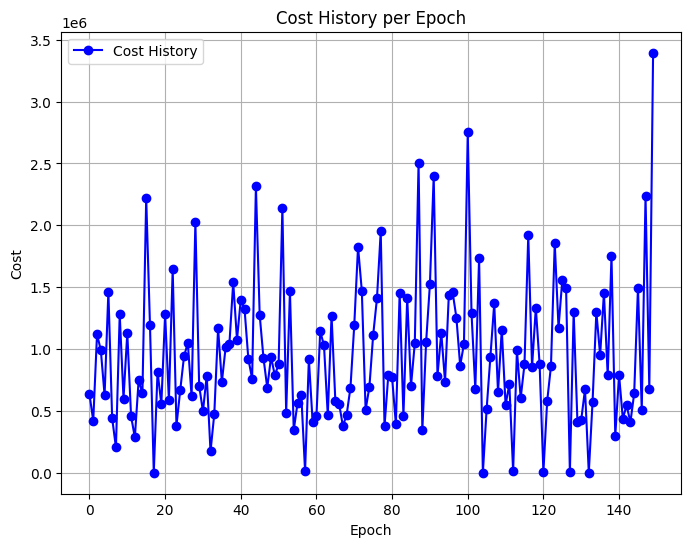

In [115]:
# Plotting the cost history
plt.figure(figsize=(8, 6))  # Optional: Set figure size
plt.plot(np.arange(len(results)), results, marker='o', linestyle='-', color='b', label='Cost History')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Cost History per Epoch')
plt.legend()

# Display the plot
plt.grid(True)  # Optional: Add grid for better visualization
plt.show()


### Generate initial sampling plan using LHS

In [116]:
x = LHS_sample(N_INITIAL, DIM)
x = torch.from_numpy(x)
x = x.to(torch.float32)

In [117]:
import os.path

name_f, name_x = 'f.mat', 'x.mat'
path = './'
pathname_f = path + name_f
pathname_x = path + name_x
check_file = os.path.isfile(pathname_f)
if check_file:
    mat_contents = sio.loadmat(pathname_f)
    f = mat_contents['f']
    f = torch.Tensor(f)
    f = f.view(N_INITIAL)
    
    mat_contents = sio.loadmat(pathname_x)
    x = mat_contents['x']
    x = torch.Tensor(x)
else:
    f = obj_fun(x)
    f = f.view(N_INITIAL)
    sio.savemat(name_f, {'f': f.numpy()})
    sio.savemat(name_x, {'x': x.numpy()})

In [118]:
train_x, val_x, train_g, val_g = train_test_split(x, f, test_size=0.20)
# Converter os dados de treino e validação para o tipo float32
train_x = train_x.float()
train_g = train_g.float()
val_x = val_x.float()
val_g = val_g.float()
print(train_x)
print(train_g)
print(val_x)
print(val_g)



tensor([[6.3312e-02, 7.5044e-01, 9.6571e-01, 2.0817e-01, 6.1828e-01, 5.7997e-01,
         9.9556e-01, 4.0134e-01, 3.3361e-01, 7.3824e-01, 4.5950e-01],
        [2.9149e-01, 3.3588e-02, 1.4165e-01, 5.8050e-02, 3.5152e-01, 4.3432e-01,
         5.5997e-01, 6.0602e-01, 6.6567e-01, 7.7392e-01, 2.2321e-02],
        [7.0882e-01, 4.5229e-01, 7.3998e-01, 8.0126e-01, 3.8979e-01, 3.9787e-01,
         8.1519e-01, 9.3401e-01, 4.8067e-02, 7.5000e-01, 9.6860e-01],
        [2.5523e-01, 4.3236e-01, 5.9522e-01, 4.8902e-01, 1.2326e-03, 9.8389e-02,
         3.9852e-01, 9.1602e-01, 8.4100e-01, 6.6541e-01, 6.6432e-02],
        [8.5194e-01, 7.3827e-01, 9.6046e-02, 5.3888e-01, 2.3289e-01, 6.8780e-01,
         1.6343e-01, 7.5135e-01, 3.8542e-01, 8.2679e-01, 3.1997e-01],
        [2.6765e-01, 4.8540e-02, 5.5166e-02, 7.1814e-01, 5.7336e-01, 5.2614e-01,
         7.6065e-02, 8.2254e-01, 3.0937e-01, 6.5807e-01, 4.6435e-01],
        [9.1331e-01, 3.2913e-01, 3.0923e-02, 4.7034e-01, 7.6475e-01, 4.1778e-01,
         8.95

## Efficient Global Optimization

Best Loss: 36.134132385253906 at epoch 9999. Training loss: 71.45045471191406 and val. loss: 36.134132385253906


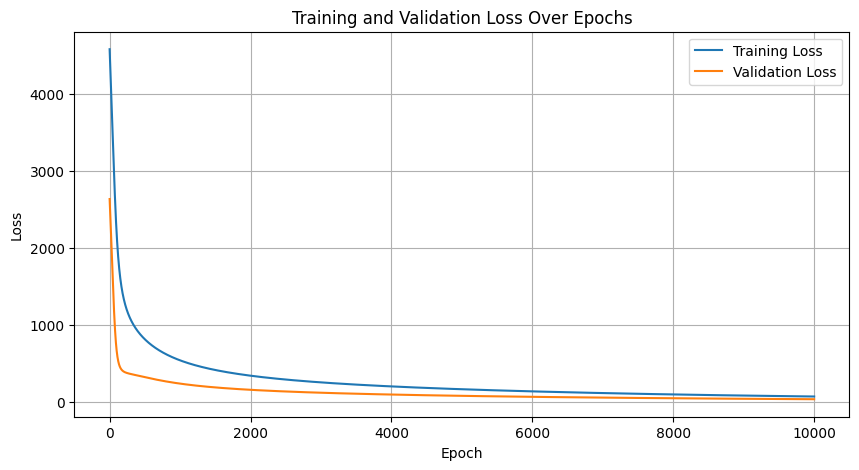


Iteration 0. Best of DGPR: 0.0. GPR model: Train loss = 36.134132385253906; Val. loss = 71.45045471191406


In [119]:
model, likelihood, best_loss = train_model(train_x, train_g, val_x, val_g, TRAINING_ITERATIONS)
model.eval()
likelihood.eval()
it = 0
print(f'\nIteration {it}. Best of DGPR: {torch.min(f)}. GPR model: Train loss = {best_loss[0]}; Val. loss = {best_loss[-1]}')

Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:01:00 -- Predicted time 00:01:00
Best =          -0.00000000   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00000000   ###   (  50% completed ): Elapsed time 00:00:09 -- Reamining time 00:00:09 -- Predicted time 00:00:19
Best =          -0.00000000   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 4 of 100
Best Loss: 44.90313720703125 at epoch 9999. Training loss: 66.21604919433594 and val. loss: 44.90313720703125


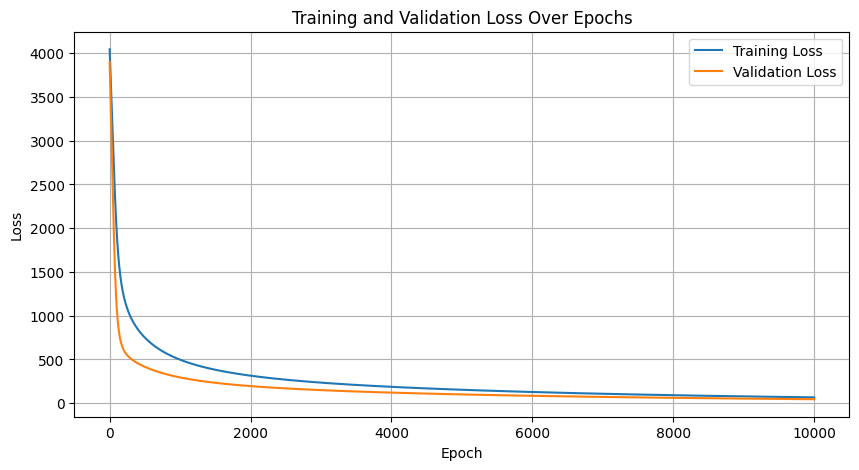


Iteration 4. Best of DGPR: 0.0. GPR model: Train loss = 44.90313720703125; Val. loss = 66.21604919433594
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.00000007   ###   (  25% completed ): Elapsed time 00:00:07 -- Reamining time 00:00:22 -- Predicted time 00:00:30
Best =          -0.00000007   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00000007   ###   (  75% completed ): Elapsed time 00:00:37 -- Reamining time 00:00:12 -- Predicted time 00:00:50
Iteration 5 of 100
Best Loss: 38.01853561401367 at epoch 9999. Training loss: 66.37054443359375 and val. loss: 38.01853561401367


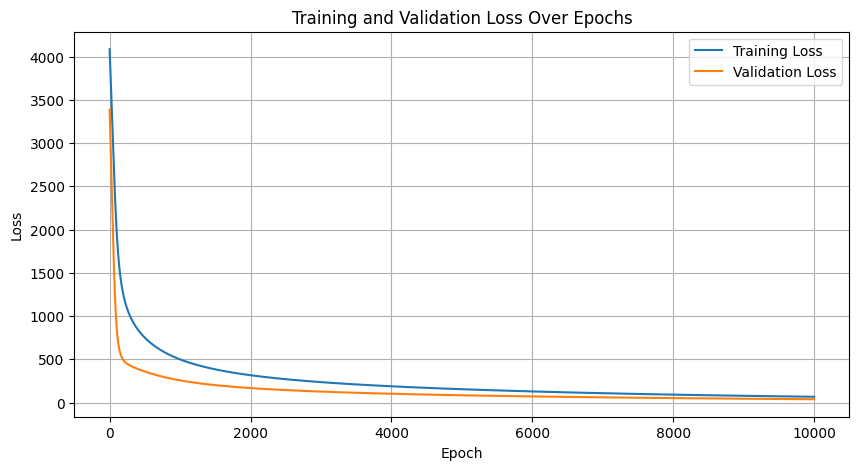


Iteration 5. Best of DGPR: 0.0. GPR model: Train loss = 38.01853561401367; Val. loss = 66.37054443359375
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.00000050   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:32 -- Predicted time 00:00:43
Best =          -0.00000050   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00000050   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 6 of 100
Best Loss: 51.47756576538086 at epoch 9999. Training loss: 61.64101028442383 and val. loss: 51.47756576538086


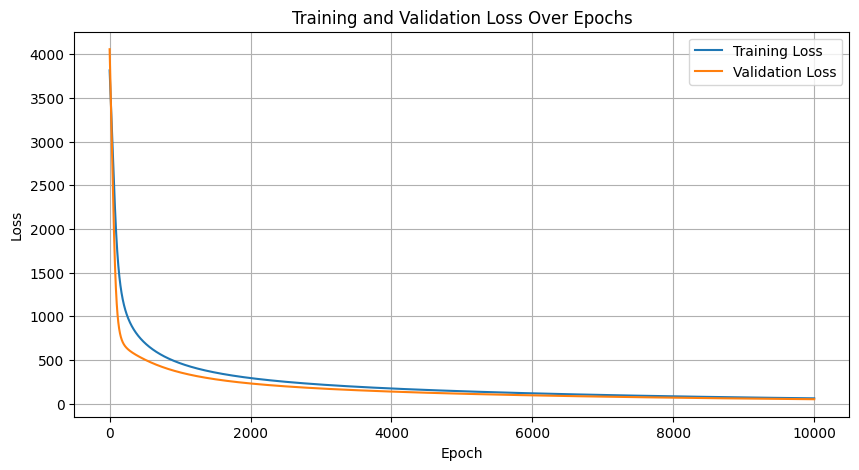


Iteration 6. Best of DGPR: 0.0. GPR model: Train loss = 51.47756576538086; Val. loss = 61.64101028442383
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:50 -- Predicted time 00:00:50
Best =          -0.00225467   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00225467   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00225467   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 7 of 100
Best Loss: 18.479768753051758 at epoch 9999. Training loss: 68.05899810791016 and val. loss: 18.479768753051758


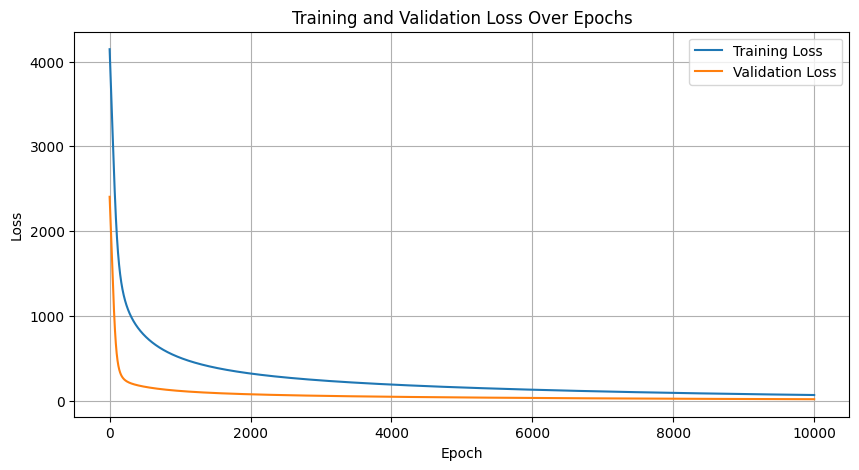


Iteration 7. Best of DGPR: 0.0. GPR model: Train loss = 18.479768753051758; Val. loss = 68.05899810791016
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:30 -- Predicted time 00:00:30
Best =          -0.00005039   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:32 -- Predicted time 00:00:42
Best =          -0.00005039   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00005039   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 8 of 100
Early stopping at epoch 1125
Best Loss: 219.4981231689453 at epoch 123. Training loss: 1729.9464111328125 and val. loss: 219.4981231689453


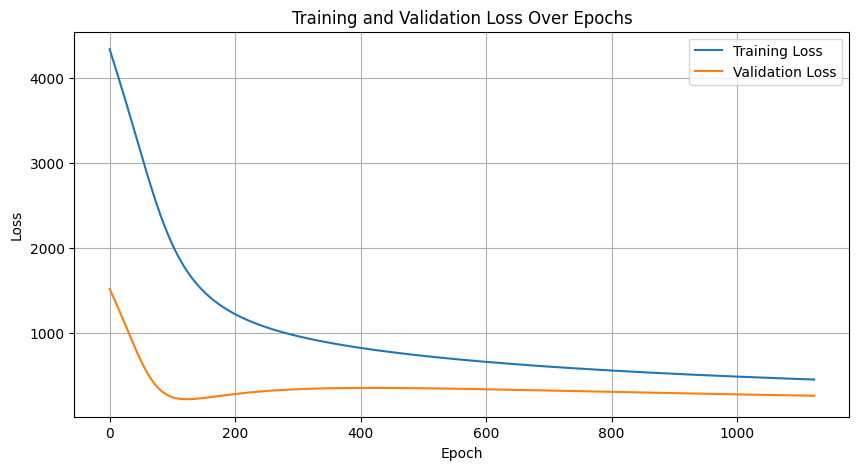


Iteration 8. Best of DGPR: 0.0. GPR model: Train loss = 219.4981231689453; Val. loss = 1729.9464111328125
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:30 -- Predicted time 00:00:30
Best =          -4.83958802   ###   (  25% completed ): Elapsed time 00:00:09 -- Reamining time 00:00:29 -- Predicted time 00:00:39
Best =          -4.83958850   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -4.83958850   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 9 of 100
Best Loss: 20.292678833007812 at epoch 9999. Training loss: 66.26936340332031 and val. loss: 20.292678833007812


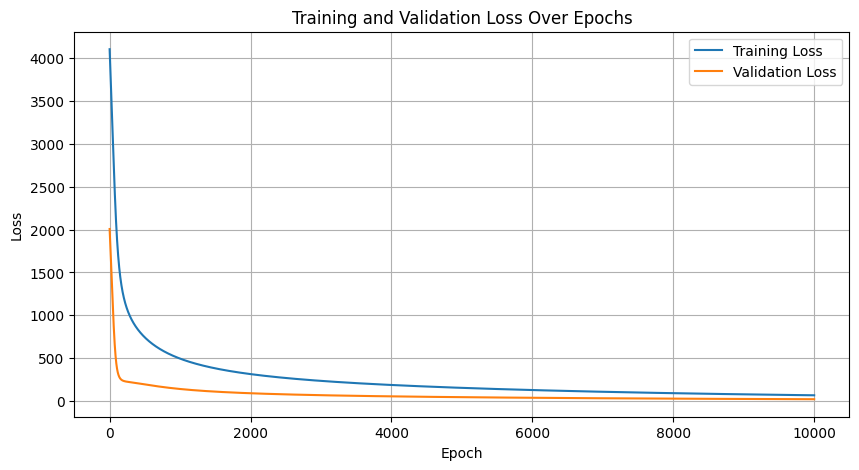


Iteration 9. Best of DGPR: 0.0. GPR model: Train loss = 20.292678833007812; Val. loss = 66.26936340332031
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:39 -- Predicted time 00:00:39
Best =          -0.01410457   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:32 -- Predicted time 00:00:42
Best =          -0.01410459   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.01410459   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 10 of 100
Early stopping at epoch 1174
Best Loss: 91.84651947021484 at epoch 172. Training loss: 1348.1395263671875 and val. loss: 91.84651947021484


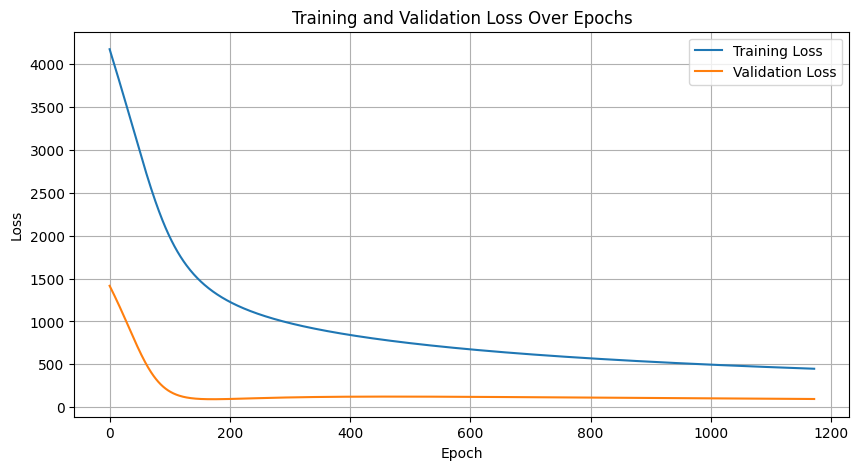


Iteration 10. Best of DGPR: 0.0. GPR model: Train loss = 91.84651947021484; Val. loss = 1348.1395263671875
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -3.60474355   ###   (  25% completed ): Elapsed time 00:00:17 -- Reamining time 00:00:52 -- Predicted time 00:01:10
Best =          -3.60474355   ###   (  50% completed ): Elapsed time 00:00:31 -- Reamining time 00:00:31 -- Predicted time 00:01:02
Best =          -3.60474364   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 11 of 100
Best Loss: 49.604251861572266 at epoch 9999. Training loss: 56.61594009399414 and val. loss: 49.604251861572266


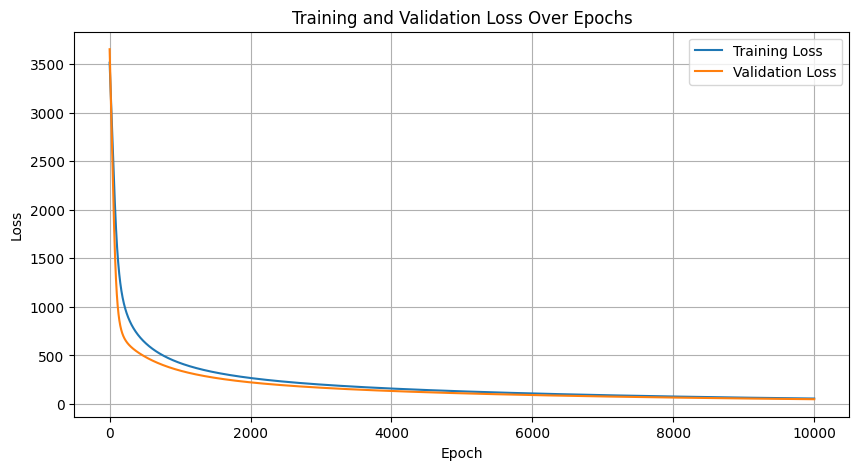


Iteration 11. Best of DGPR: 0.0. GPR model: Train loss = 49.604251861572266; Val. loss = 56.61594009399414
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:01:00 -- Predicted time 00:01:00
Best =          -0.01209280   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.01209280   ###   (  50% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:10 -- Predicted time 00:00:20
Best =          -0.01209280   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 12 of 100
Best Loss: 39.97470474243164 at epoch 9999. Training loss: 58.75136184692383 and val. loss: 39.97470474243164


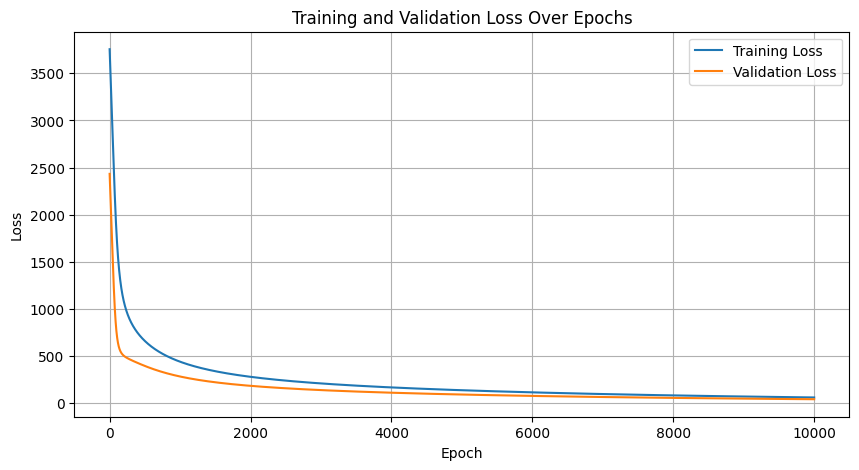


Iteration 12. Best of DGPR: 0.0. GPR model: Train loss = 39.97470474243164; Val. loss = 58.75136184692383
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:39 -- Predicted time 00:00:39
Best =          -0.00047357   ###   (  25% completed ): Elapsed time 00:00:12 -- Reamining time 00:00:37 -- Predicted time 00:00:50
Best =          -0.00047357   ###   (  50% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:10 -- Predicted time 00:00:20
Best =          -0.00047357   ###   (  75% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:05 -- Predicted time 00:00:20
Iteration 13 of 100
Best Loss: 32.12997817993164 at epoch 9999. Training loss: 60.79531478881836 and val. loss: 32.12997817993164


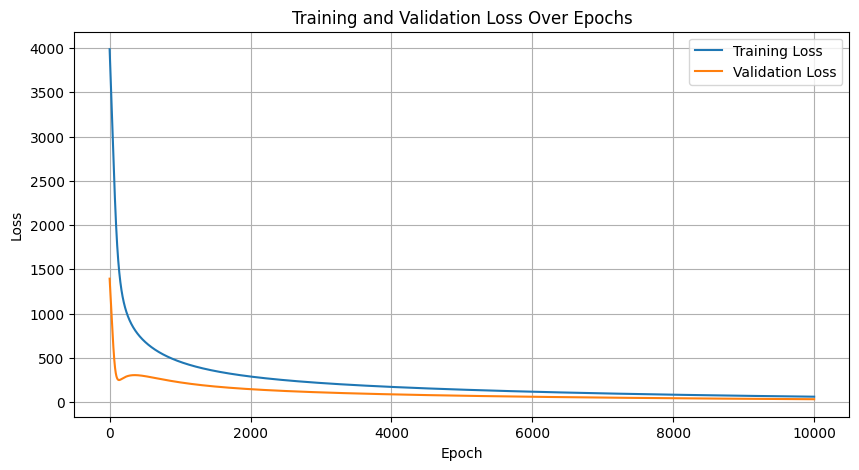


Iteration 13. Best of DGPR: 0.0. GPR model: Train loss = 32.12997817993164; Val. loss = 60.79531478881836
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.00000058   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00000058   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00000058   ###   (  75% completed ): Elapsed time 00:00:32 -- Reamining time 00:00:10 -- Predicted time 00:00:43
Iteration 14 of 100
Best Loss: 21.66762351989746 at epoch 9999. Training loss: 60.92195129394531 and val. loss: 21.66762351989746


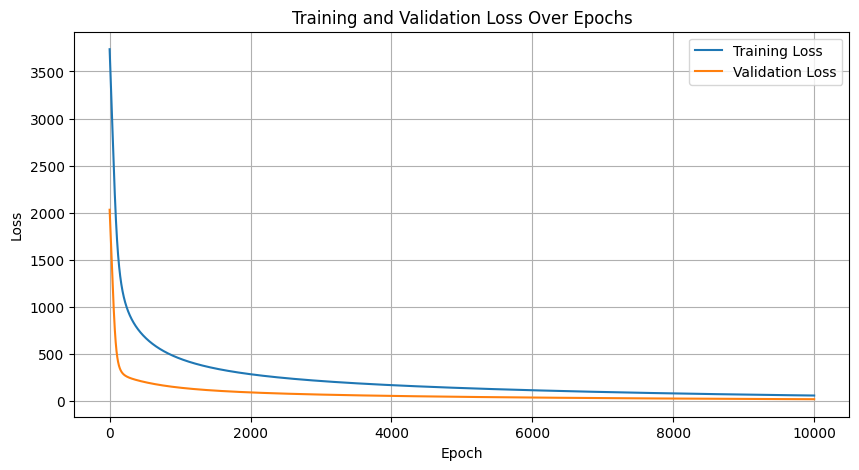


Iteration 14. Best of DGPR: 0.0. GPR model: Train loss = 21.66762351989746; Val. loss = 60.92195129394531
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:20 -- Predicted time 00:00:20
Best =          -0.02459036   ###   (  25% completed ): Elapsed time 00:00:30 -- Reamining time 00:01:30 -- Predicted time 00:02:00
Best =          -0.02459038   ###   (  50% completed ): Elapsed time 00:00:25 -- Reamining time 00:00:25 -- Predicted time 00:00:50
Best =          -0.02459044   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 15 of 100
Best Loss: 12.486170768737793 at epoch 9999. Training loss: 61.52663040161133 and val. loss: 12.486170768737793


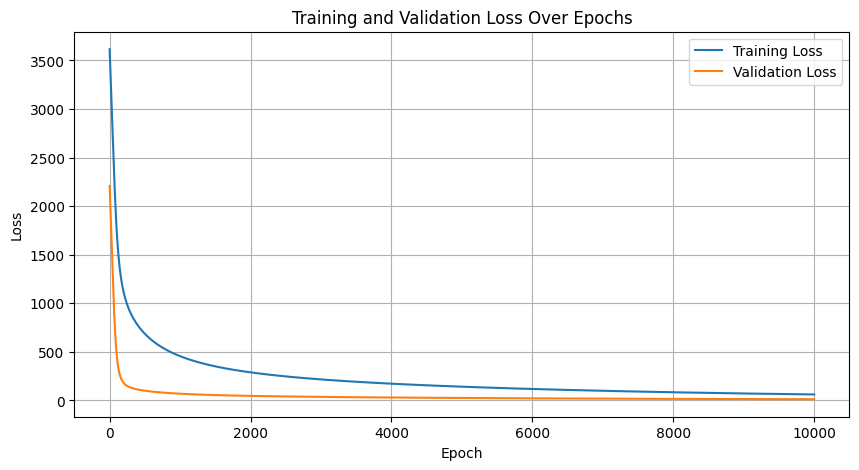


Iteration 15. Best of DGPR: 0.0. GPR model: Train loss = 12.486170768737793; Val. loss = 61.52663040161133
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.00419522   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00419522   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00419522   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 16 of 100
Best Loss: 19.61292266845703 at epoch 9999. Training loss: 58.755653381347656 and val. loss: 19.61292266845703


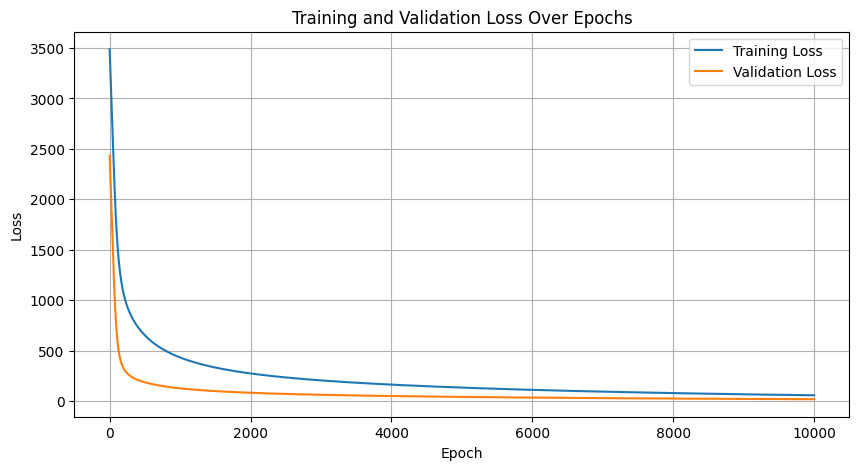


Iteration 16. Best of DGPR: 0.0. GPR model: Train loss = 19.61292266845703; Val. loss = 58.755653381347656
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:50 -- Predicted time 00:00:50
Best =          -0.00030652   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00030652   ###   (  50% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:10 -- Predicted time 00:00:20
Best =          -0.00030653   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 17 of 100
Best Loss: 30.80099868774414 at epoch 9999. Training loss: 55.058509826660156 and val. loss: 30.80099868774414


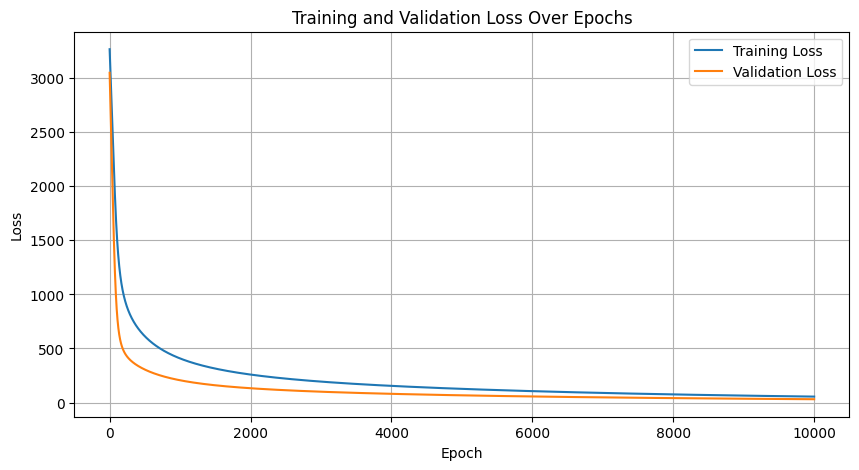


Iteration 17. Best of DGPR: 0.0. GPR model: Train loss = 30.80099868774414; Val. loss = 55.058509826660156
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:20 -- Predicted time 00:00:20
Best =          -0.00166827   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00166827   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00166828   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 18 of 100
Best Loss: 30.10862922668457 at epoch 9999. Training loss: 55.82993698120117 and val. loss: 30.10862922668457


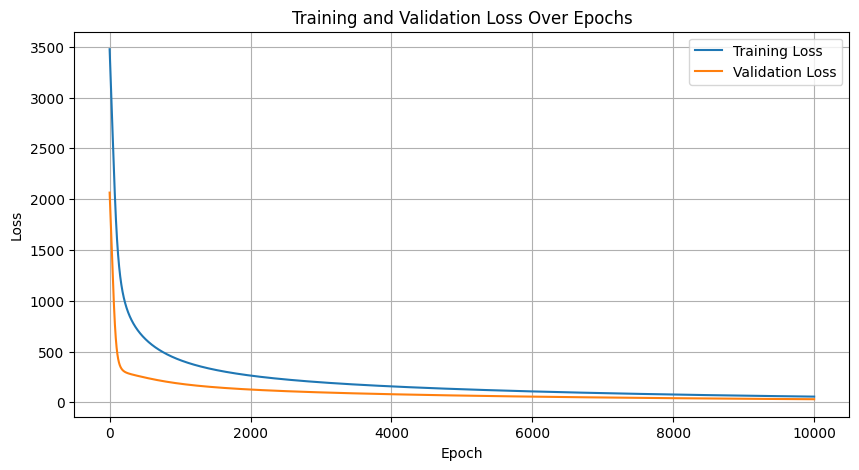


Iteration 18. Best of DGPR: 0.0. GPR model: Train loss = 30.10862922668457; Val. loss = 55.82993698120117
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:01:05 -- Predicted time 00:01:05
Best =          -0.00001247   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00001247   ###   (  50% completed ): Elapsed time 00:00:25 -- Reamining time 00:00:25 -- Predicted time 00:00:50
Best =          -0.00001247   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 19 of 100
Best Loss: 17.303831100463867 at epoch 9999. Training loss: 57.69357681274414 and val. loss: 17.303831100463867


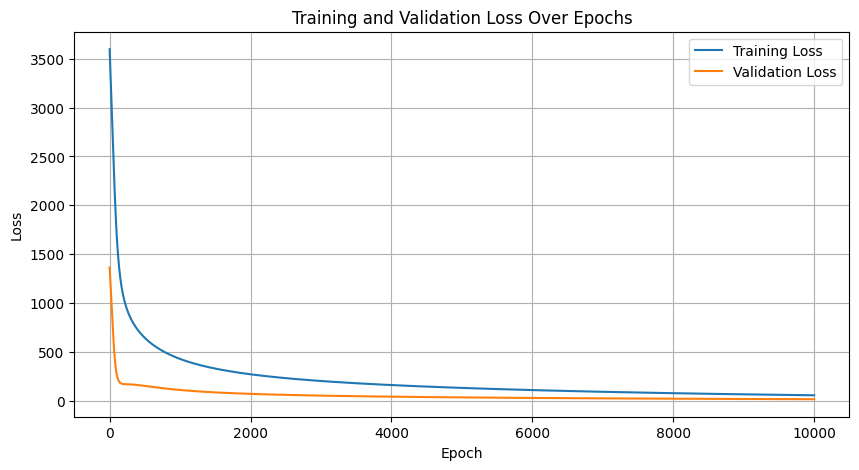


Iteration 19. Best of DGPR: 0.0. GPR model: Train loss = 17.303831100463867; Val. loss = 57.69357681274414
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:19 -- Predicted time 00:00:19
Best =          -0.03212641   ###   (  25% completed ): Elapsed time 00:00:07 -- Reamining time 00:00:22 -- Predicted time 00:00:30
Best =          -0.03212643   ###   (  50% completed ): Elapsed time 00:00:25 -- Reamining time 00:00:25 -- Predicted time 00:00:50
Best =          -0.03212649   ###   (  75% completed ): Elapsed time 00:00:45 -- Reamining time 00:00:15 -- Predicted time 00:01:00
Iteration 20 of 100
Best Loss: 25.63974380493164 at epoch 9999. Training loss: 54.85723114013672 and val. loss: 25.63974380493164


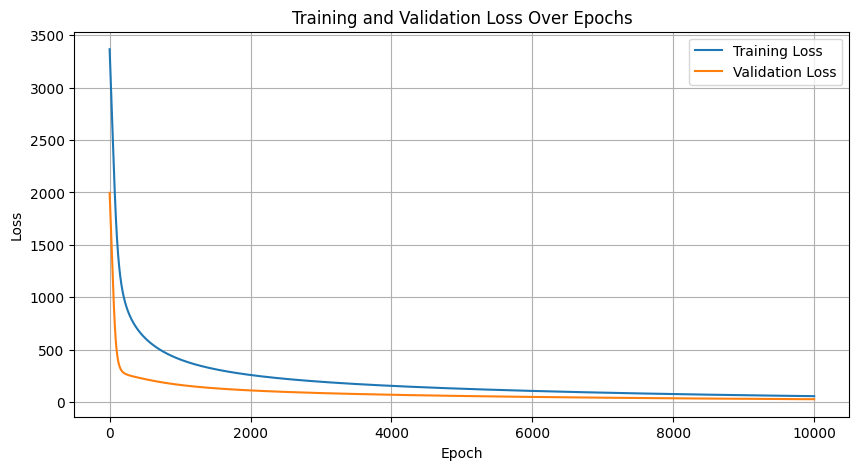


Iteration 20. Best of DGPR: 0.0. GPR model: Train loss = 25.63974380493164; Val. loss = 54.85723114013672
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:43 -- Predicted time 00:00:43
Best =          -0.00561148   ###   (  25% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:45 -- Predicted time 00:01:00
Best =          -0.00561148   ###   (  50% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:10 -- Predicted time 00:00:20
Best =          -0.00561148   ###   (  75% completed ): Elapsed time 00:00:45 -- Reamining time 00:00:15 -- Predicted time 00:01:00
Iteration 21 of 100
Best Loss: 101.86096954345703 at epoch 9999. Training loss: 38.78520202636719 and val. loss: 101.86096954345703


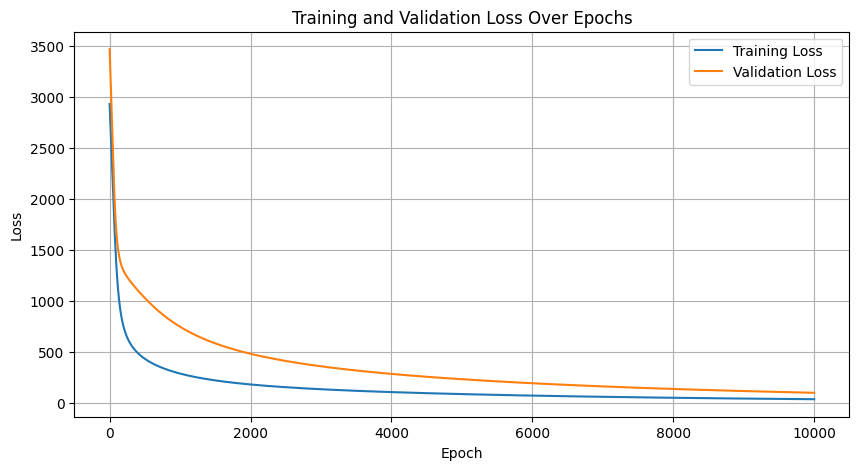


Iteration 21. Best of DGPR: 0.0. GPR model: Train loss = 101.86096954345703; Val. loss = 38.78520202636719
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:50 -- Predicted time 00:00:50
Best =          -0.00001340   ###   (  25% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:45 -- Predicted time 00:01:00
Best =          -0.00001340   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00001340   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 22 of 100
Best Loss: 58.074729919433594 at epoch 9999. Training loss: 43.955543518066406 and val. loss: 58.074729919433594


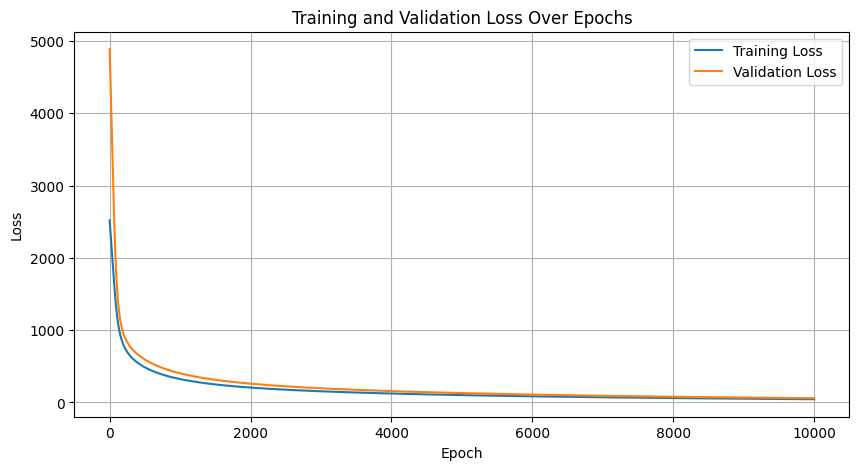


Iteration 22. Best of DGPR: 0.0. GPR model: Train loss = 58.074729919433594; Val. loss = 43.955543518066406
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.00000329   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00000329   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00000329   ###   (  75% completed ): Elapsed time 00:00:45 -- Reamining time 00:00:15 -- Predicted time 00:01:00
Iteration 23 of 100
Best Loss: 34.281654357910156 at epoch 9999. Training loss: 53.256622314453125 and val. loss: 34.281654357910156


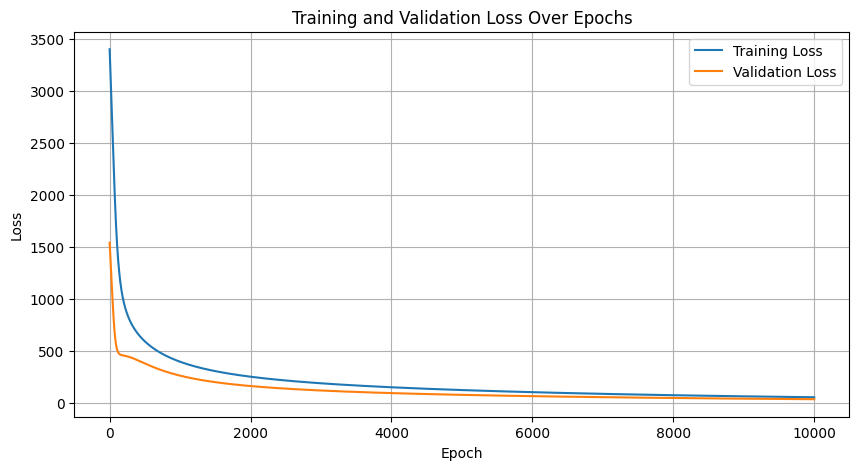


Iteration 23. Best of DGPR: 0.0. GPR model: Train loss = 34.281654357910156; Val. loss = 53.256622314453125
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:20 -- Predicted time 00:00:20
Best =          -0.00000164   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00000164   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00000164   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 24 of 100
Best Loss: 39.24220657348633 at epoch 9999. Training loss: 50.87430191040039 and val. loss: 39.24220657348633


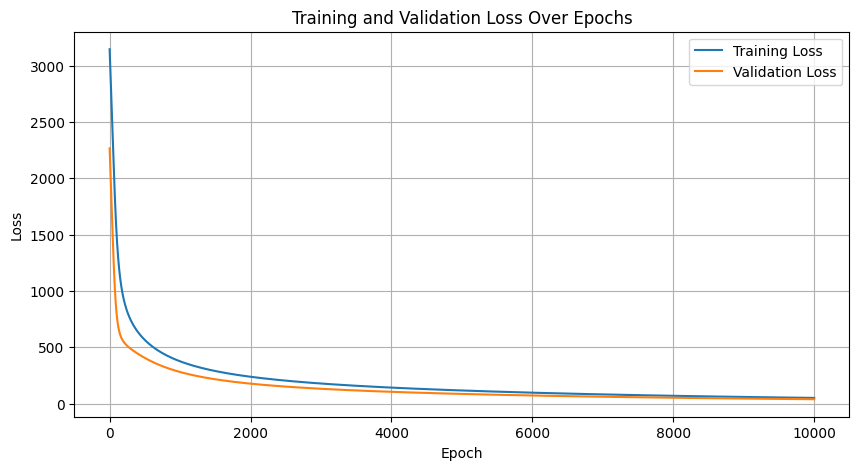


Iteration 24. Best of DGPR: 0.0. GPR model: Train loss = 39.24220657348633; Val. loss = 50.87430191040039
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.00005952   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00005952   ###   (  50% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:30 -- Predicted time 00:01:00
Best =          -0.00005952   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 25 of 100
Best Loss: 66.16007232666016 at epoch 9999. Training loss: 44.15574645996094 and val. loss: 66.16007232666016


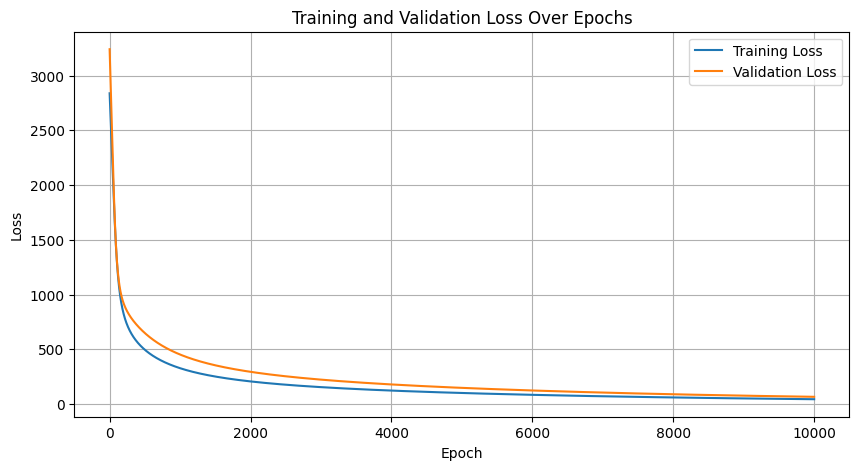


Iteration 25. Best of DGPR: 0.0. GPR model: Train loss = 66.16007232666016; Val. loss = 44.15574645996094
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.00000011   ###   (  25% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:45 -- Predicted time 00:01:00
Best =          -0.00000011   ###   (  50% completed ): Elapsed time 00:00:25 -- Reamining time 00:00:25 -- Predicted time 00:00:50
Best =          -0.00000011   ###   (  75% completed ): Elapsed time 00:00:52 -- Reamining time 00:00:17 -- Predicted time 00:01:10
Iteration 26 of 100
Best Loss: 36.26677322387695 at epoch 9999. Training loss: 49.4785041809082 and val. loss: 36.26677322387695


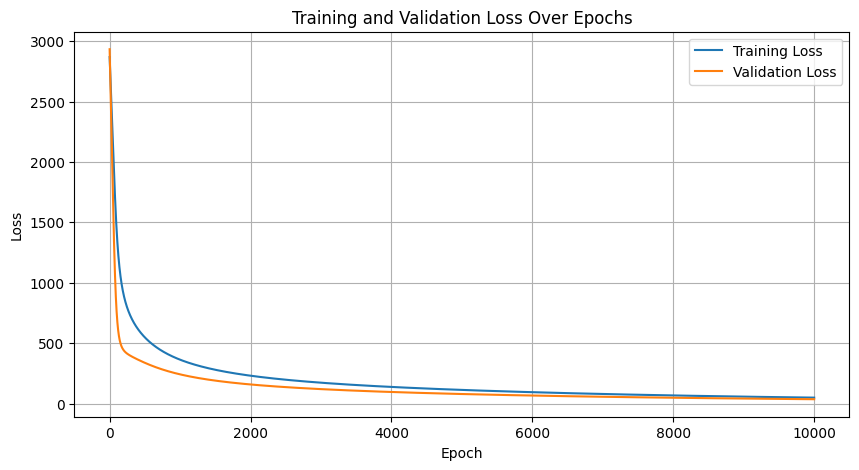


Iteration 26. Best of DGPR: 0.0. GPR model: Train loss = 36.26677322387695; Val. loss = 49.4785041809082
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:20 -- Predicted time 00:00:20
Best =          -0.00001595   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00001595   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:41
Best =          -0.00001595   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 27 of 100
Best Loss: 25.514223098754883 at epoch 9999. Training loss: 51.141422271728516 and val. loss: 25.514223098754883


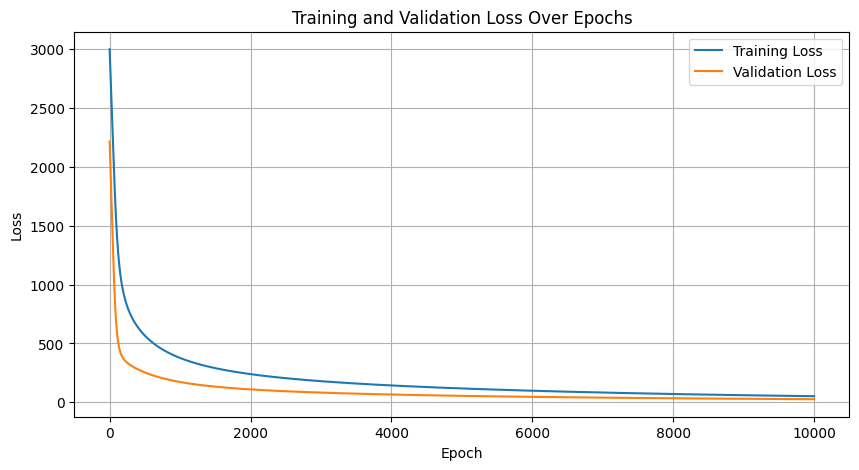


Iteration 27. Best of DGPR: 0.0. GPR model: Train loss = 25.514223098754883; Val. loss = 51.141422271728516
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:50 -- Predicted time 00:00:50
Best =          -0.00001985   ###   (  25% completed ): Elapsed time 00:00:07 -- Reamining time 00:00:22 -- Predicted time 00:00:30
Best =          -0.00001986   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00001986   ###   (  75% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:05 -- Predicted time 00:00:20
Iteration 28 of 100
Best Loss: 35.81879425048828 at epoch 9999. Training loss: 48.846351623535156 and val. loss: 35.81879425048828


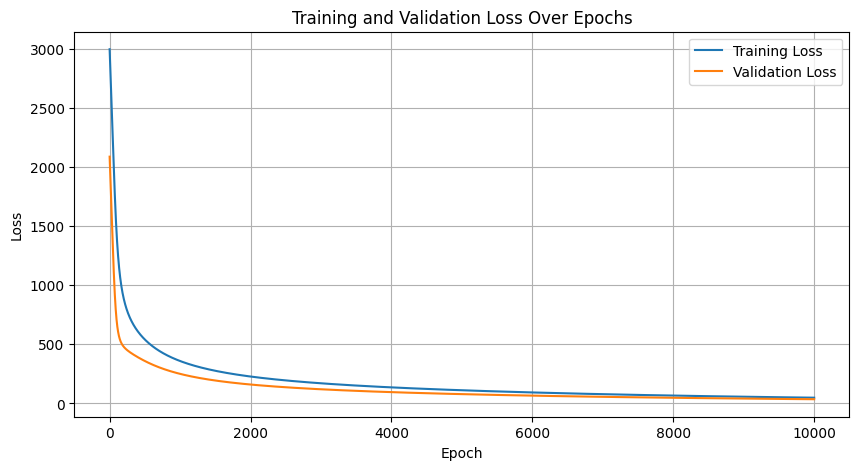


Iteration 28. Best of DGPR: 0.0. GPR model: Train loss = 35.81879425048828; Val. loss = 48.846351623535156
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:19 -- Predicted time 00:00:19
Best =          -0.00000856   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00000856   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00000856   ###   (  75% completed ): Elapsed time 00:00:29 -- Reamining time 00:00:09 -- Predicted time 00:00:39
Iteration 29 of 100
Best Loss: 84.10234069824219 at epoch 9999. Training loss: 36.61195755004883 and val. loss: 84.10234069824219


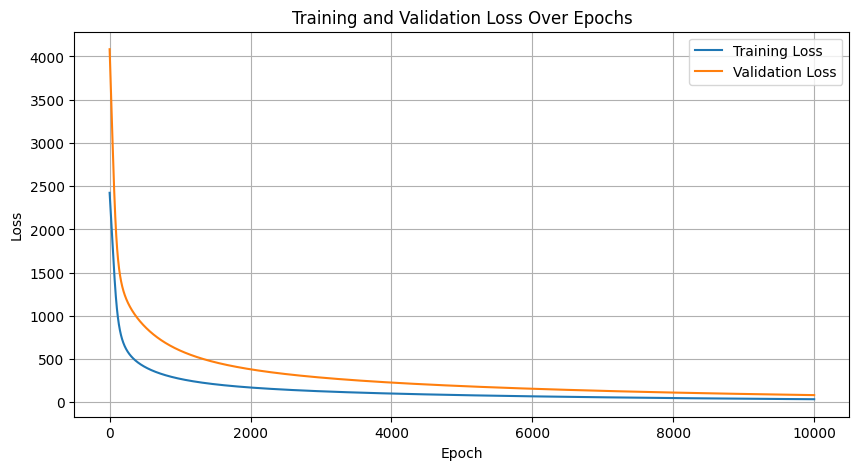


Iteration 29. Best of DGPR: 0.0. GPR model: Train loss = 84.10234069824219; Val. loss = 36.61195755004883
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:01:00 -- Predicted time 00:01:00
Best =          -0.00005068   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00005068   ###   (  50% completed ): Elapsed time 00:00:25 -- Reamining time 00:00:25 -- Predicted time 00:00:50
Best =          -0.00005068   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 30 of 100
Best Loss: 75.29058837890625 at epoch 9999. Training loss: 37.603858947753906 and val. loss: 75.29058837890625


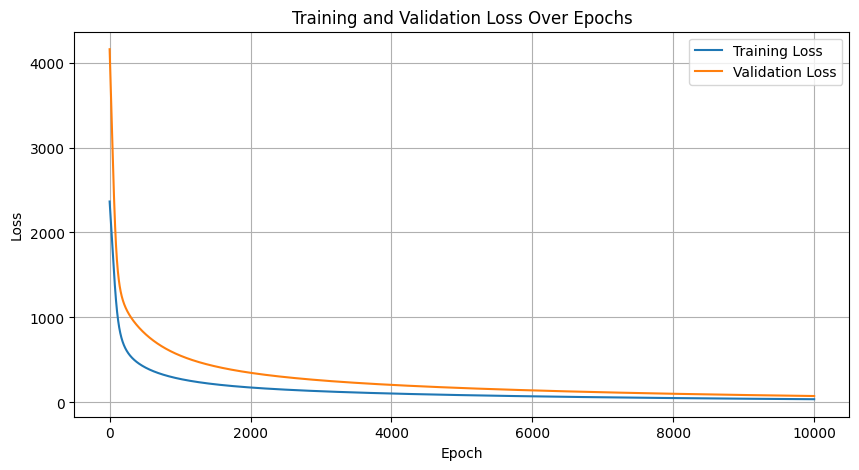


Iteration 30. Best of DGPR: 0.0. GPR model: Train loss = 75.29058837890625; Val. loss = 37.603858947753906
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.01251660   ###   (  25% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:45 -- Predicted time 00:01:00
Best =          -0.01251660   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.01251662   ###   (  75% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:05 -- Predicted time 00:00:20
Iteration 31 of 100
Best Loss: 25.015811920166016 at epoch 9999. Training loss: 49.530128479003906 and val. loss: 25.015811920166016


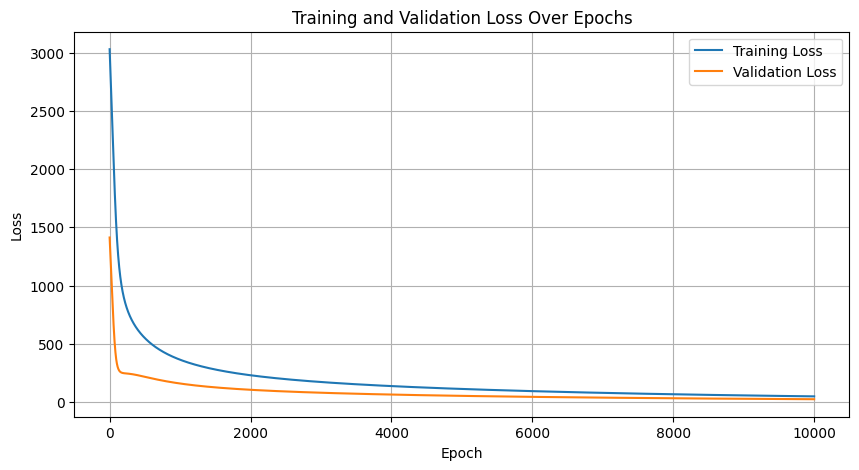


Iteration 31. Best of DGPR: 0.0. GPR model: Train loss = 25.015811920166016; Val. loss = 49.530128479003906
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.00004992   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00004992   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00004992   ###   (  75% completed ): Elapsed time 00:00:29 -- Reamining time 00:00:09 -- Predicted time 00:00:39
Iteration 32 of 100
Best Loss: 46.06544494628906 at epoch 9999. Training loss: 42.91039276123047 and val. loss: 46.06544494628906


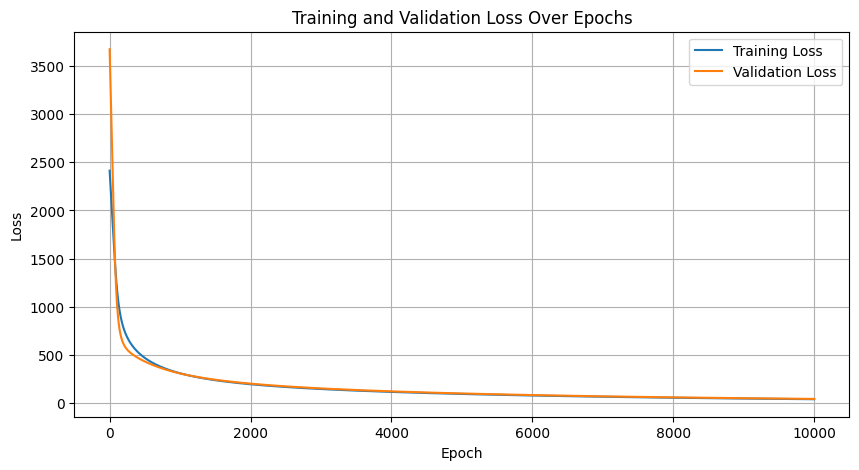


Iteration 32. Best of DGPR: 0.0. GPR model: Train loss = 46.06544494628906; Val. loss = 42.91039276123047
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:50 -- Predicted time 00:00:50
Best =          -0.00087168   ###   (  25% completed ): Elapsed time 00:00:12 -- Reamining time 00:00:37 -- Predicted time 00:00:50
Best =          -0.00087169   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00087169   ###   (  75% completed ): Elapsed time 00:00:45 -- Reamining time 00:00:15 -- Predicted time 00:01:00
Iteration 33 of 100
Best Loss: 53.111854553222656 at epoch 9999. Training loss: 41.61846160888672 and val. loss: 53.111854553222656


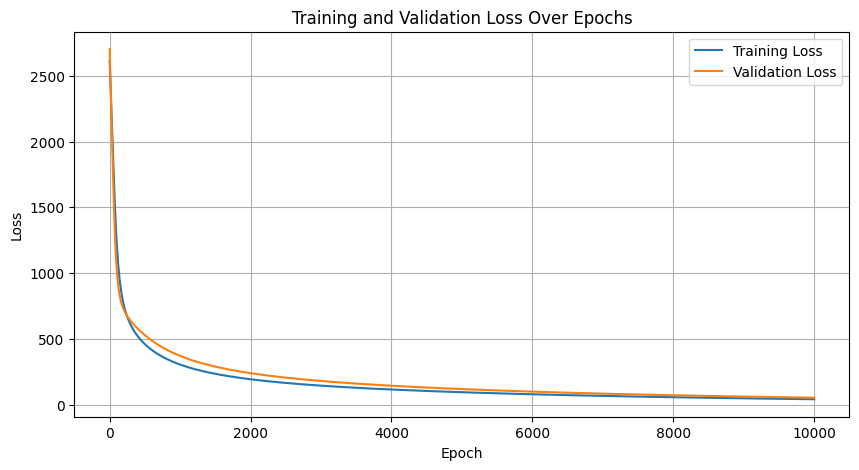


Iteration 33. Best of DGPR: 0.0. GPR model: Train loss = 53.111854553222656; Val. loss = 41.61846160888672
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:01:00 -- Predicted time 00:01:00
Best =          -0.00128384   ###   (  25% completed ): Elapsed time 00:00:12 -- Reamining time 00:00:37 -- Predicted time 00:00:50
Best =          -0.00128385   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00128385   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 34 of 100
Best Loss: 55.75180435180664 at epoch 9999. Training loss: 40.23138427734375 and val. loss: 55.75180435180664


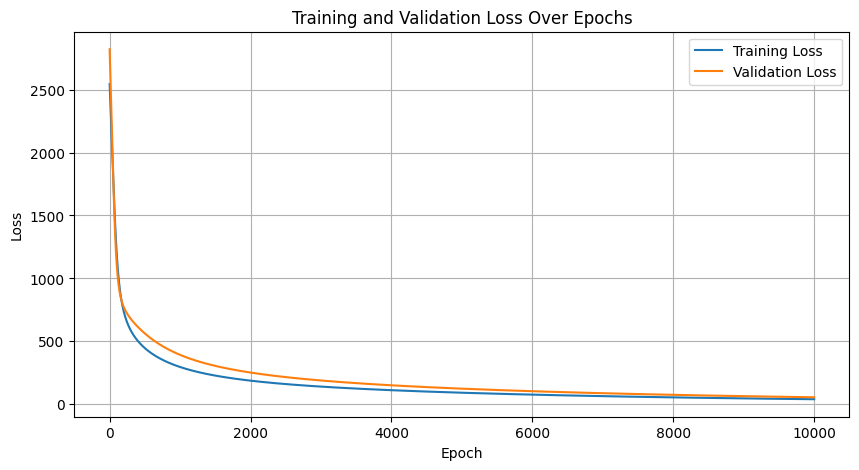


Iteration 34. Best of DGPR: 0.0. GPR model: Train loss = 55.75180435180664; Val. loss = 40.23138427734375
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:45 -- Predicted time 00:00:45
Best =          -0.00212005   ###   (  25% completed ): Elapsed time 00:00:05 -- Reamining time 00:00:15 -- Predicted time 00:00:20
Best =          -0.00212005   ###   (  50% completed ): Elapsed time 00:00:25 -- Reamining time 00:00:25 -- Predicted time 00:00:50
Best =          -0.00212005   ###   (  75% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:05 -- Predicted time 00:00:20
Iteration 35 of 100
Best Loss: 68.94274139404297 at epoch 9999. Training loss: 36.78729248046875 and val. loss: 68.94274139404297


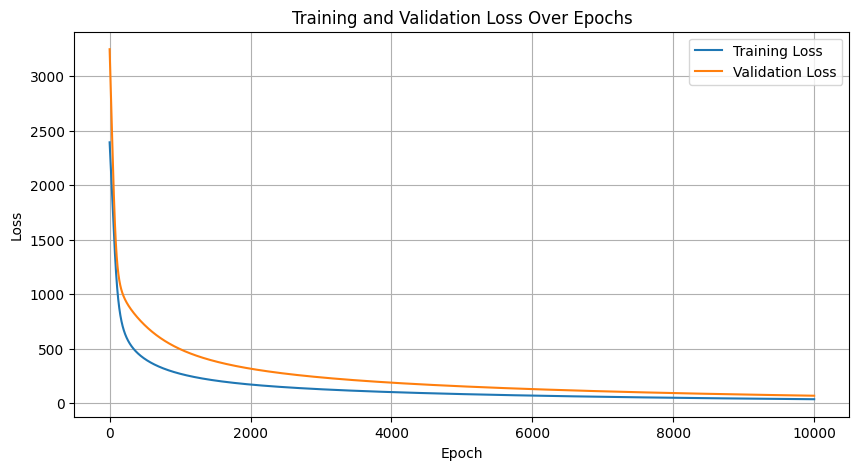


Iteration 35. Best of DGPR: 0.0. GPR model: Train loss = 68.94274139404297; Val. loss = 36.78729248046875
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:50 -- Predicted time 00:00:50
Best =          -0.00065156   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00065156   ###   (  50% completed ): Elapsed time 00:00:25 -- Reamining time 00:00:25 -- Predicted time 00:00:50
Best =          -0.00065156   ###   (  75% completed ): Elapsed time 00:00:45 -- Reamining time 00:00:15 -- Predicted time 00:01:00
Iteration 36 of 100
Best Loss: 12.984800338745117 at epoch 9999. Training loss: 48.391014099121094 and val. loss: 12.984800338745117


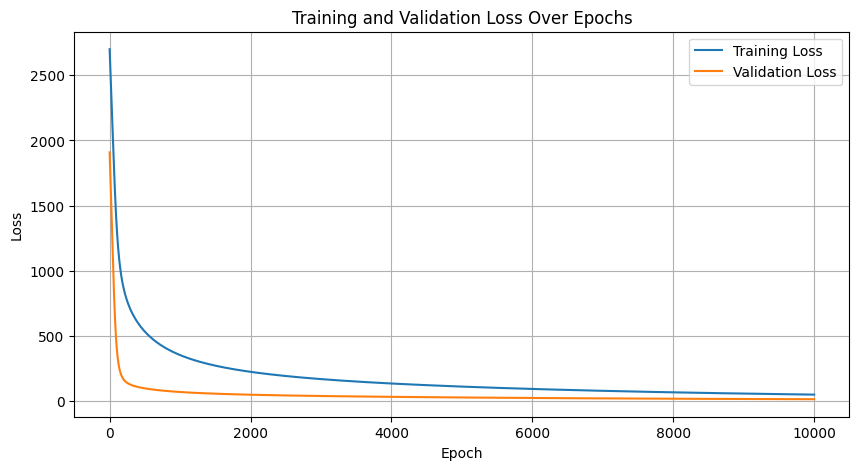


Iteration 36. Best of DGPR: 0.0. GPR model: Train loss = 12.984800338745117; Val. loss = 48.391014099121094
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:01:00 -- Predicted time 00:01:00
Best =          -0.00028206   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00028206   ###   (  50% completed ): Elapsed time 00:00:40 -- Reamining time 00:00:40 -- Predicted time 00:01:20
Best =          -0.00028206   ###   (  75% completed ): Elapsed time 00:00:37 -- Reamining time 00:00:12 -- Predicted time 00:00:50
Iteration 37 of 100
Best Loss: 24.484418869018555 at epoch 9999. Training loss: 45.742950439453125 and val. loss: 24.484418869018555


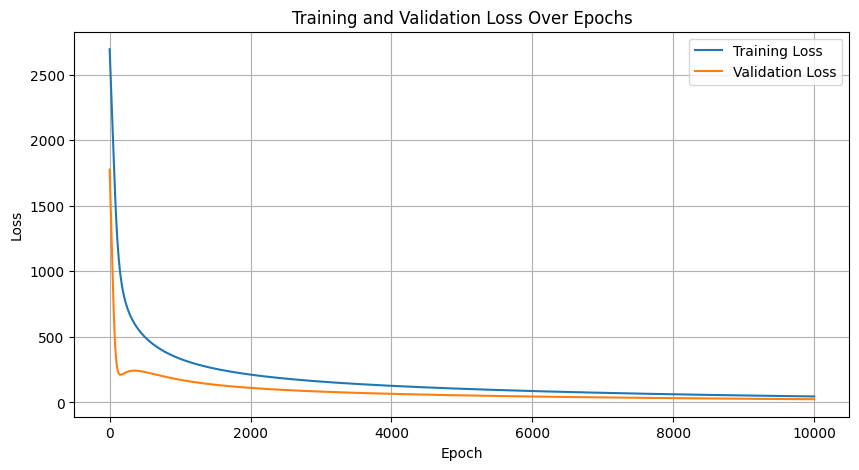


Iteration 37. Best of DGPR: 0.0. GPR model: Train loss = 24.484418869018555; Val. loss = 45.742950439453125
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:50 -- Predicted time 00:00:50
Best =          -0.01095348   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.01095352   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.01095359   ###   (  75% completed ): Elapsed time 00:00:45 -- Reamining time 00:00:15 -- Predicted time 00:01:00
Iteration 38 of 100
Best Loss: 56.138614654541016 at epoch 9999. Training loss: 36.960350036621094 and val. loss: 56.138614654541016


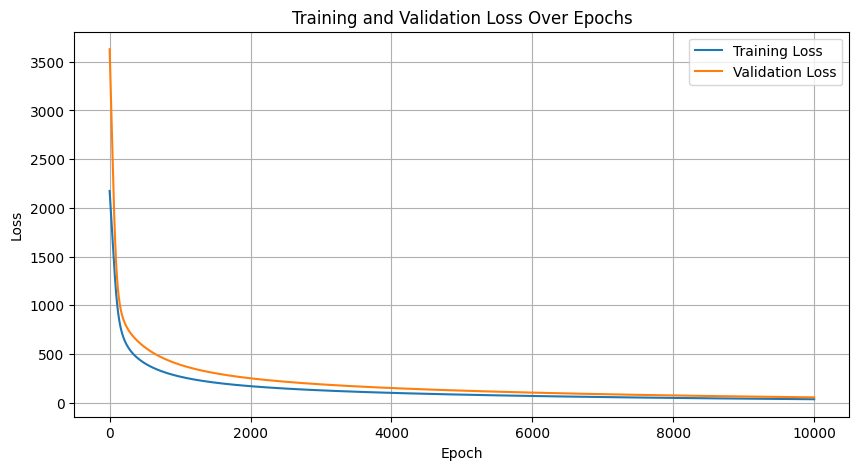


Iteration 38. Best of DGPR: 0.0. GPR model: Train loss = 56.138614654541016; Val. loss = 36.960350036621094
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.00182864   ###   (  25% completed ): Elapsed time 00:00:05 -- Reamining time 00:00:15 -- Predicted time 00:00:20
Best =          -0.00182864   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00182865   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 39 of 100
Best Loss: 24.83550262451172 at epoch 9999. Training loss: 43.9773063659668 and val. loss: 24.83550262451172


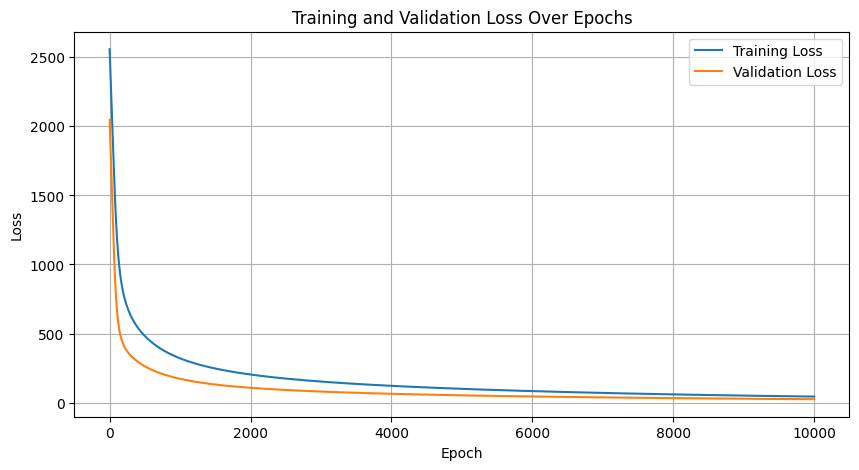


Iteration 39. Best of DGPR: 0.0. GPR model: Train loss = 24.83550262451172; Val. loss = 43.9773063659668
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.00113821   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00113821   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00113821   ###   (  75% completed ): Elapsed time 00:00:22 -- Reamining time 00:00:07 -- Predicted time 00:00:30
Iteration 40 of 100
Best Loss: 13.798347473144531 at epoch 9999. Training loss: 46.0718994140625 and val. loss: 13.798347473144531


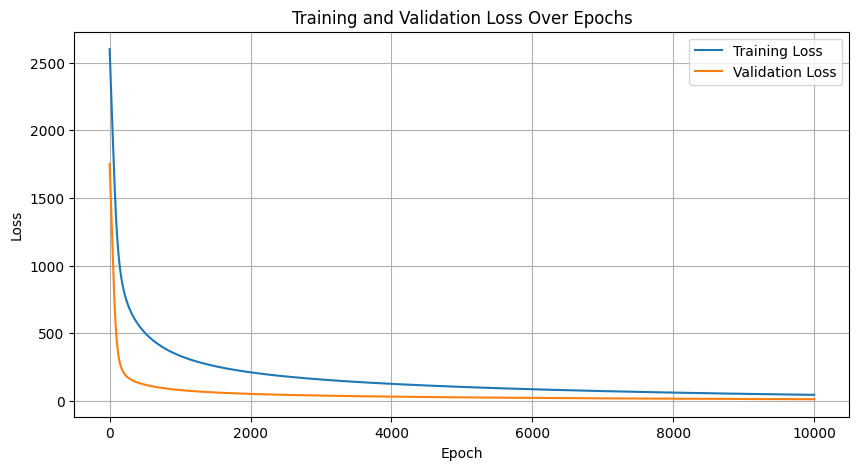


Iteration 40. Best of DGPR: 0.0. GPR model: Train loss = 13.798347473144531; Val. loss = 46.0718994140625
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:01:00 -- Predicted time 00:01:00
Best =          -0.00230845   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00230845   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00230845   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 41 of 100
Best Loss: 27.996768951416016 at epoch 9999. Training loss: 42.88424301147461 and val. loss: 27.996768951416016


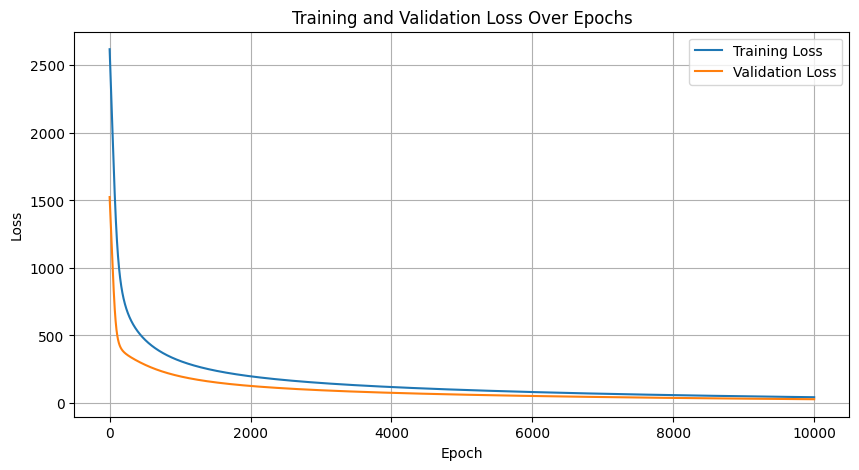


Iteration 41. Best of DGPR: 0.0. GPR model: Train loss = 27.996768951416016; Val. loss = 42.88424301147461
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.00011916   ###   (  25% completed ): Elapsed time 00:00:12 -- Reamining time 00:00:37 -- Predicted time 00:00:50
Best =          -0.00011917   ###   (  50% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:15 -- Predicted time 00:00:30
Best =          -0.00011917   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 42 of 100
Best Loss: 19.95020294189453 at epoch 9999. Training loss: 44.283939361572266 and val. loss: 19.95020294189453


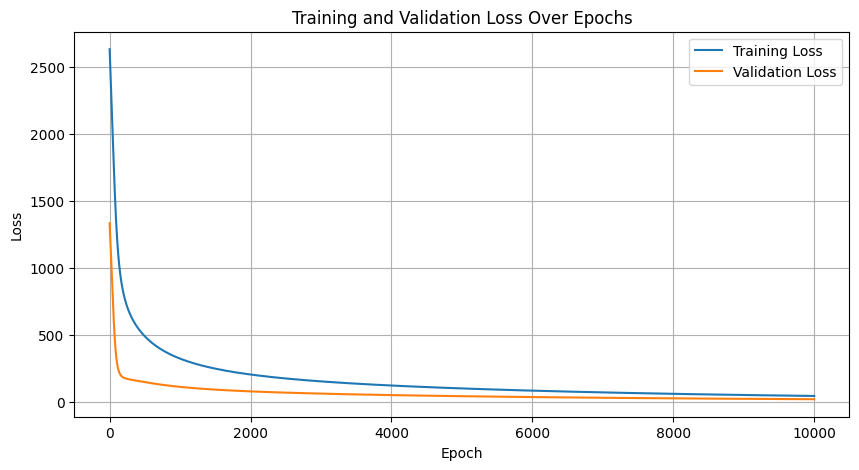


Iteration 42. Best of DGPR: 0.0. GPR model: Train loss = 19.95020294189453; Val. loss = 44.283939361572266
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.00795541   ###   (  25% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:45 -- Predicted time 00:01:00
Best =          -0.00795541   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00795541   ###   (  75% completed ): Elapsed time 00:00:37 -- Reamining time 00:00:12 -- Predicted time 00:00:50
Iteration 43 of 100
Best Loss: 26.429462432861328 at epoch 9999. Training loss: 40.72873306274414 and val. loss: 26.429462432861328


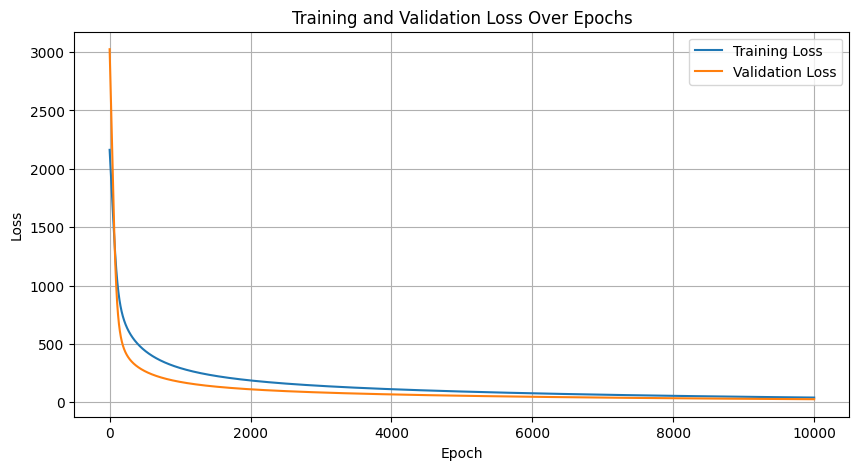


Iteration 43. Best of DGPR: 0.0. GPR model: Train loss = 26.429462432861328; Val. loss = 40.72873306274414
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:50 -- Predicted time 00:00:50
Best =          -0.04626921   ###   (  25% completed ): Elapsed time 00:00:05 -- Reamining time 00:00:15 -- Predicted time 00:00:20
Best =          -0.04626921   ###   (  50% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:15 -- Predicted time 00:00:30
Best =          -0.04626921   ###   (  75% completed ): Elapsed time 00:00:45 -- Reamining time 00:00:15 -- Predicted time 00:01:00
Iteration 44 of 100
Best Loss: 19.72060775756836 at epoch 9999. Training loss: 43.49503707885742 and val. loss: 19.72060775756836


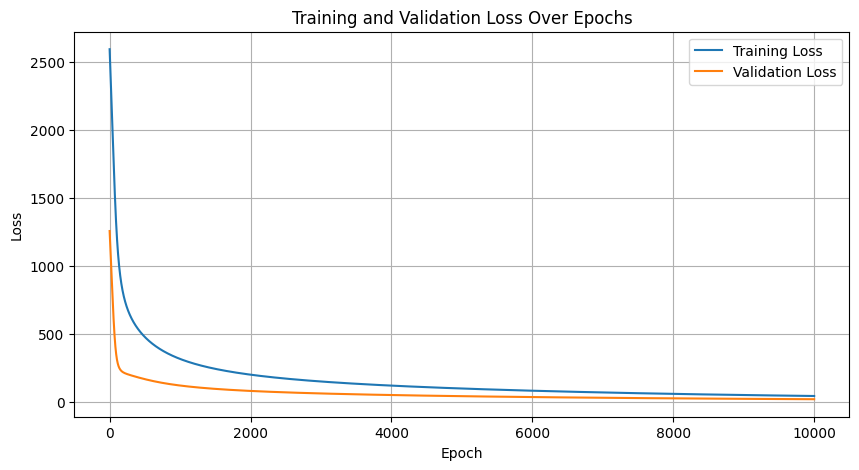


Iteration 44. Best of DGPR: 0.0. GPR model: Train loss = 19.72060775756836; Val. loss = 43.49503707885742
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.00414267   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00414267   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00414267   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 45 of 100
Best Loss: 20.56839370727539 at epoch 9999. Training loss: 42.78599548339844 and val. loss: 20.56839370727539


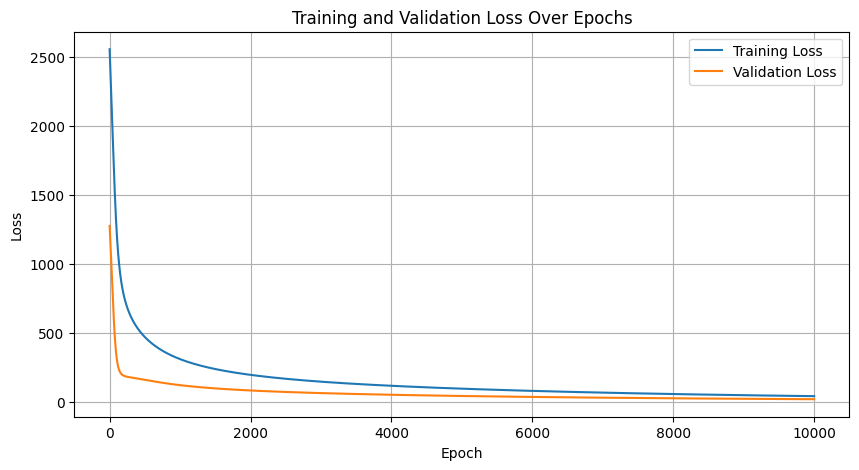


Iteration 45. Best of DGPR: 0.0. GPR model: Train loss = 20.56839370727539; Val. loss = 42.78599548339844
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:50 -- Predicted time 00:00:50
Best =          -0.00398754   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00398754   ###   (  50% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:30 -- Predicted time 00:01:00
Best =          -0.00398754   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 46 of 100
Best Loss: 43.24237823486328 at epoch 9999. Training loss: 37.173831939697266 and val. loss: 43.24237823486328


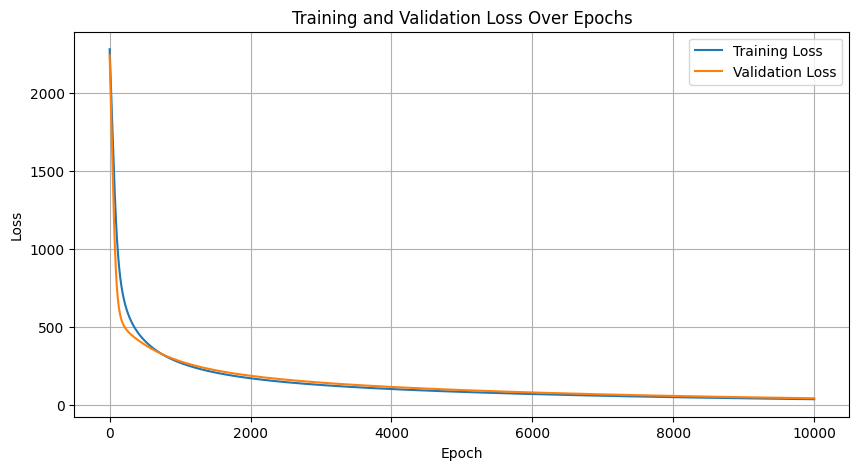


Iteration 46. Best of DGPR: 0.0. GPR model: Train loss = 43.24237823486328; Val. loss = 37.173831939697266
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.02387320   ###   (  25% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:45 -- Predicted time 00:01:00
Best =          -0.02387320   ###   (  50% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:30 -- Predicted time 00:01:00
Best =          -0.02387320   ###   (  75% completed ): Elapsed time 00:00:22 -- Reamining time 00:00:07 -- Predicted time 00:00:30
Iteration 47 of 100
Best Loss: 24.89567756652832 at epoch 9999. Training loss: 39.868370056152344 and val. loss: 24.89567756652832


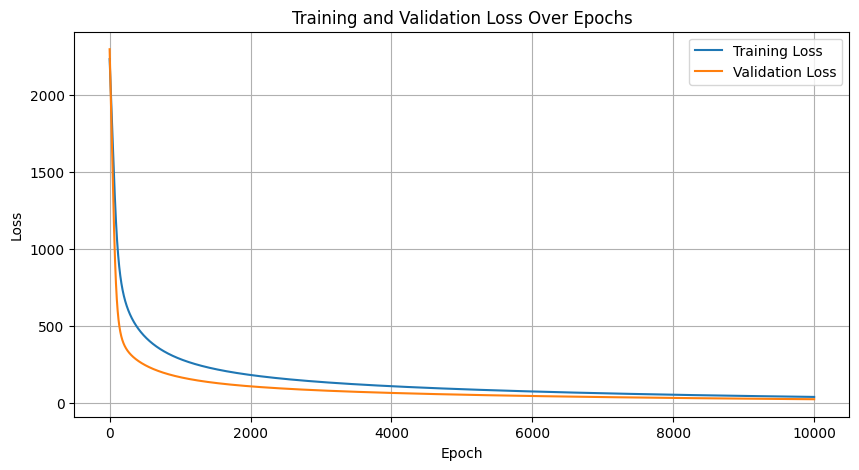


Iteration 47. Best of DGPR: 0.0. GPR model: Train loss = 24.89567756652832; Val. loss = 39.868370056152344
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:01:00 -- Predicted time 00:01:00
Best =          -0.01400833   ###   (  25% completed ): Elapsed time 00:00:11 -- Reamining time 00:00:34 -- Predicted time 00:00:46
Best =          -0.01400833   ###   (  50% completed ): Elapsed time 00:00:09 -- Reamining time 00:00:09 -- Predicted time 00:00:19
Best =          -0.01400833   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 48 of 100
Best Loss: 29.990009307861328 at epoch 9999. Training loss: 38.39344024658203 and val. loss: 29.990009307861328


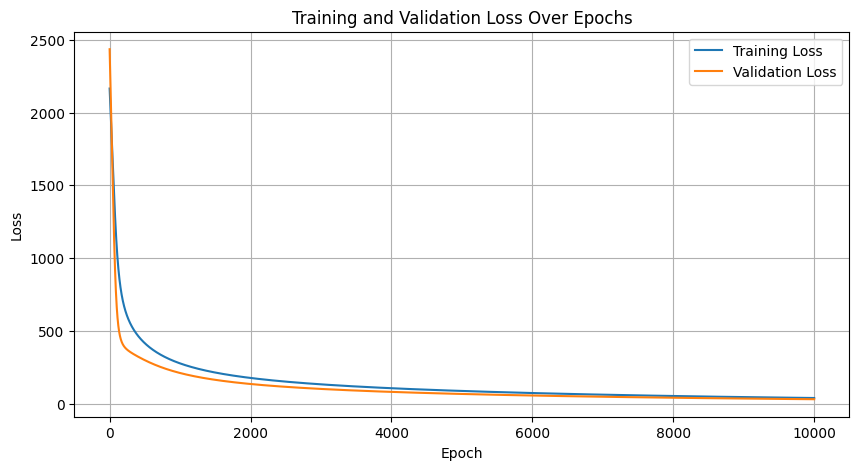


Iteration 48. Best of DGPR: 0.0. GPR model: Train loss = 29.990009307861328; Val. loss = 38.39344024658203
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.02194178   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:32 -- Predicted time 00:00:42
Best =          -0.02194178   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.02194187   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 49 of 100
Best Loss: 17.159664154052734 at epoch 9999. Training loss: 40.981815338134766 and val. loss: 17.159664154052734


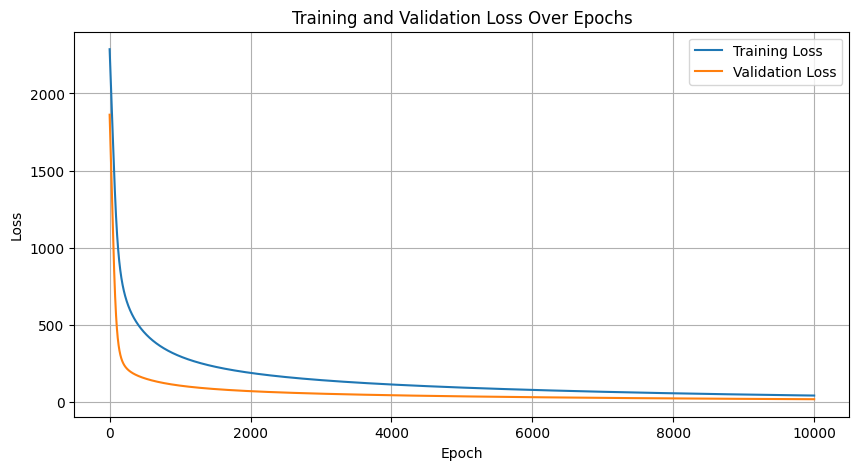


Iteration 49. Best of DGPR: 0.0. GPR model: Train loss = 17.159664154052734; Val. loss = 40.981815338134766
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:50 -- Predicted time 00:00:50
Best =          -0.00153528   ###   (  25% completed ): Elapsed time 00:00:12 -- Reamining time 00:00:37 -- Predicted time 00:00:50
Best =          -0.00153528   ###   (  50% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:10 -- Predicted time 00:00:20
Best =          -0.00153530   ###   (  75% completed ): Elapsed time 00:00:45 -- Reamining time 00:00:15 -- Predicted time 00:01:00
Iteration 50 of 100
Best Loss: 24.60294532775879 at epoch 9999. Training loss: 39.015892028808594 and val. loss: 24.60294532775879


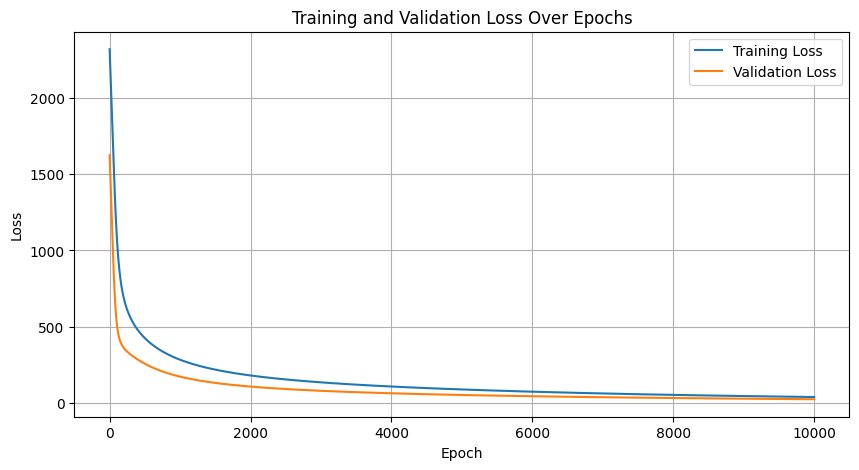


Iteration 50. Best of DGPR: 0.0. GPR model: Train loss = 24.60294532775879; Val. loss = 39.015892028808594
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:01:10 -- Predicted time 00:01:10
Best =          -0.07082220   ###   (  25% completed ): Elapsed time 00:00:07 -- Reamining time 00:00:22 -- Predicted time 00:00:30
Best =          -0.07082220   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.07082220   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 51 of 100
Best Loss: 36.17491912841797 at epoch 9999. Training loss: 35.46854782104492 and val. loss: 36.17491912841797


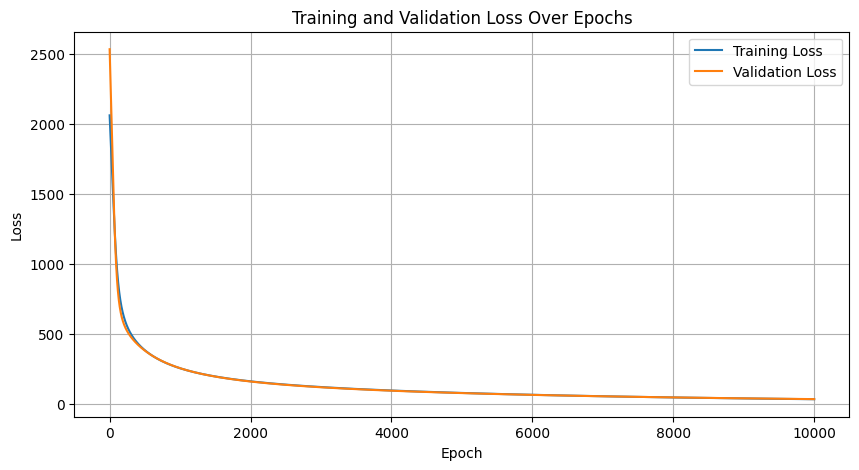


Iteration 51. Best of DGPR: 0.0. GPR model: Train loss = 36.17491912841797; Val. loss = 35.46854782104492
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.03989504   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.03989504   ###   (  50% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:10 -- Predicted time 00:00:20
Best =          -0.03989504   ###   (  75% completed ): Elapsed time 00:00:22 -- Reamining time 00:00:07 -- Predicted time 00:00:30
Iteration 52 of 100
Best Loss: 17.0327205657959 at epoch 9999. Training loss: 39.39535140991211 and val. loss: 17.0327205657959


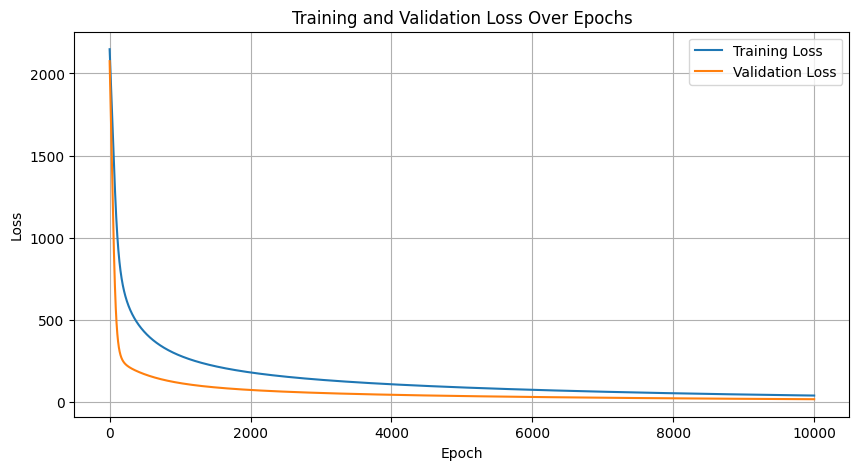


Iteration 52. Best of DGPR: 0.0. GPR model: Train loss = 17.0327205657959; Val. loss = 39.39535140991211
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.02043878   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.02043878   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.02043885   ###   (  75% completed ): Elapsed time 00:00:22 -- Reamining time 00:00:07 -- Predicted time 00:00:30
Iteration 53 of 100
Best Loss: 20.54888343811035 at epoch 9999. Training loss: 38.54244613647461 and val. loss: 20.54888343811035


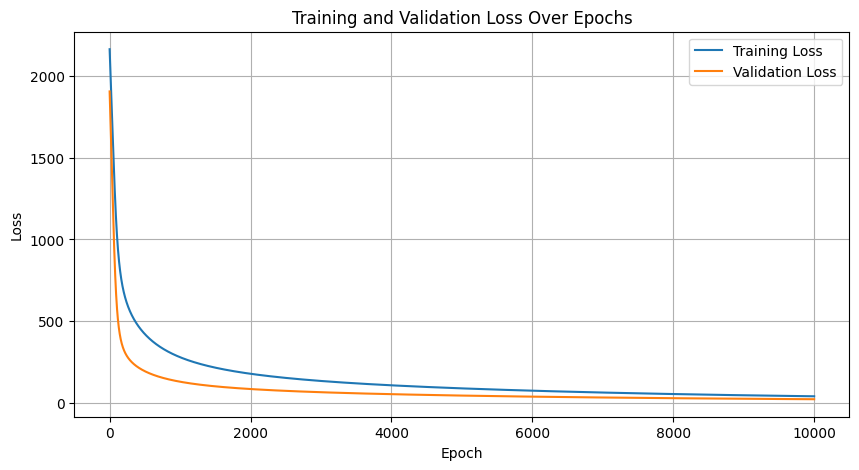


Iteration 53. Best of DGPR: 0.0. GPR model: Train loss = 20.54888343811035; Val. loss = 38.54244613647461
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:39 -- Predicted time 00:00:39
Best =          -0.00832487   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00832490   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00832490   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 54 of 100
Best Loss: 31.373825073242188 at epoch 9999. Training loss: 35.45936584472656 and val. loss: 31.373825073242188


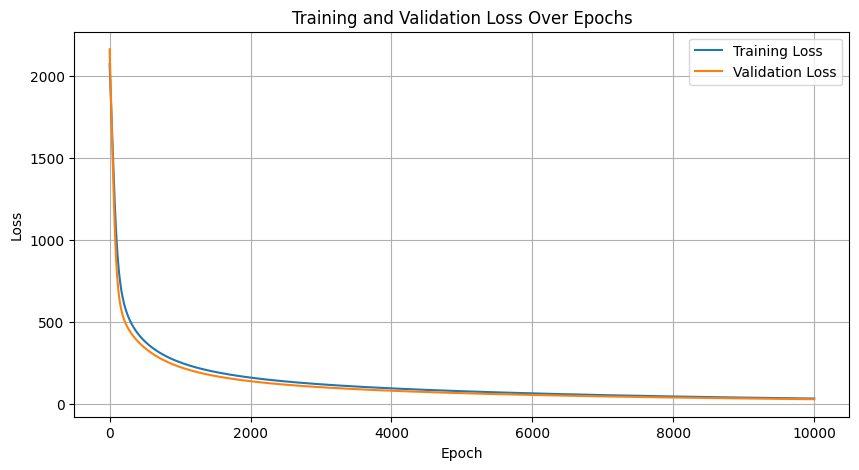


Iteration 54. Best of DGPR: 0.0. GPR model: Train loss = 31.373825073242188; Val. loss = 35.45936584472656
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:50 -- Predicted time 00:00:50
Best =          -0.13736127   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.13736165   ###   (  50% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:10 -- Predicted time 00:00:20
Best =          -0.13736165   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 55 of 100
Best Loss: 27.510032653808594 at epoch 9999. Training loss: 36.02083969116211 and val. loss: 27.510032653808594


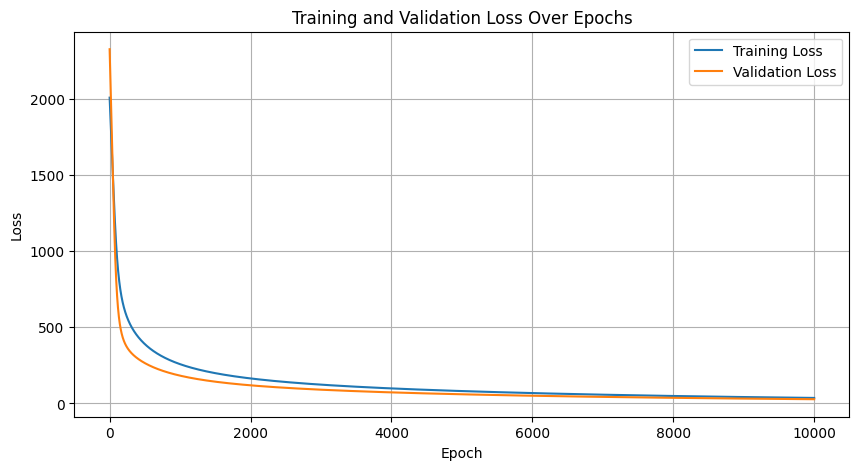


Iteration 55. Best of DGPR: 0.0. GPR model: Train loss = 27.510032653808594; Val. loss = 36.02083969116211
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.00866909   ###   (  25% completed ): Elapsed time 00:00:07 -- Reamining time 00:00:22 -- Predicted time 00:00:30
Best =          -0.00866909   ###   (  50% completed ): Elapsed time 00:00:19 -- Reamining time 00:00:19 -- Predicted time 00:00:39
Best =          -0.00866909   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 56 of 100
Best Loss: 11.995572090148926 at epoch 9999. Training loss: 39.842979431152344 and val. loss: 11.995572090148926


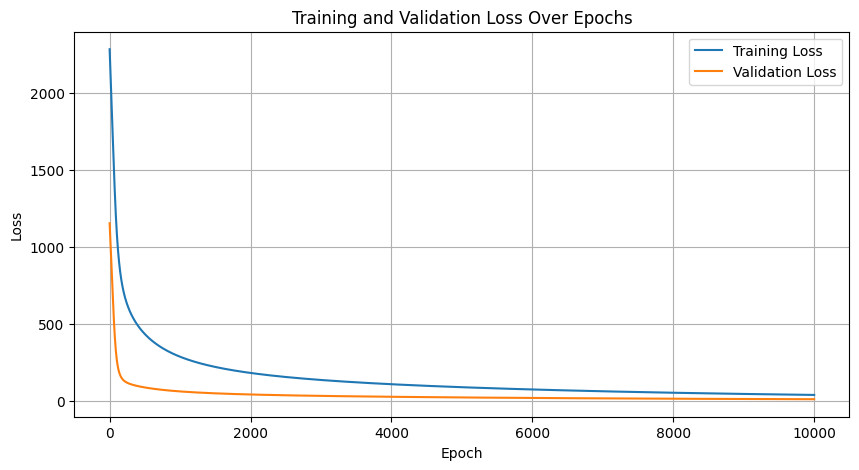


Iteration 56. Best of DGPR: 0.0. GPR model: Train loss = 11.995572090148926; Val. loss = 39.842979431152344
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:20 -- Predicted time 00:00:20
Best =          -0.01294563   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.01294563   ###   (  50% completed ): Elapsed time 00:00:21 -- Reamining time 00:00:21 -- Predicted time 00:00:42
Best =          -0.01294577   ###   (  75% completed ): Elapsed time 00:00:45 -- Reamining time 00:00:15 -- Predicted time 00:01:00
Iteration 57 of 100
Best Loss: 45.36753463745117 at epoch 9999. Training loss: 31.755916595458984 and val. loss: 45.36753463745117


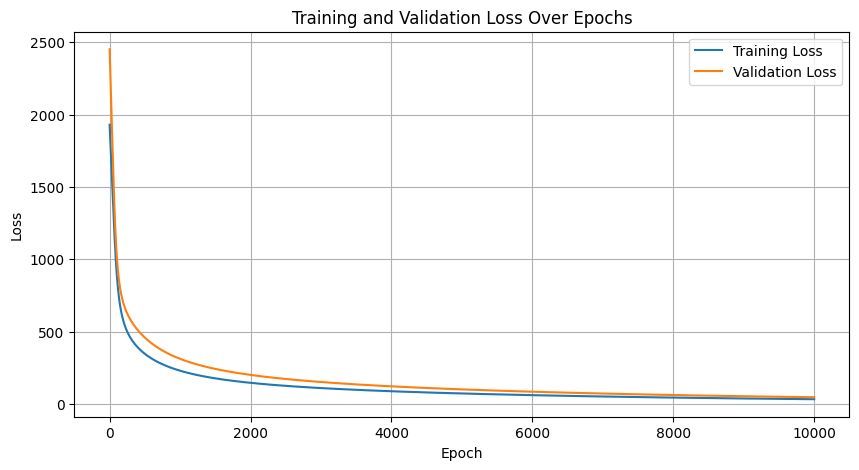


Iteration 57. Best of DGPR: 0.0. GPR model: Train loss = 45.36753463745117; Val. loss = 31.755916595458984
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.00374420   ###   (  25% completed ): Elapsed time 00:00:05 -- Reamining time 00:00:15 -- Predicted time 00:00:20
Best =          -0.00374420   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00374420   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 58 of 100
Best Loss: 21.360593795776367 at epoch 9999. Training loss: 37.23374938964844 and val. loss: 21.360593795776367


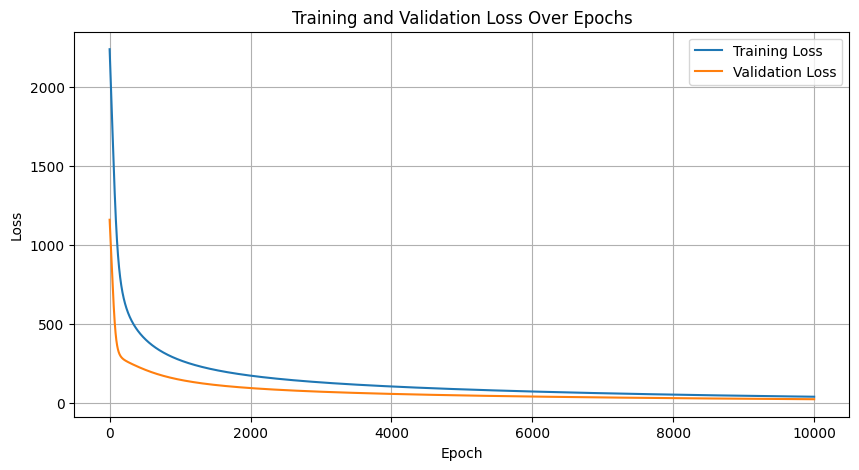


Iteration 58. Best of DGPR: 0.0. GPR model: Train loss = 21.360593795776367; Val. loss = 37.23374938964844
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:01:10 -- Predicted time 00:01:10
Best =          -0.00141181   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00141183   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00141183   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 59 of 100
Best Loss: 48.73714828491211 at epoch 9999. Training loss: 30.70520782470703 and val. loss: 48.73714828491211


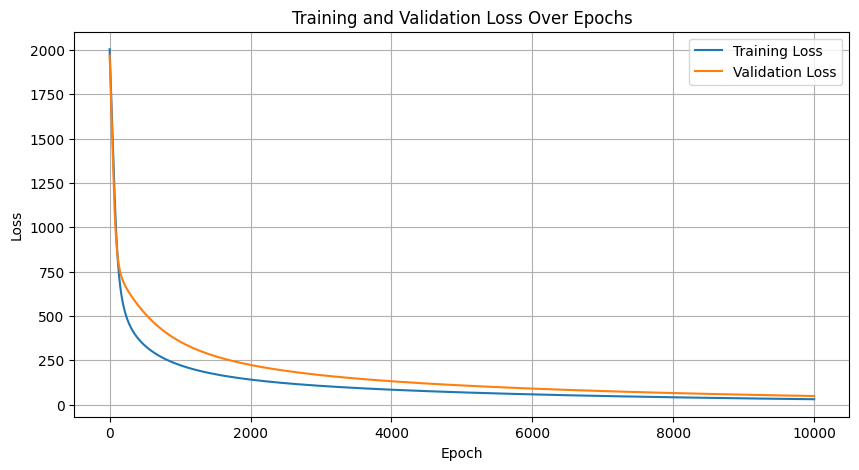


Iteration 59. Best of DGPR: 0.0. GPR model: Train loss = 48.73714828491211; Val. loss = 30.70520782470703
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:20 -- Predicted time 00:00:20
Best =          -0.00400192   ###   (  25% completed ): Elapsed time 00:00:09 -- Reamining time 00:00:29 -- Predicted time 00:00:39
Best =          -0.00400192   ###   (  50% completed ): Elapsed time 00:00:09 -- Reamining time 00:00:09 -- Predicted time 00:00:19
Best =          -0.00400192   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 60 of 100
Best Loss: 29.861957550048828 at epoch 9999. Training loss: 33.769779205322266 and val. loss: 29.861957550048828


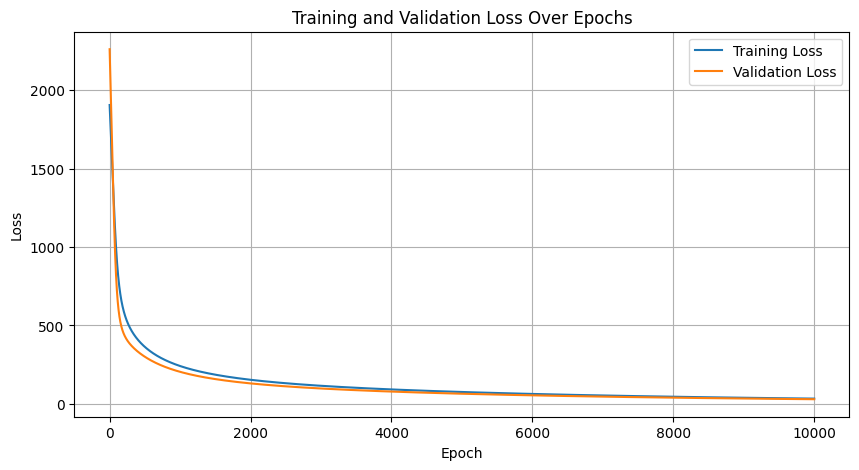


Iteration 60. Best of DGPR: 0.0. GPR model: Train loss = 29.861957550048828; Val. loss = 33.769779205322266
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:20 -- Predicted time 00:00:20
Best =          -0.01101908   ###   (  25% completed ): Elapsed time 00:00:12 -- Reamining time 00:00:37 -- Predicted time 00:00:50
Best =          -0.01101908   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.01101908   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 61 of 100
Best Loss: 39.687965393066406 at epoch 9999. Training loss: 31.590045928955078 and val. loss: 39.687965393066406


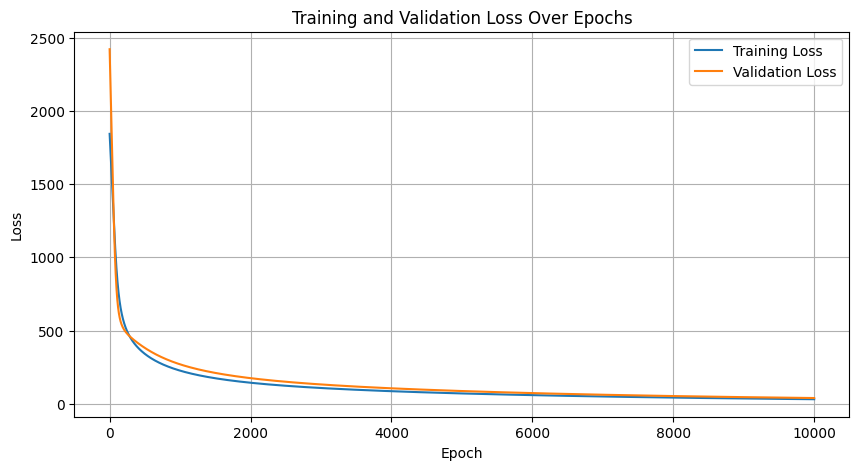


Iteration 61. Best of DGPR: 0.0. GPR model: Train loss = 39.687965393066406; Val. loss = 31.590045928955078
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:50 -- Predicted time 00:00:50
Best =          -0.00934951   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00934951   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00934951   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 62 of 100
Best Loss: 25.967485427856445 at epoch 9999. Training loss: 33.997859954833984 and val. loss: 25.967485427856445


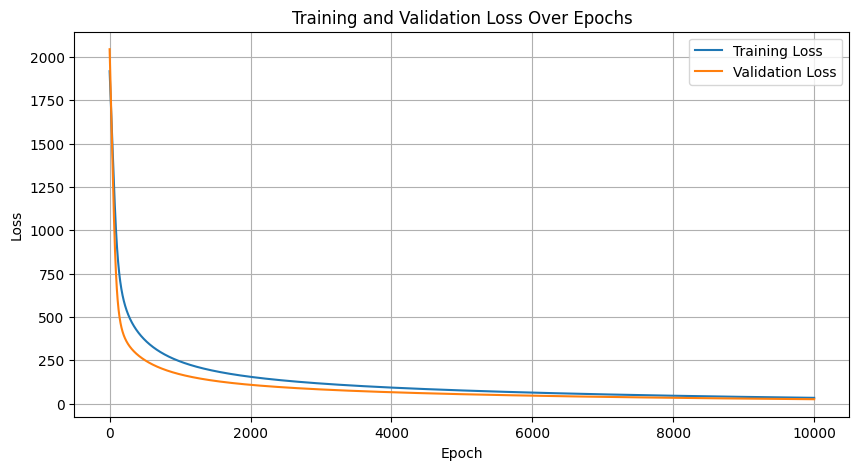


Iteration 62. Best of DGPR: 0.0. GPR model: Train loss = 25.967485427856445; Val. loss = 33.997859954833984
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.00986219   ###   (  25% completed ): Elapsed time 00:00:12 -- Reamining time 00:00:37 -- Predicted time 00:00:50
Best =          -0.00986219   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00986220   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 63 of 100
Best Loss: 29.908130645751953 at epoch 9999. Training loss: 33.429508209228516 and val. loss: 29.908130645751953


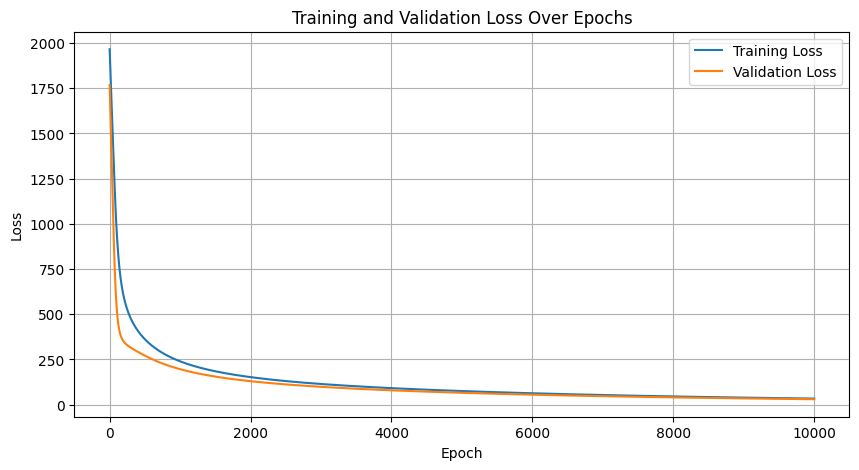


Iteration 63. Best of DGPR: 0.0. GPR model: Train loss = 29.908130645751953; Val. loss = 33.429508209228516
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:20 -- Predicted time 00:00:20
Best =          -0.00789744   ###   (  25% completed ): Elapsed time 00:00:07 -- Reamining time 00:00:22 -- Predicted time 00:00:30
Best =          -0.00789744   ###   (  50% completed ): Elapsed time 00:00:05 -- Reamining time 00:00:05 -- Predicted time 00:00:10
Best =          -0.00789744   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 64 of 100
Best Loss: 36.136104583740234 at epoch 9999. Training loss: 31.73719024658203 and val. loss: 36.136104583740234


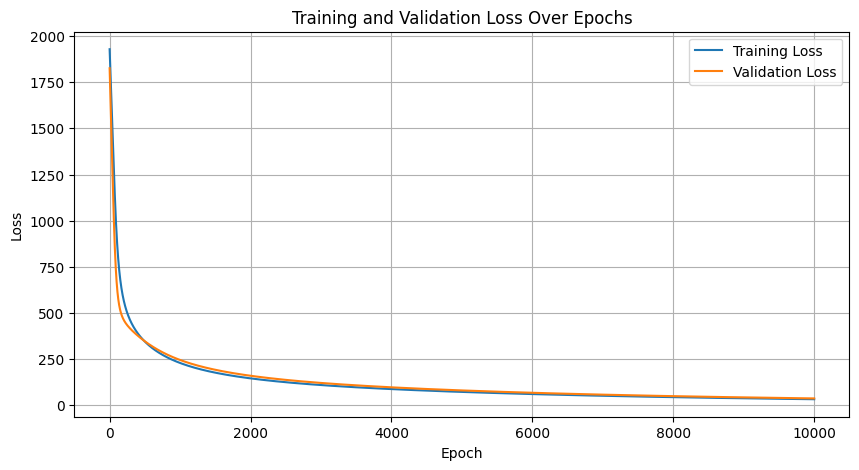


Iteration 64. Best of DGPR: 0.0. GPR model: Train loss = 36.136104583740234; Val. loss = 31.73719024658203
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.00106165   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00106165   ###   (  50% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:10 -- Predicted time 00:00:20
Best =          -0.00106165   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 65 of 100
Best Loss: 53.076805114746094 at epoch 9999. Training loss: 26.97870635986328 and val. loss: 53.076805114746094


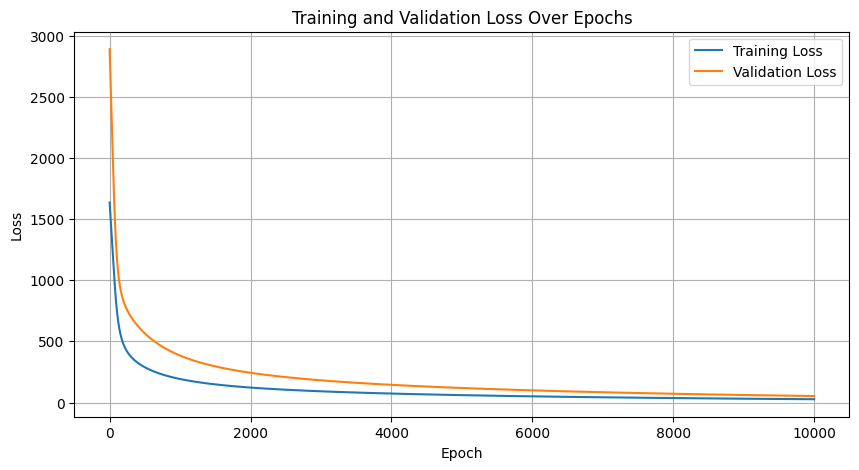


Iteration 65. Best of DGPR: 0.0. GPR model: Train loss = 53.076805114746094; Val. loss = 26.97870635986328
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:20 -- Predicted time 00:00:20
Best =          -0.01767332   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.01767336   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.01767336   ###   (  75% completed ): Elapsed time 00:00:37 -- Reamining time 00:00:12 -- Predicted time 00:00:50
Iteration 66 of 100
Best Loss: 25.13985252380371 at epoch 9999. Training loss: 33.54374313354492 and val. loss: 25.13985252380371


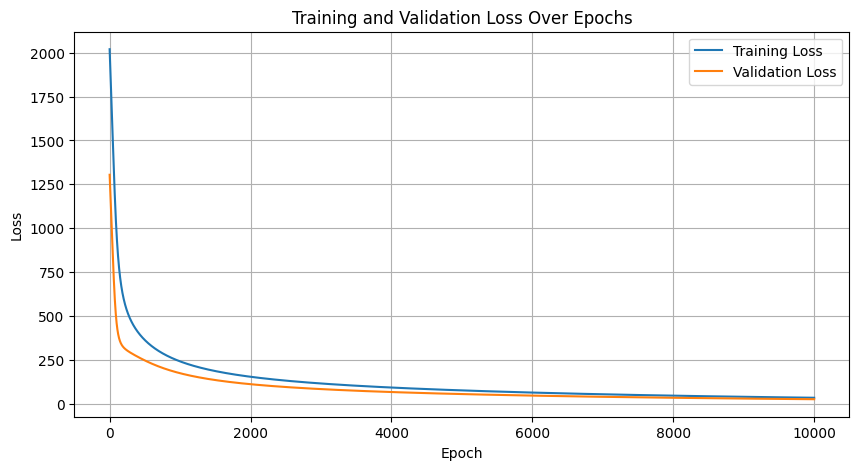


Iteration 66. Best of DGPR: 0.0. GPR model: Train loss = 25.13985252380371; Val. loss = 33.54374313354492
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:50 -- Predicted time 00:00:50
Best =          -0.00978348   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00978352   ###   (  50% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:30 -- Predicted time 00:01:00
Best =          -0.00978360   ###   (  75% completed ): Elapsed time 00:00:22 -- Reamining time 00:00:07 -- Predicted time 00:00:30
Iteration 67 of 100
Best Loss: 29.25202751159668 at epoch 9999. Training loss: 32.592872619628906 and val. loss: 29.25202751159668


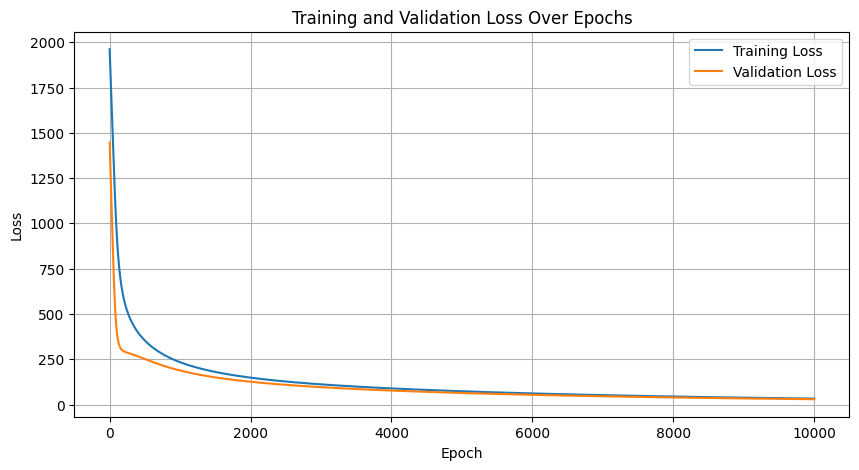


Iteration 67. Best of DGPR: 0.0. GPR model: Train loss = 29.25202751159668; Val. loss = 32.592872619628906
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:20 -- Predicted time 00:00:20
Best =          -0.00698543   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00698543   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00698543   ###   (  75% completed ): Elapsed time 00:00:37 -- Reamining time 00:00:12 -- Predicted time 00:00:50
Iteration 68 of 100
Best Loss: 56.42905044555664 at epoch 9999. Training loss: 26.141956329345703 and val. loss: 56.42905044555664


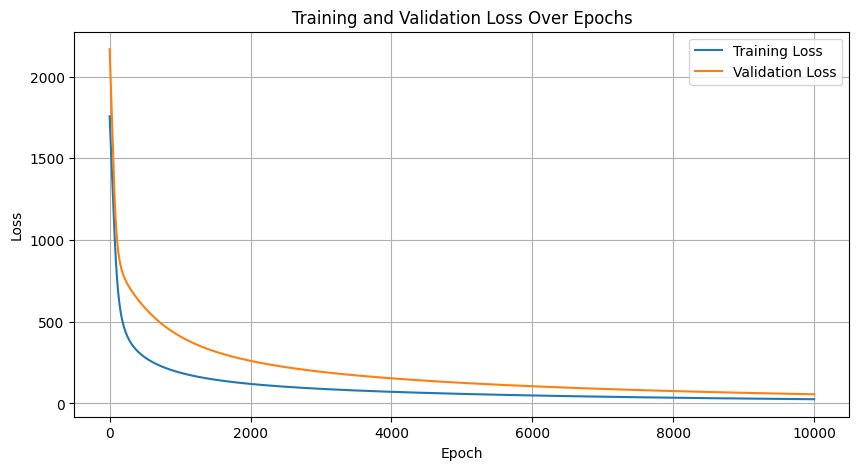


Iteration 68. Best of DGPR: 0.0. GPR model: Train loss = 56.42905044555664; Val. loss = 26.141956329345703
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:30 -- Predicted time 00:00:30
Best =          -0.00297630   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00297630   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00297630   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 69 of 100
Best Loss: 14.863365173339844 at epoch 9999. Training loss: 35.294193267822266 and val. loss: 14.863365173339844


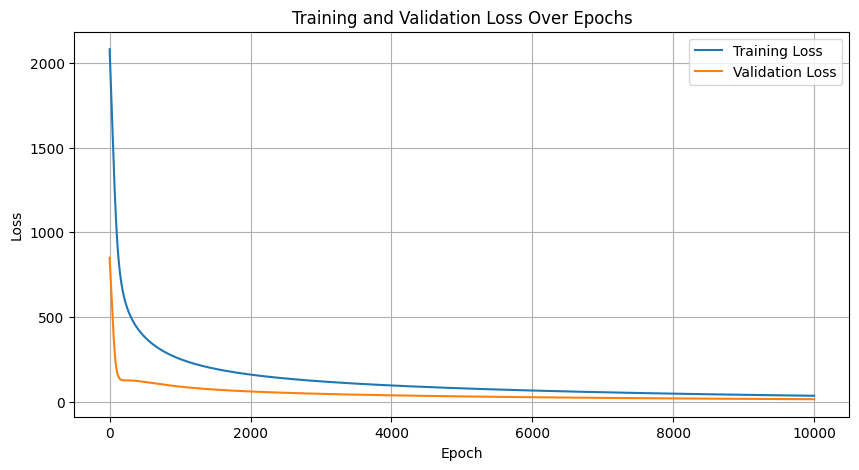


Iteration 69. Best of DGPR: 0.0. GPR model: Train loss = 14.863365173339844; Val. loss = 35.294193267822266
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:20 -- Predicted time 00:00:20
Best =          -0.00958329   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00958329   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00958332   ###   (  75% completed ): Elapsed time 00:00:45 -- Reamining time 00:00:15 -- Predicted time 00:01:00
Iteration 70 of 100
Best Loss: 11.193902015686035 at epoch 9999. Training loss: 35.32408142089844 and val. loss: 11.193902015686035


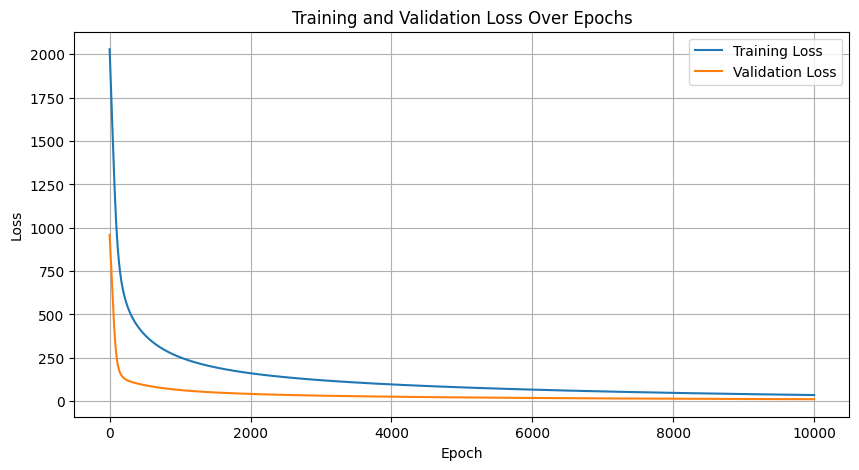


Iteration 70. Best of DGPR: 0.0. GPR model: Train loss = 11.193902015686035; Val. loss = 35.32408142089844
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.03272915   ###   (  25% completed ): Elapsed time 00:00:05 -- Reamining time 00:00:15 -- Predicted time 00:00:20
Best =          -0.03272939   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.03272939   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 71 of 100
Best Loss: 20.610004425048828 at epoch 9999. Training loss: 32.78443908691406 and val. loss: 20.610004425048828


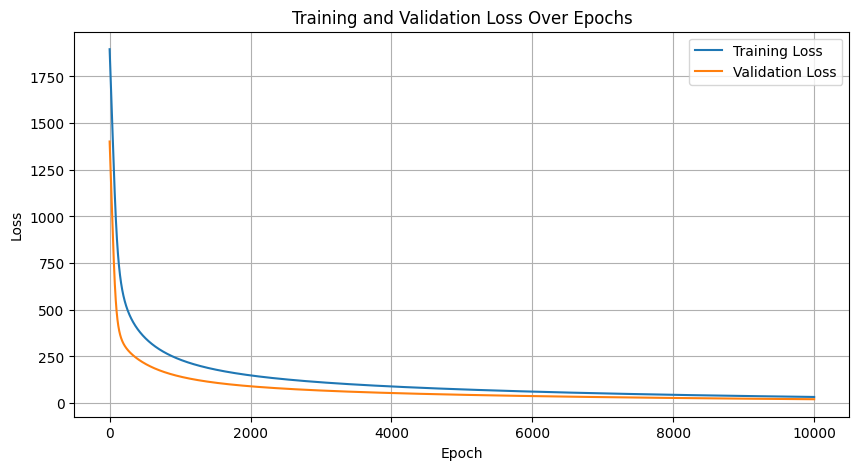


Iteration 71. Best of DGPR: 0.0. GPR model: Train loss = 20.610004425048828; Val. loss = 32.78443908691406
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:01:10 -- Predicted time 00:01:10
Best =          -0.00336803   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00336804   ###   (  50% completed ): Elapsed time 00:00:31 -- Reamining time 00:00:31 -- Predicted time 00:01:03
Best =          -0.00336804   ###   (  75% completed ): Elapsed time 00:00:14 -- Reamining time 00:00:04 -- Predicted time 00:00:19
Iteration 72 of 100
Best Loss: 23.8475399017334 at epoch 9999. Training loss: 32.1234130859375 and val. loss: 23.8475399017334


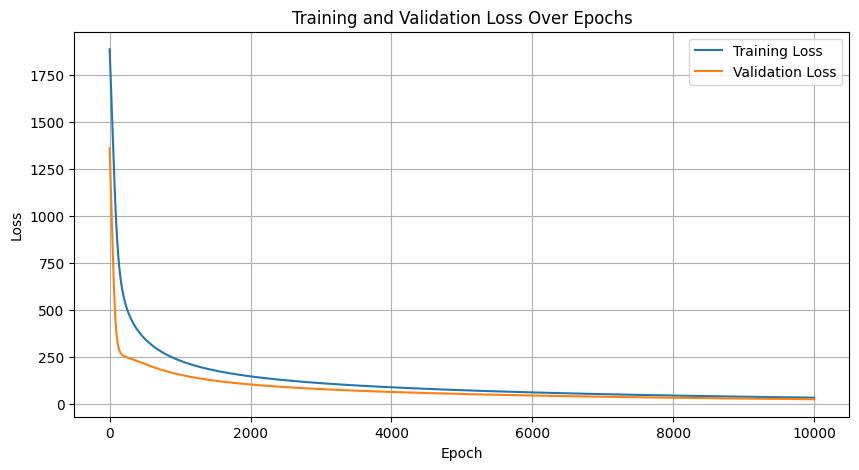


Iteration 72. Best of DGPR: 0.0. GPR model: Train loss = 23.8475399017334; Val. loss = 32.1234130859375
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:50 -- Predicted time 00:00:50
Best =          -0.03859519   ###   (  25% completed ): Elapsed time 00:00:12 -- Reamining time 00:00:37 -- Predicted time 00:00:50
Best =          -0.03859524   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.03859524   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 73 of 100
Best Loss: 29.56194496154785 at epoch 9999. Training loss: 30.83423614501953 and val. loss: 29.56194496154785


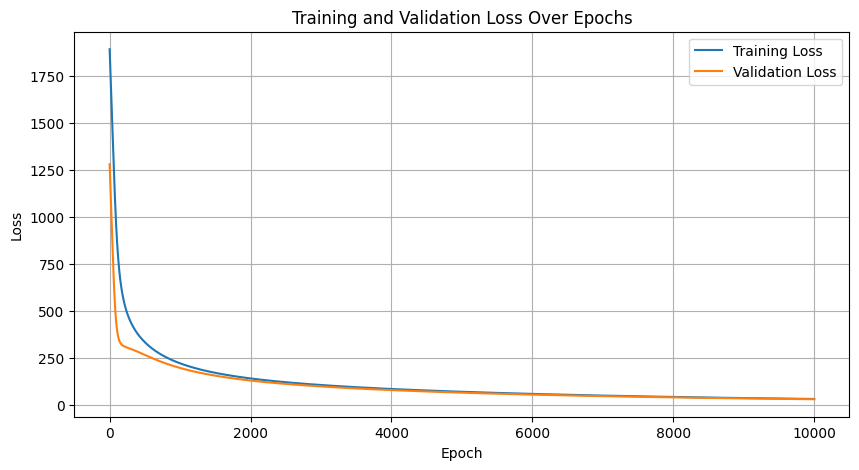


Iteration 73. Best of DGPR: 0.0. GPR model: Train loss = 29.56194496154785; Val. loss = 30.83423614501953
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.01018024   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.01018024   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.01018024   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 74 of 100
Best Loss: 21.170621871948242 at epoch 9999. Training loss: 31.742794036865234 and val. loss: 21.170621871948242


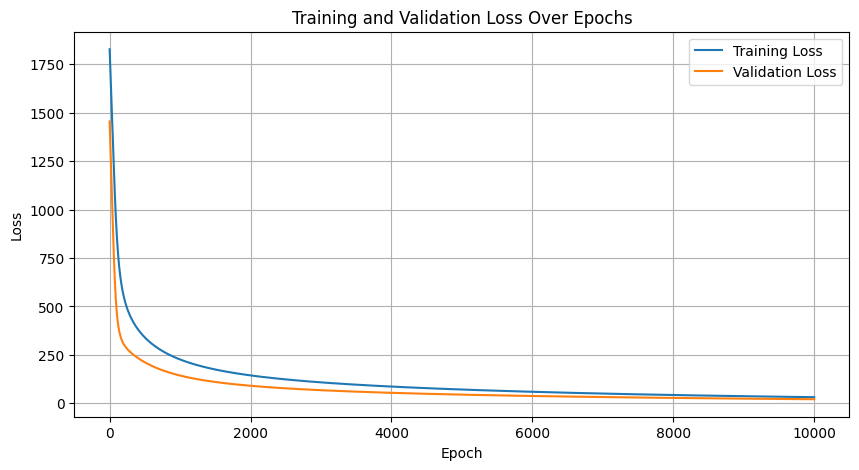


Iteration 74. Best of DGPR: 0.0. GPR model: Train loss = 21.170621871948242; Val. loss = 31.742794036865234
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.01562060   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.01562060   ###   (  50% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:30 -- Predicted time 00:01:00
Best =          -0.01562081   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 75 of 100
Best Loss: 16.751163482666016 at epoch 9999. Training loss: 32.34331512451172 and val. loss: 16.751163482666016


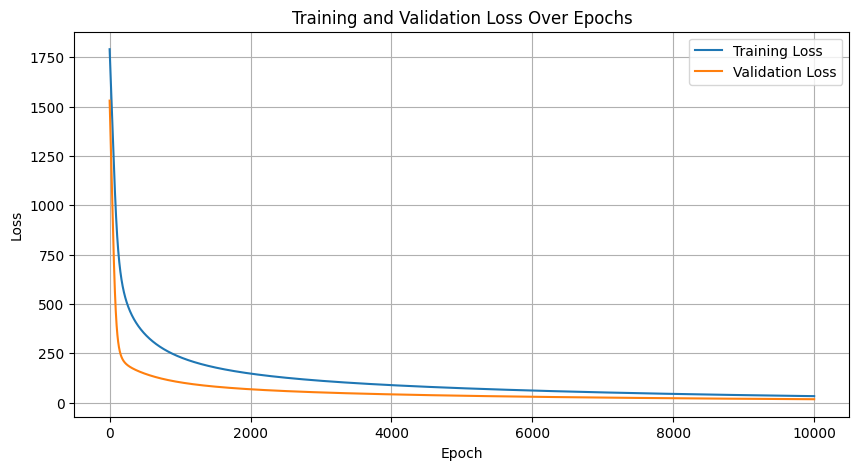


Iteration 75. Best of DGPR: 0.0. GPR model: Train loss = 16.751163482666016; Val. loss = 32.34331512451172
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:50 -- Predicted time 00:00:50
Best =          -0.01647950   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.01647950   ###   (  50% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:30 -- Predicted time 00:01:00
Best =          -0.01647950   ###   (  75% completed ): Elapsed time 00:00:37 -- Reamining time 00:00:12 -- Predicted time 00:00:50
Iteration 76 of 100
Best Loss: 47.94721221923828 at epoch 9999. Training loss: 25.475366592407227 and val. loss: 47.94721221923828


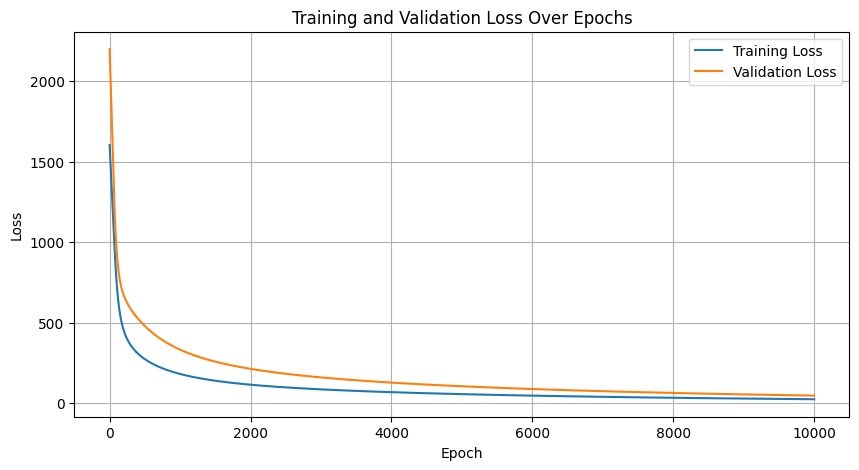


Iteration 76. Best of DGPR: 0.0. GPR model: Train loss = 47.94721221923828; Val. loss = 25.475366592407227
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:50 -- Predicted time 00:00:50
Best =          -0.01904869   ###   (  25% completed ): Elapsed time 00:00:07 -- Reamining time 00:00:22 -- Predicted time 00:00:30
Best =          -0.01904869   ###   (  50% completed ): Elapsed time 00:00:25 -- Reamining time 00:00:25 -- Predicted time 00:00:50
Best =          -0.01904869   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 77 of 100
Best Loss: 27.543235778808594 at epoch 9999. Training loss: 29.631118774414062 and val. loss: 27.543235778808594


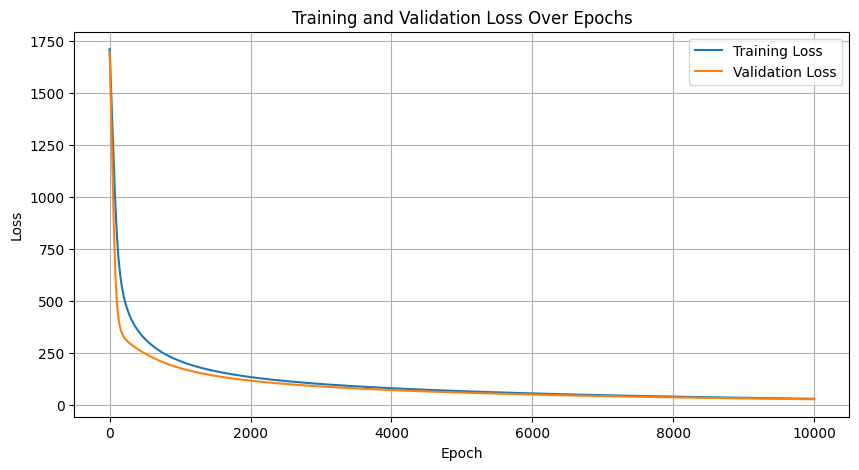


Iteration 77. Best of DGPR: 0.0. GPR model: Train loss = 27.543235778808594; Val. loss = 29.631118774414062
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:30 -- Predicted time 00:00:30
Best =          -0.07505301   ###   (  25% completed ): Elapsed time 00:00:12 -- Reamining time 00:00:37 -- Predicted time 00:00:50
Best =          -0.07505328   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.07505328   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 78 of 100
Best Loss: 36.15650177001953 at epoch 9999. Training loss: 27.907033920288086 and val. loss: 36.15650177001953


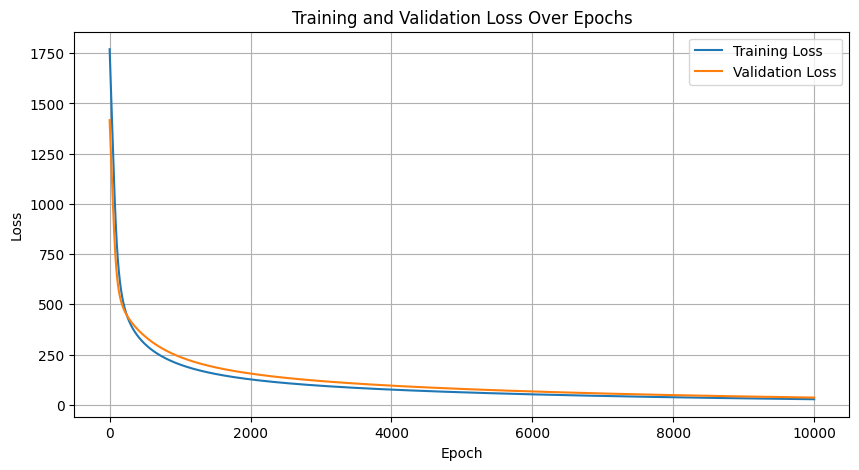


Iteration 78. Best of DGPR: 0.0. GPR model: Train loss = 36.15650177001953; Val. loss = 27.907033920288086
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:44 -- Predicted time 00:00:44
Best =          -0.00950366   ###   (  25% completed ): Elapsed time 00:00:12 -- Reamining time 00:00:37 -- Predicted time 00:00:50
Best =          -0.00950371   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00950371   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 79 of 100
Best Loss: 10.529434204101562 at epoch 9999. Training loss: 33.22386169433594 and val. loss: 10.529434204101562


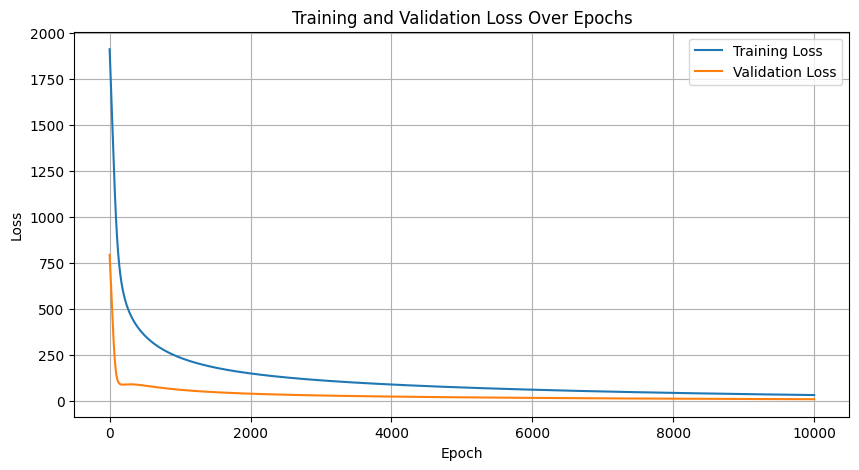


Iteration 79. Best of DGPR: 0.0. GPR model: Train loss = 10.529434204101562; Val. loss = 33.22386169433594
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:01:00 -- Predicted time 00:01:00
Best =          -0.07284107   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.07284121   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.07284121   ###   (  75% completed ): Elapsed time 00:00:22 -- Reamining time 00:00:07 -- Predicted time 00:00:30
Iteration 80 of 100
Best Loss: 24.135936737060547 at epoch 9999. Training loss: 29.372663497924805 and val. loss: 24.135936737060547


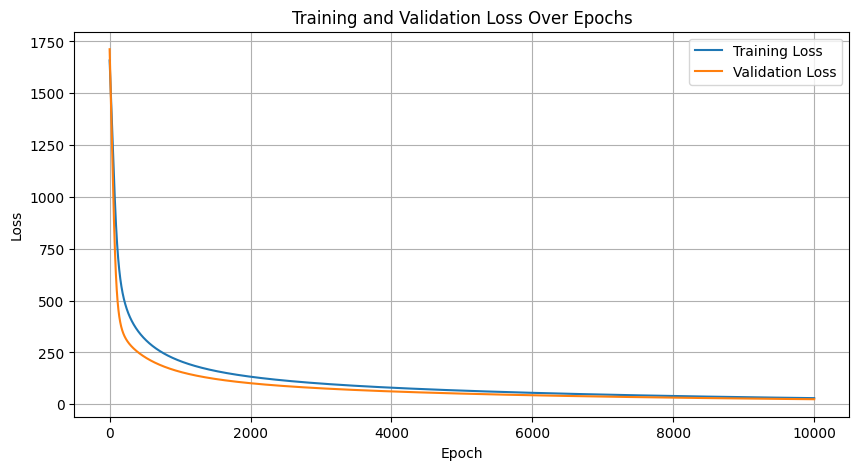


Iteration 80. Best of DGPR: 0.0. GPR model: Train loss = 24.135936737060547; Val. loss = 29.372663497924805
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.02215410   ###   (  25% completed ): Elapsed time 00:00:07 -- Reamining time 00:00:22 -- Predicted time 00:00:30
Best =          -0.02215410   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.02215410   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 81 of 100
Best Loss: 12.167800903320312 at epoch 9999. Training loss: 31.70663070678711 and val. loss: 12.167800903320312


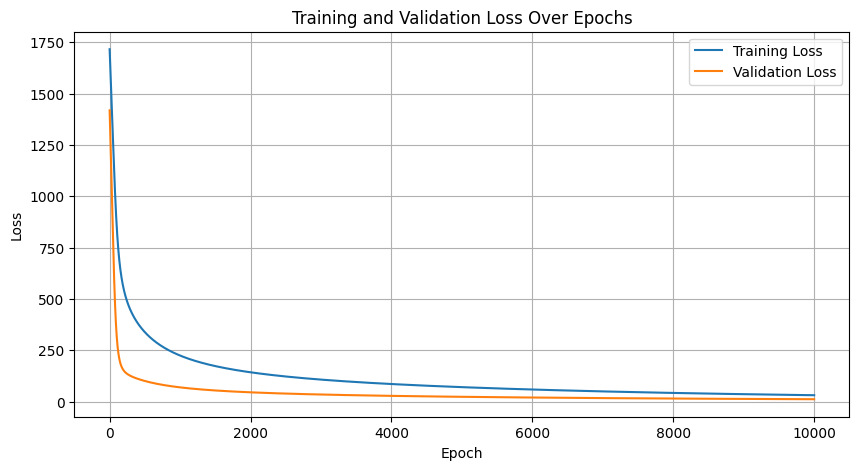


Iteration 81. Best of DGPR: 0.0. GPR model: Train loss = 12.167800903320312; Val. loss = 31.70663070678711
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.02844582   ###   (  25% completed ): Elapsed time 00:00:07 -- Reamining time 00:00:22 -- Predicted time 00:00:30
Best =          -0.02844584   ###   (  50% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:15 -- Predicted time 00:00:30
Best =          -0.02844584   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 82 of 100
Best Loss: 13.201933860778809 at epoch 9999. Training loss: 31.566814422607422 and val. loss: 13.201933860778809


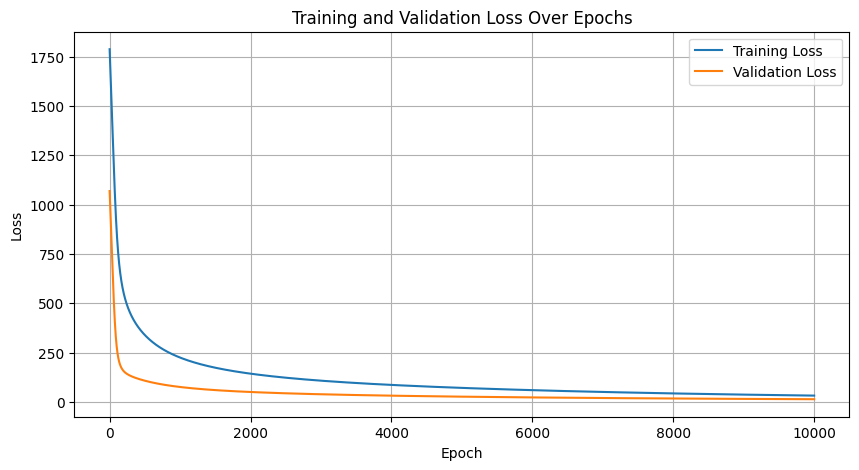


Iteration 82. Best of DGPR: 0.0. GPR model: Train loss = 13.201933860778809; Val. loss = 31.566814422607422
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.02912571   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.02912571   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.02912571   ###   (  75% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:05 -- Predicted time 00:00:20
Iteration 83 of 100
Best Loss: 14.801579475402832 at epoch 9999. Training loss: 31.552202224731445 and val. loss: 14.801579475402832


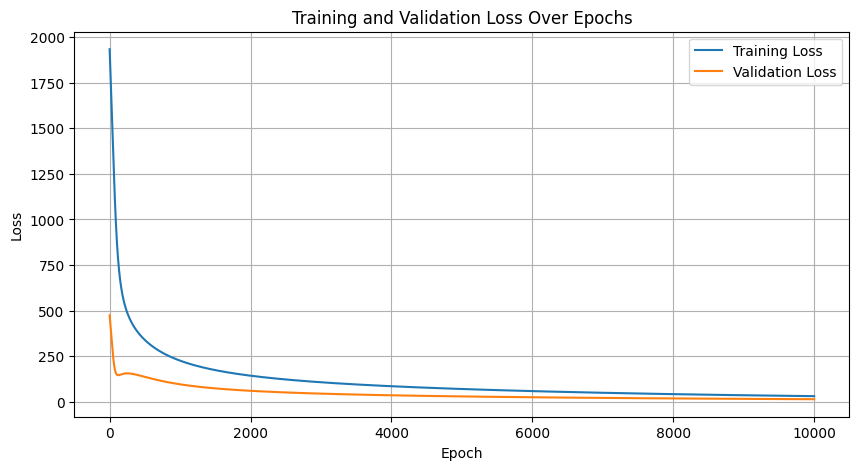


Iteration 83. Best of DGPR: 0.0. GPR model: Train loss = 14.801579475402832; Val. loss = 31.552202224731445
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:20 -- Predicted time 00:00:20
Best =          -0.03303399   ###   (  25% completed ): Elapsed time 00:00:05 -- Reamining time 00:00:15 -- Predicted time 00:00:20
Best =          -0.03303399   ###   (  50% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:10 -- Predicted time 00:00:20
Best =          -0.03303399   ###   (  75% completed ): Elapsed time 00:00:45 -- Reamining time 00:00:15 -- Predicted time 00:01:00
Iteration 84 of 100
Best Loss: 40.079952239990234 at epoch 9999. Training loss: 25.26968002319336 and val. loss: 40.079952239990234


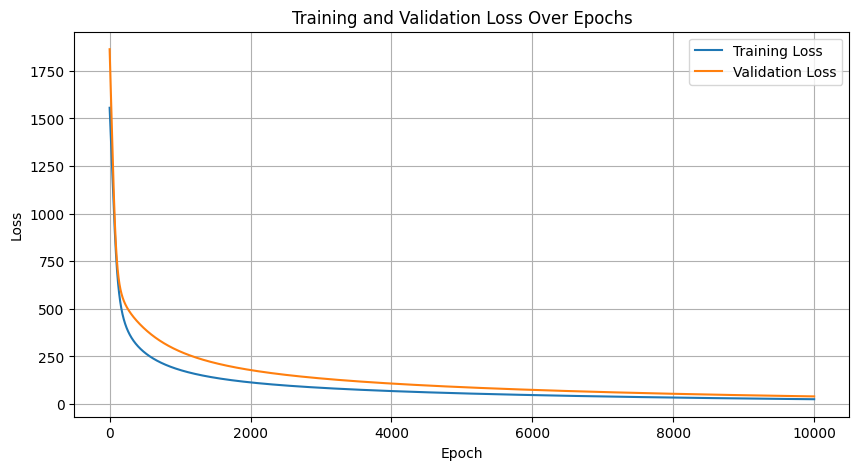


Iteration 84. Best of DGPR: 0.0. GPR model: Train loss = 40.079952239990234; Val. loss = 25.26968002319336
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.02356783   ###   (  25% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:45 -- Predicted time 00:01:00
Best =          -0.02356783   ###   (  50% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:30 -- Predicted time 00:01:00
Best =          -0.02356783   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 85 of 100
Best Loss: 41.02933120727539 at epoch 9999. Training loss: 24.17224884033203 and val. loss: 41.02933120727539


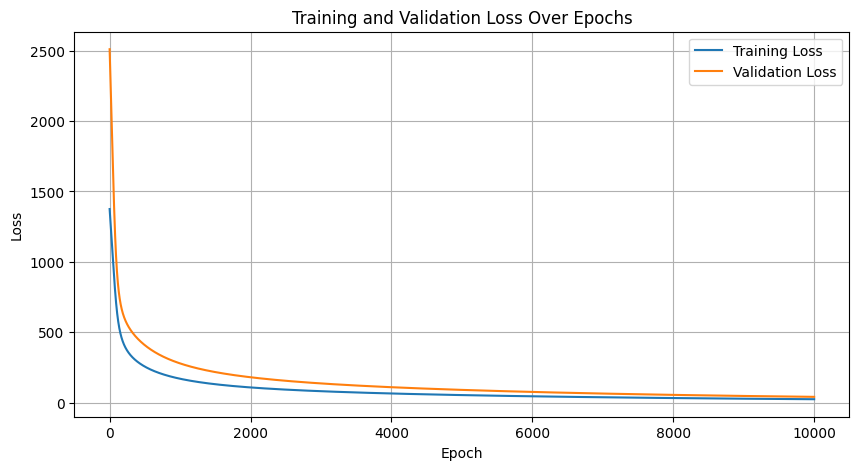


Iteration 85. Best of DGPR: 0.0. GPR model: Train loss = 41.02933120727539; Val. loss = 24.17224884033203
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:20 -- Predicted time 00:00:20
Best =          -0.01659184   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:31 -- Predicted time 00:00:41
Best =          -0.01659188   ###   (  50% completed ): Elapsed time 00:00:11 -- Reamining time 00:00:11 -- Predicted time 00:00:23
Best =          -0.01659197   ###   (  75% completed ): Elapsed time 00:00:45 -- Reamining time 00:00:15 -- Predicted time 00:01:00
Iteration 86 of 100
Best Loss: 25.481157302856445 at epoch 9999. Training loss: 28.054222106933594 and val. loss: 25.481157302856445


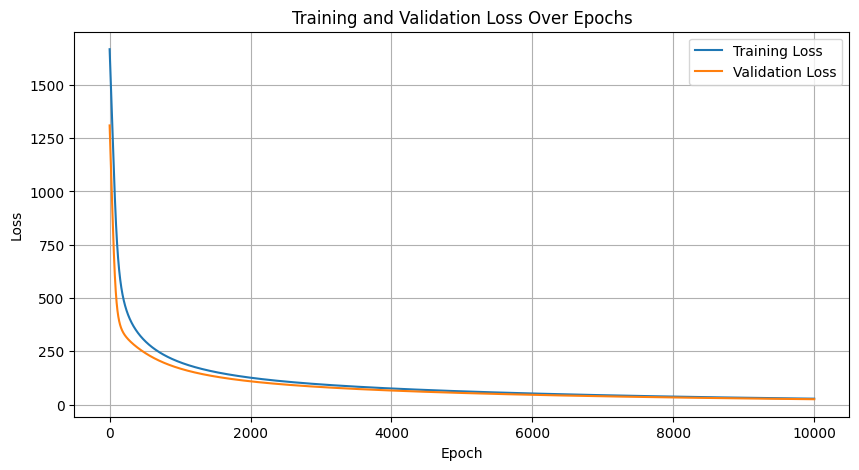


Iteration 86. Best of DGPR: 0.0. GPR model: Train loss = 25.481157302856445; Val. loss = 28.054222106933594
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:30 -- Predicted time 00:00:30
Best =          -0.03694463   ###   (  25% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:45 -- Predicted time 00:01:00
Best =          -0.03694483   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.03694483   ###   (  75% completed ): Elapsed time 00:00:22 -- Reamining time 00:00:07 -- Predicted time 00:00:30
Iteration 87 of 100
Best Loss: 31.34853744506836 at epoch 9999. Training loss: 25.625099182128906 and val. loss: 31.34853744506836


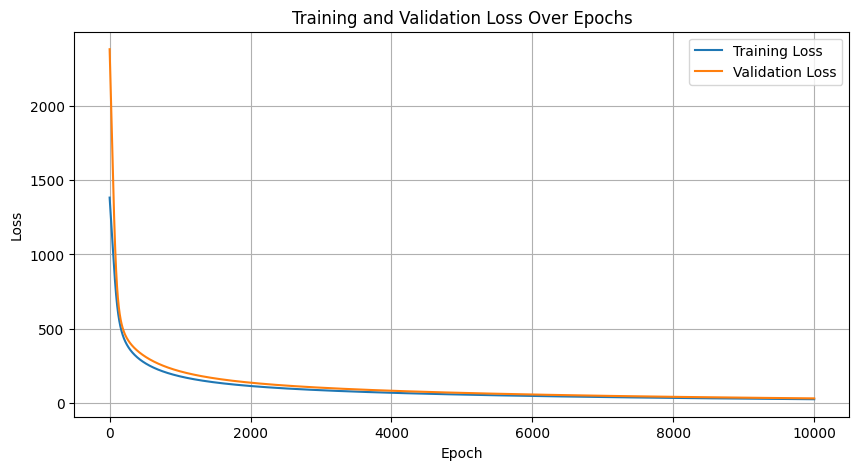


Iteration 87. Best of DGPR: 0.0. GPR model: Train loss = 31.34853744506836; Val. loss = 25.625099182128906
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.00671737   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.00671737   ###   (  50% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:10 -- Predicted time 00:00:20
Best =          -0.00671737   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 88 of 100
Best Loss: 43.64613723754883 at epoch 9999. Training loss: 23.724916458129883 and val. loss: 43.64613723754883


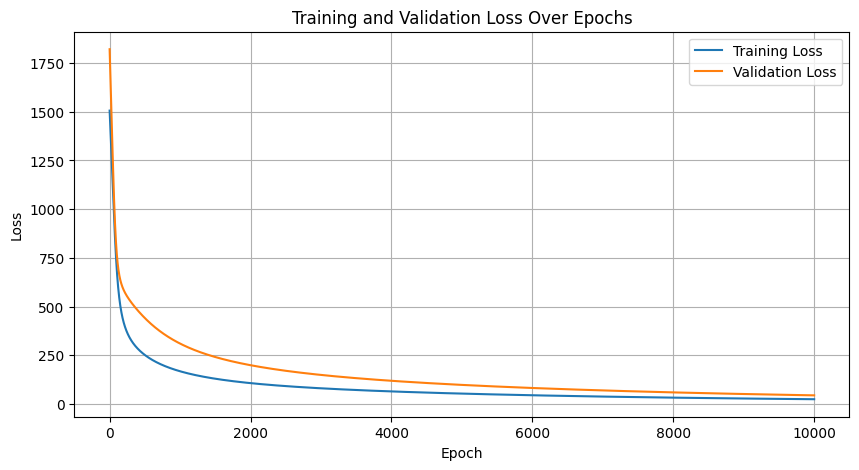


Iteration 88. Best of DGPR: 0.0. GPR model: Train loss = 43.64613723754883; Val. loss = 23.724916458129883
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:44 -- Predicted time 00:00:44
Best =          -0.02627382   ###   (  25% completed ): Elapsed time 00:00:09 -- Reamining time 00:00:29 -- Predicted time 00:00:39
Best =          -0.02627382   ###   (  50% completed ): Elapsed time 00:00:26 -- Reamining time 00:00:26 -- Predicted time 00:00:53
Best =          -0.02627382   ###   (  75% completed ): Elapsed time 00:00:29 -- Reamining time 00:00:09 -- Predicted time 00:00:39
Iteration 89 of 100
Best Loss: 38.08651351928711 at epoch 9999. Training loss: 24.684125900268555 and val. loss: 38.08651351928711


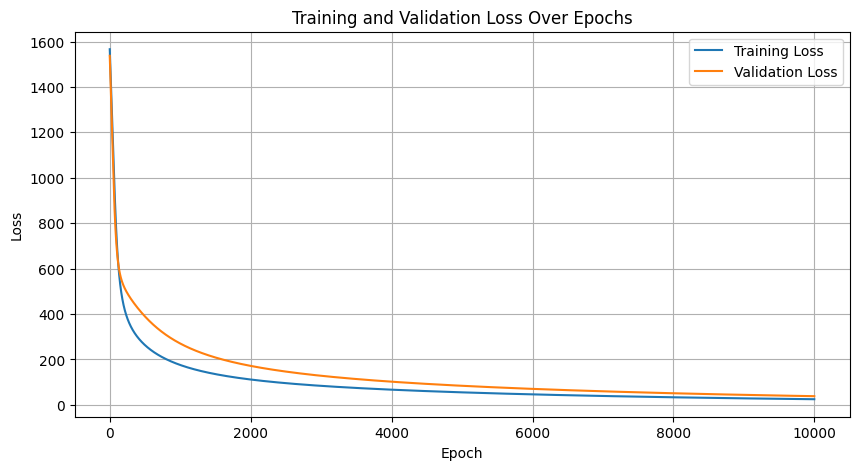


Iteration 89. Best of DGPR: 0.0. GPR model: Train loss = 38.08651351928711; Val. loss = 24.684125900268555
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.00875221   ###   (  25% completed ): Elapsed time 00:00:12 -- Reamining time 00:00:37 -- Predicted time 00:00:50
Best =          -0.00875222   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.00875223   ###   (  75% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:05 -- Predicted time 00:00:20
Iteration 90 of 100
Best Loss: 26.274057388305664 at epoch 9999. Training loss: 27.137845993041992 and val. loss: 26.274057388305664


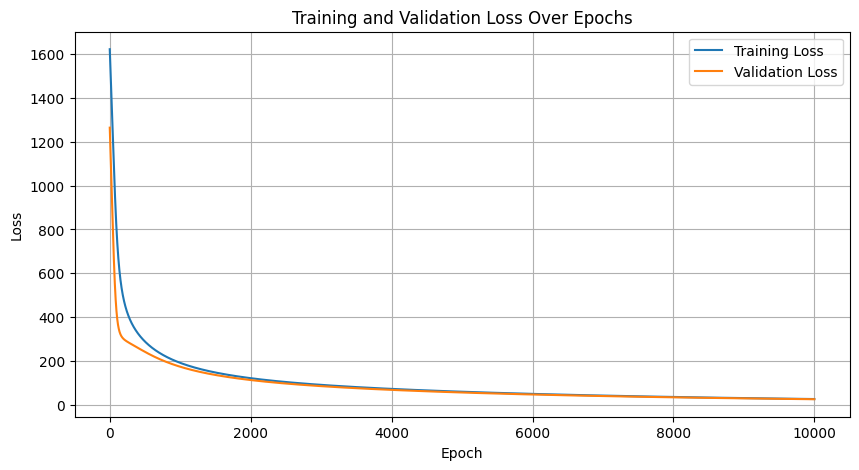


Iteration 90. Best of DGPR: 0.0. GPR model: Train loss = 26.274057388305664; Val. loss = 27.137845993041992
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.00788516   ###   (  25% completed ): Elapsed time 00:00:12 -- Reamining time 00:00:37 -- Predicted time 00:00:50
Best =          -0.00788529   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:41
Best =          -0.00788529   ###   (  75% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:05 -- Predicted time 00:00:20
Iteration 91 of 100
Best Loss: 35.433738708496094 at epoch 9999. Training loss: 24.94283103942871 and val. loss: 35.433738708496094


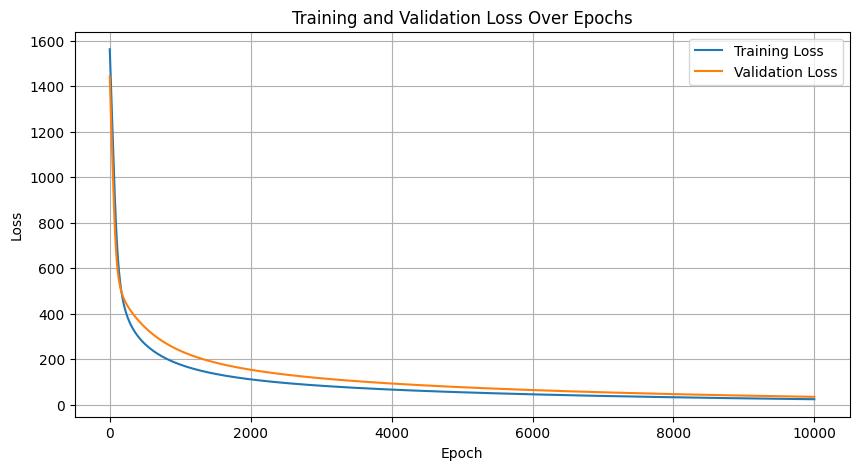


Iteration 91. Best of DGPR: 0.0. GPR model: Train loss = 35.433738708496094; Val. loss = 24.94283103942871
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.03039282   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.03039282   ###   (  50% completed ): Elapsed time 00:00:25 -- Reamining time 00:00:25 -- Predicted time 00:00:50
Best =          -0.03039282   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 92 of 100
Best Loss: 13.924386024475098 at epoch 9999. Training loss: 29.135087966918945 and val. loss: 13.924386024475098


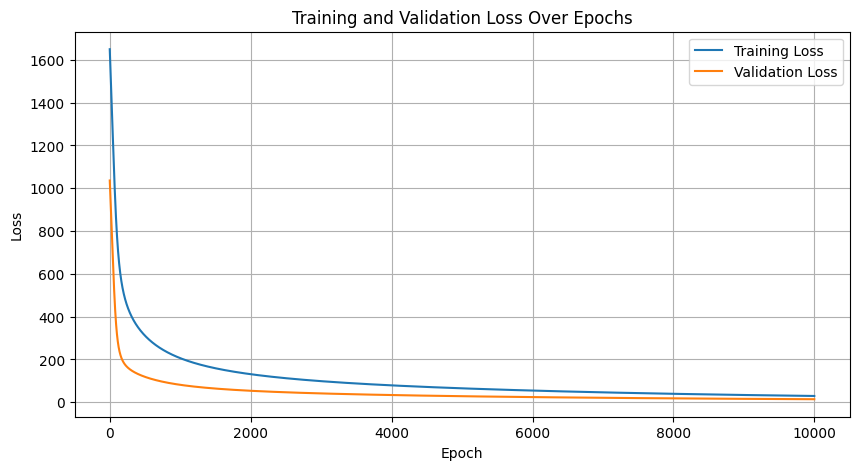


Iteration 92. Best of DGPR: 0.0. GPR model: Train loss = 13.924386024475098; Val. loss = 29.135087966918945
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.07379613   ###   (  25% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:45 -- Predicted time 00:01:00
Best =          -0.07379619   ###   (  50% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:10 -- Predicted time 00:00:20
Best =          -0.07379619   ###   (  75% completed ): Elapsed time 00:00:52 -- Reamining time 00:00:17 -- Predicted time 00:01:09
Iteration 93 of 100
Best Loss: 18.32716178894043 at epoch 9999. Training loss: 27.853191375732422 and val. loss: 18.32716178894043


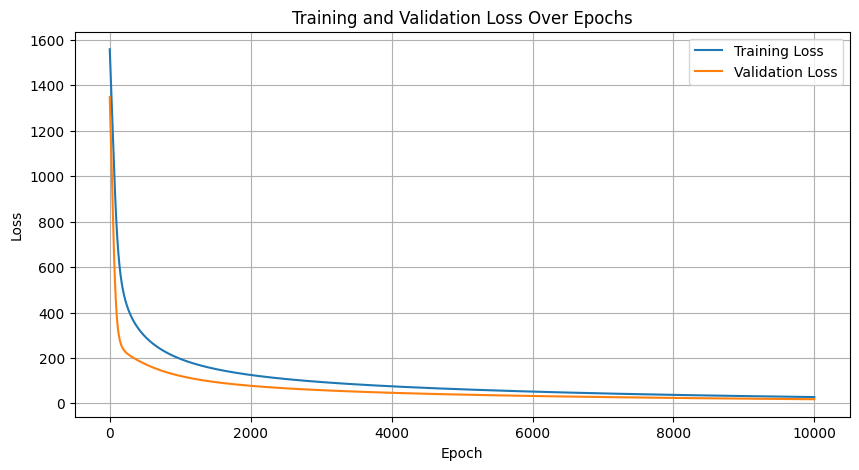


Iteration 93. Best of DGPR: 0.0. GPR model: Train loss = 18.32716178894043; Val. loss = 27.853191375732422
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.04123374   ###   (  25% completed ): Elapsed time 00:00:12 -- Reamining time 00:00:37 -- Predicted time 00:00:50
Best =          -0.04123374   ###   (  50% completed ): Elapsed time 00:00:25 -- Reamining time 00:00:25 -- Predicted time 00:00:50
Best =          -0.04123383   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 94 of 100
Best Loss: 20.825162887573242 at epoch 9999. Training loss: 27.13851547241211 and val. loss: 20.825162887573242


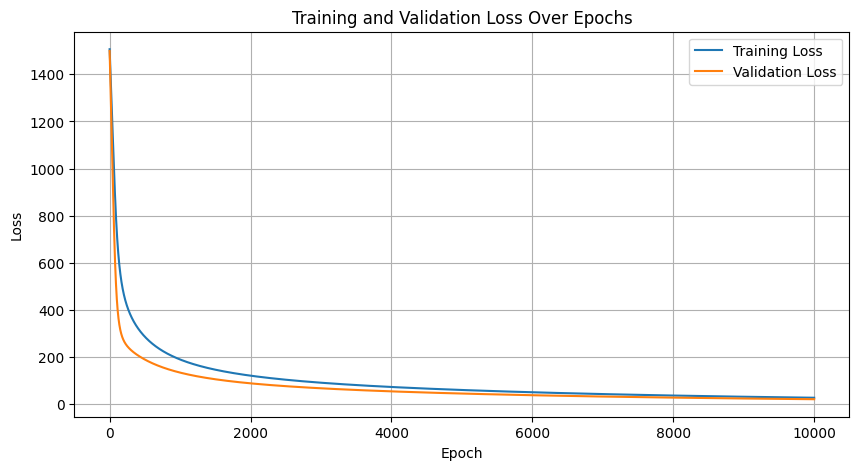


Iteration 94. Best of DGPR: 0.0. GPR model: Train loss = 20.825162887573242; Val. loss = 27.13851547241211
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:01:00 -- Predicted time 00:01:00
Best =          -0.01807150   ###   (  25% completed ): Elapsed time 00:00:05 -- Reamining time 00:00:15 -- Predicted time 00:00:20
Best =          -0.01807152   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.01807152   ###   (  75% completed ): Elapsed time 00:00:14 -- Reamining time 00:00:04 -- Predicted time 00:00:19
Iteration 95 of 100
Best Loss: 19.624042510986328 at epoch 9999. Training loss: 28.103195190429688 and val. loss: 19.624042510986328


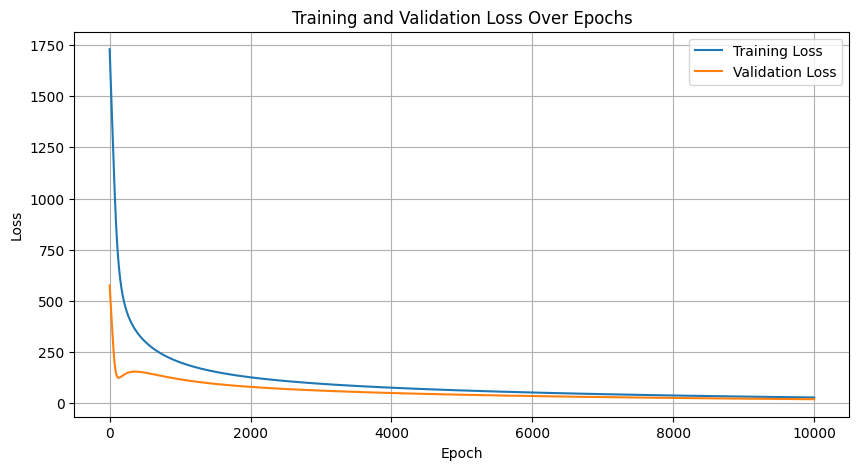


Iteration 95. Best of DGPR: 0.0. GPR model: Train loss = 19.624042510986328; Val. loss = 28.103195190429688
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.01683077   ###   (  25% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:45 -- Predicted time 00:01:00
Best =          -0.01683077   ###   (  50% completed ): Elapsed time 00:00:25 -- Reamining time 00:00:25 -- Predicted time 00:00:50
Best =          -0.01683077   ###   (  75% completed ): Elapsed time 00:00:37 -- Reamining time 00:00:12 -- Predicted time 00:00:50
Iteration 96 of 100
Best Loss: 24.603843688964844 at epoch 9999. Training loss: 26.4647159576416 and val. loss: 24.603843688964844


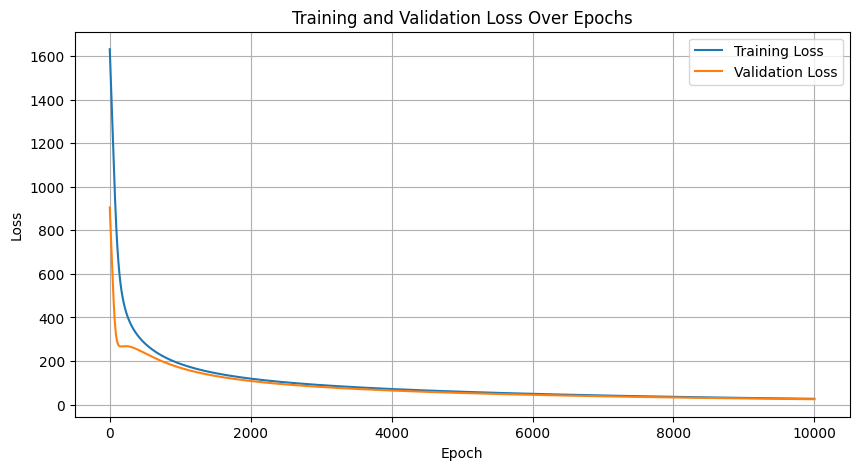


Iteration 96. Best of DGPR: 0.0. GPR model: Train loss = 24.603843688964844; Val. loss = 26.4647159576416
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.04328937   ###   (  25% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:47 -- Predicted time 00:01:02
Best =          -0.04328937   ###   (  50% completed ): Elapsed time 00:00:19 -- Reamining time 00:00:19 -- Predicted time 00:00:39
Best =          -0.04328971   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 97 of 100
Best Loss: 13.851156234741211 at epoch 9999. Training loss: 28.059354782104492 and val. loss: 13.851156234741211


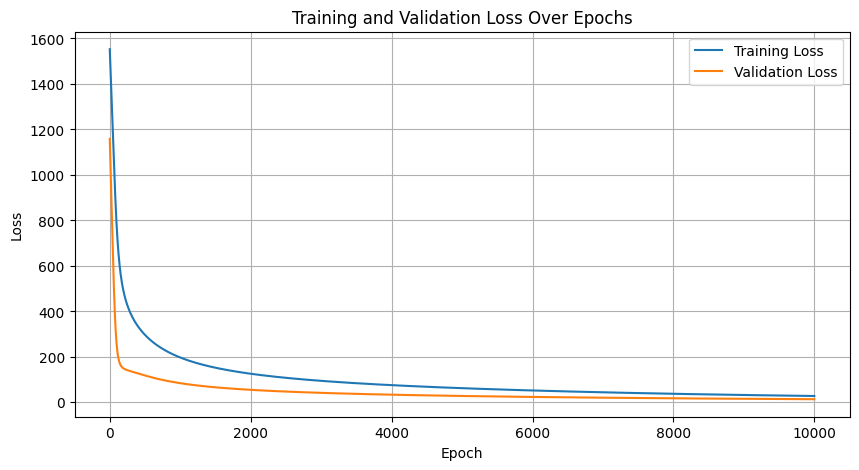


Iteration 97. Best of DGPR: 0.0. GPR model: Train loss = 13.851156234741211; Val. loss = 28.059354782104492
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.01949198   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.01949201   ###   (  50% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:10 -- Predicted time 00:00:20
Best =          -0.01949211   ###   (  75% completed ): Elapsed time 00:00:34 -- Reamining time 00:00:11 -- Predicted time 00:00:45
Iteration 98 of 100
Best Loss: 53.693336486816406 at epoch 9999. Training loss: 18.884037017822266 and val. loss: 53.693336486816406


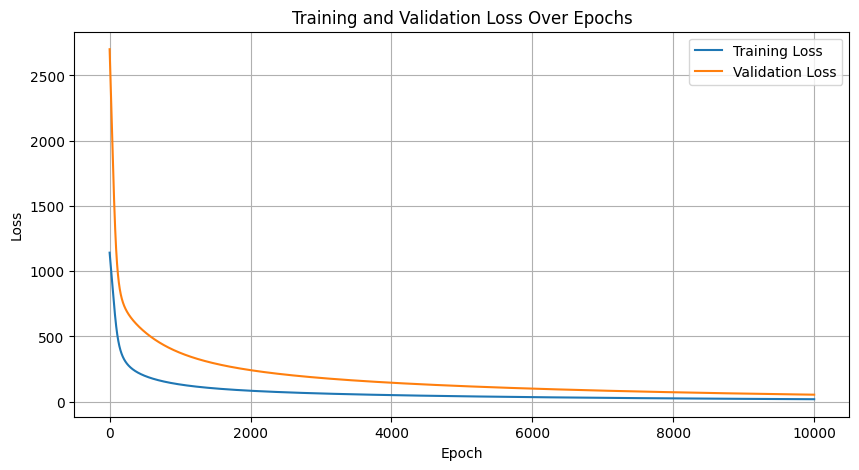


Iteration 98. Best of DGPR: 0.0. GPR model: Train loss = 53.693336486816406; Val. loss = 18.884037017822266
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.01047287   ###   (  25% completed ): Elapsed time 00:00:15 -- Reamining time 00:00:45 -- Predicted time 00:01:00
Best =          -0.01047287   ###   (  50% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:10 -- Predicted time 00:00:20
Best =          -0.01047287   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 99 of 100
Best Loss: 23.23232078552246 at epoch 9999. Training loss: 25.89988136291504 and val. loss: 23.23232078552246


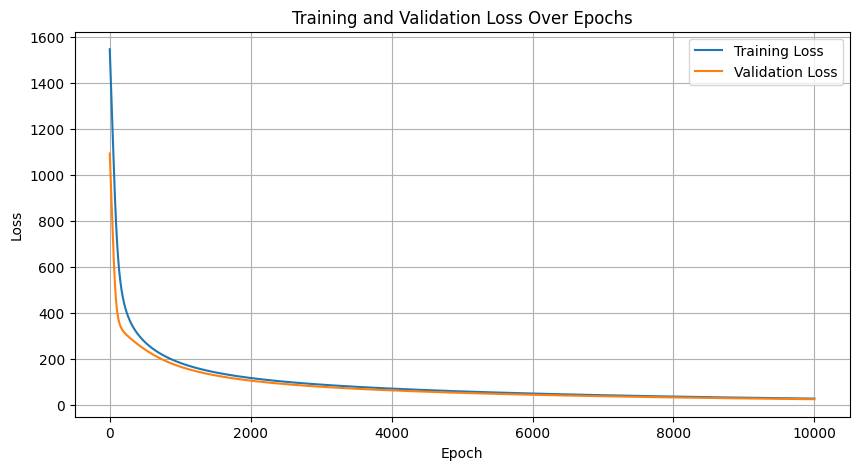


Iteration 99. Best of DGPR: 0.0. GPR model: Train loss = 23.23232078552246; Val. loss = 25.89988136291504
Best =          -0.00000000   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:40 -- Predicted time 00:00:40
Best =          -0.01528486   ###   (  25% completed ): Elapsed time 00:00:10 -- Reamining time 00:00:30 -- Predicted time 00:00:40
Best =          -0.01528495   ###   (  50% completed ): Elapsed time 00:00:20 -- Reamining time 00:00:20 -- Predicted time 00:00:40
Best =          -0.01528495   ###   (  75% completed ): Elapsed time 00:00:30 -- Reamining time 00:00:10 -- Predicted time 00:00:40
Iteration 100 of 100
Best Loss: 26.343809127807617 at epoch 9999. Training loss: 25.447126388549805 and val. loss: 26.343809127807617


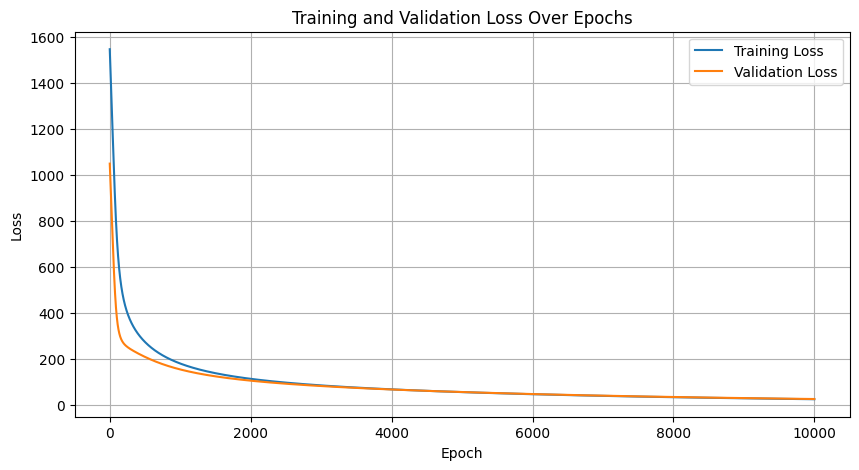


Iteration 100. Best of DGPR: 0.0. GPR model: Train loss = 26.343809127807617; Val. loss = 25.447126388549805


In [123]:
while it < N_INFILL:
    it += 1
    
    # Search for the maximum expected improvement
    new_point = bsa(expected_improvement, bounds=BOUNDS_BSA,
                    popsize=BSA_POPSIZE, epoch=BSA_EPOCH, data=model)
    x_new = torch.from_numpy(new_point.x).float()  # Garantir que x_new esteja em float
    EI = new_point.y

    # Objective function at the new point
    f_new = obj_fun(x_new.unsqueeze(0).float())  # Garante que x_new é float32 e 1D
    f_new = f_new.view(-1)                       # Ajusta f_new para a concatenação com f

    print(f'Iteration {it} of {N_INFILL}')
    if f_new.item() < torch.min(f).item():       # Converte f_new e torch.min(f) para escalares
        print(f'New best: {float(f_new):.2f} at position {it}')
    
    # Add new values to the initial sampling
    x = torch.cat((x, x_new.unsqueeze(0)), 0).float()
    f = torch.cat((f, f_new), 0).float()
    
    # Update model
    train_x, val_x, train_g, val_g = train_test_split(x.float(), f.float(), test_size=0.20)
    model, likelihood, best_loss = train_model(train_x, train_g, val_x, val_g, TRAINING_ITERATIONS)
    model = model.to(torch.float32)
    likelihood = likelihood.to(torch.float32)
    model.eval()
    likelihood.eval()
    
    print(f'\nIteration {it}. Best of DGPR: {torch.min(f)}. GPR model: Train loss = {best_loss[0]}; Val. loss = {best_loss[-1]}')
    
    # if abs(EI) < TOL_MIN_EI:
    #     print('Optimization finished. Minimum tolerance achieved.')
    #     break


In [124]:
print(f'f*: {torch.min(f):.2f}; x*: {x[torch.argmin(f), :]}')


f*: 0.00; x*: tensor([4.1538e-01, 8.6884e-01, 2.3378e-01, 4.3420e-01, 7.2555e-01, 6.3645e-01,
        3.3716e-01, 4.0025e-04, 1.3008e-01, 7.9638e-01, 9.1340e-01])


### Save results

In [1]:
results = dict()
results["x"] = x
results["f"] = f
results["n_initial"] = N_INITIAL
results["n_infill"] = N_INFILL
results["OFEs"] = N_INITIAL + it

NameError: name 'x' is not defined

In [126]:
name_f, name_x = 'f.mat', 'x.mat'
path = './'
pathname_f = path + name_f
pathname_x = path + name_x

sio.savemat(name_f, {'f': f.numpy()})
sio.savemat(name_x, {'x': x.numpy()})

### Plot optimization history

In [127]:
# Plotting the cost history
plt.figure(figsize=(8, 6))  # Optional: Set figure size
plt.plot(np.arange(EPOCHS), results.convergence, marker='o', linestyle='-', color='b', label='Cost History')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Cost History per Epoch')
plt.legend()

# Display the plot
plt.grid(True)  # Optional: Add grid for better visualization
plt.show()

AttributeError: 'dict' object has no attribute 'convergence'

<Figure size 800x600 with 0 Axes>

In [128]:
#Sair da port do mapdl e fechar o processo
mapdl.exit()